# Plots of Deposition Number 1

In [10]:
import pandas as pd
import numpy as np
import os, glob, re, csv
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths, savgol_filter
from scipy.optimize import curve_fit
from matplotlib.tri import Triangulation
from matplotlib.colors import LinearSegmentedColormap, PowerNorm, Normalize  # or Normalize
from pathlib import Path



# Show current working directory
print("Current directory:", os.getcwd())

# Change working directory
os.chdir("C:\\Dilan\\Study\\Master Thesis\\Characterization\\XRD\\30-09-2025 Dep 1")

folder = "C:\\Dilan\\Study\\Master Thesis\\Characterization\\XRD\\30-09-2025 Dep 1\\XY Data"
os.chdir(folder)

files = glob.glob("*.xy")

# Define all deposition folders to process
BASE_DIR = r"C:\Dilan\Study\Master Thesis\Characterization\XRD"

DEPOSITIONS = [
    "30-09-2025 Dep 1",
    "22-09-2025 Dep 2",
    "24-09-2025 Dep 3",
    "07-10-2025 Dep 6",
    "08-10-2025 Dep 7",
    "09-10-2025 Dep 8"
]

# Target position (mm) - same for all depositions
target_x = 399.88
target_y = 224.1
target_z = 332.15

# Wafer center position (x=0, y=0 in XRD coordinates corresponds to this)
wafer_center_x = 242.5
wafer_center_y = 257.0
wafer_center_z = 435.0

print(f"Base directory: {BASE_DIR}")
print(f"\nDepositions to process: {len(DEPOSITIONS)}")
for dep in DEPOSITIONS:
    print(f"  - {dep}")

Current directory: C:\Dilan\Study\Master Thesis\Characterization\XRD\30-09-2025 Dep 1\XY Data
Base directory: C:\Dilan\Study\Master Thesis\Characterization\XRD

Depositions to process: 6
  - 30-09-2025 Dep 1
  - 22-09-2025 Dep 2
  - 24-09-2025 Dep 3
  - 07-10-2025 Dep 6
  - 08-10-2025 Dep 7
  - 09-10-2025 Dep 8


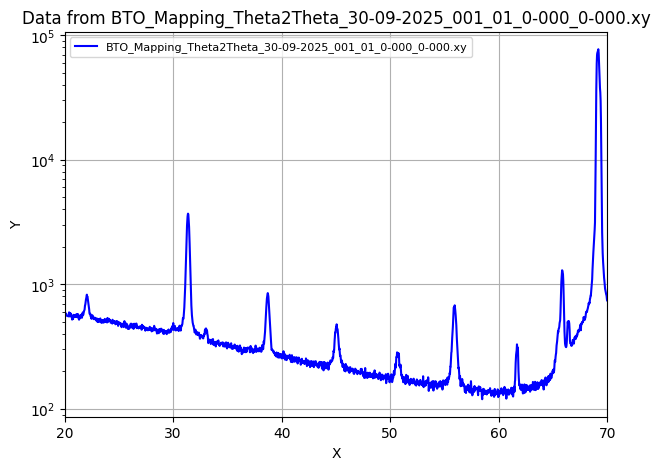

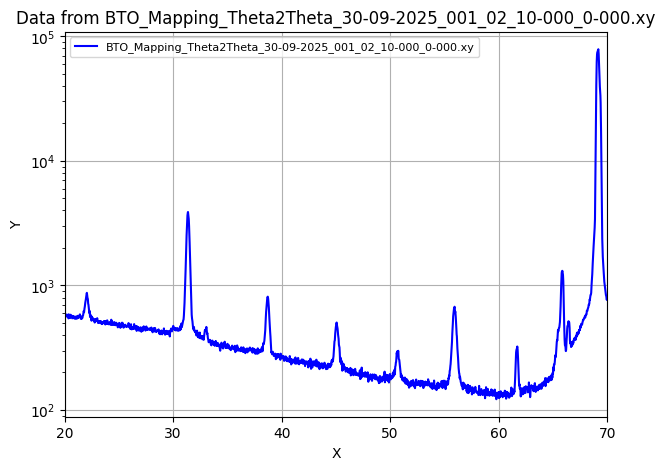

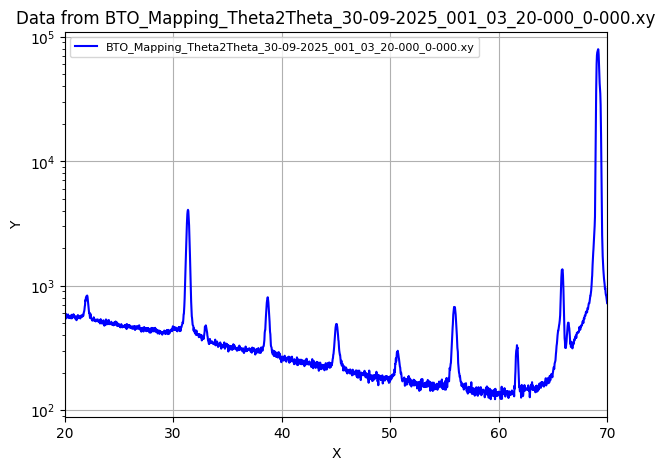

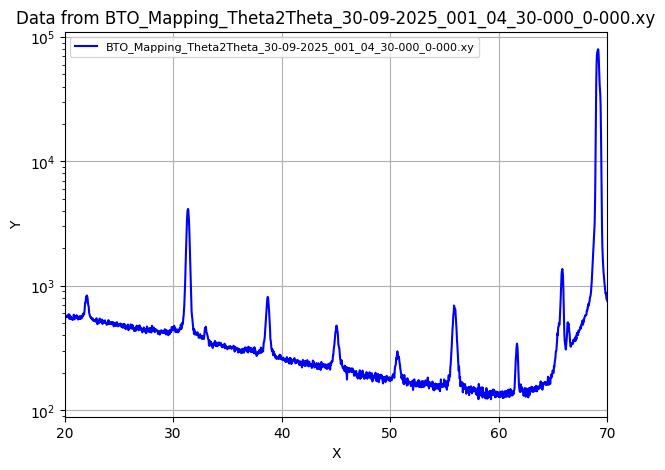

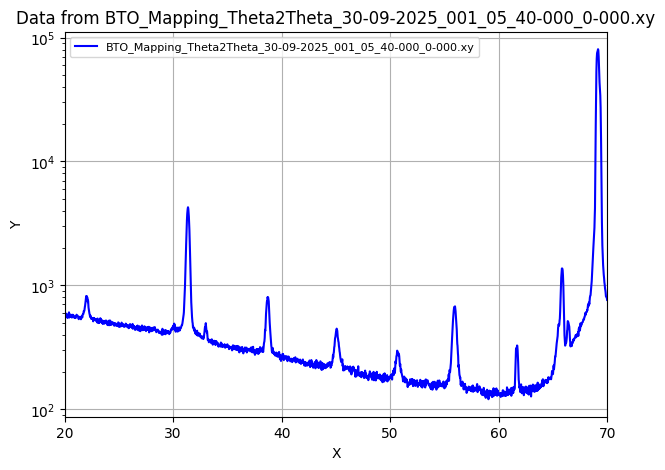

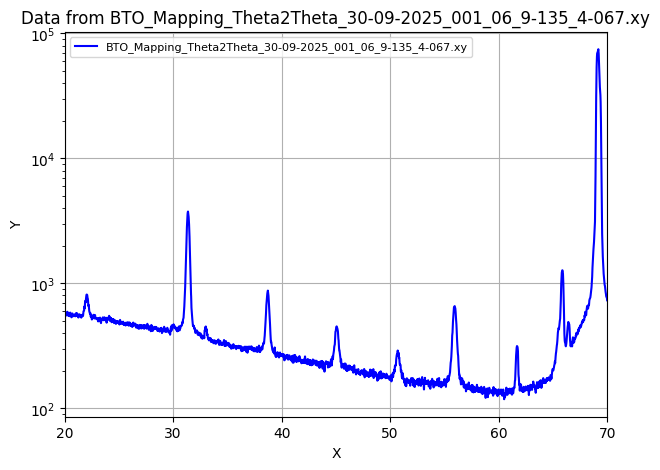

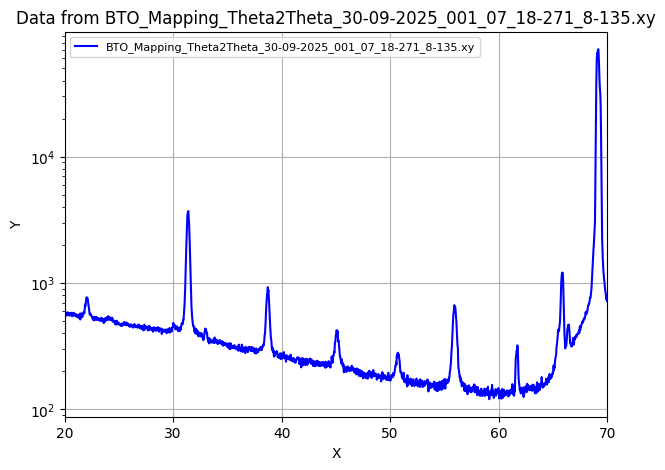

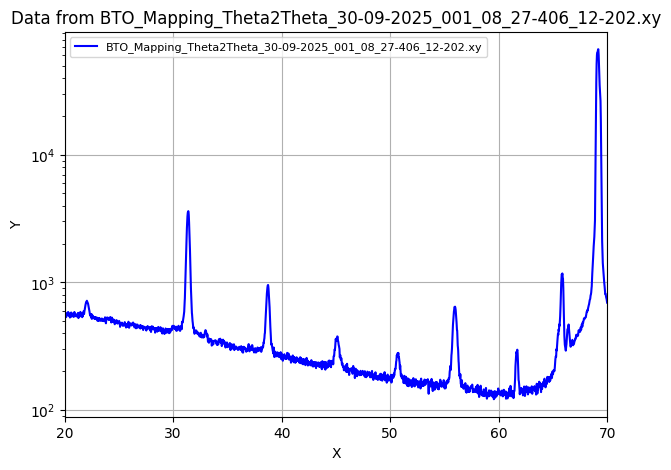

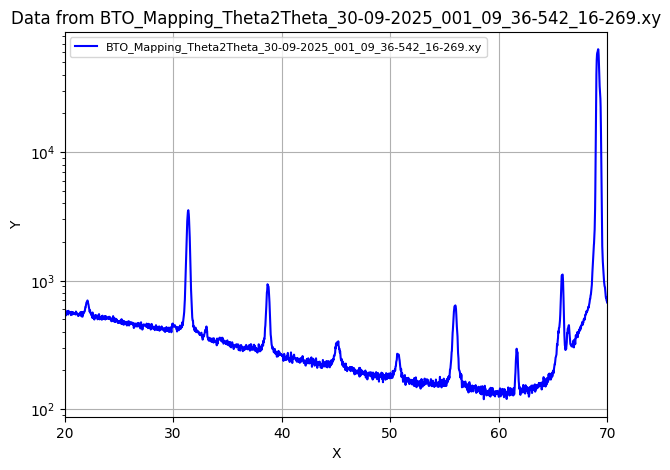

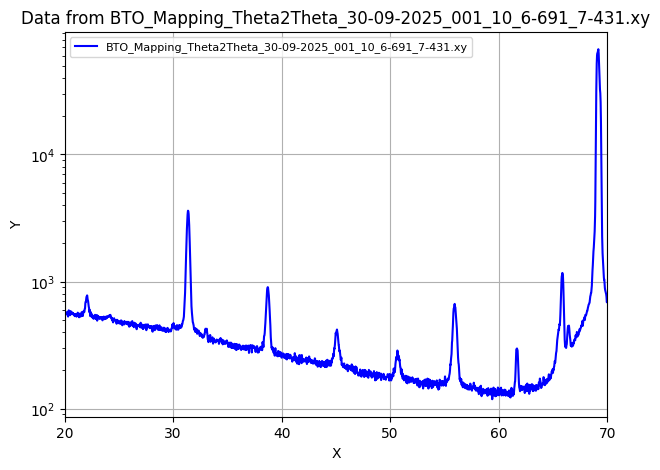

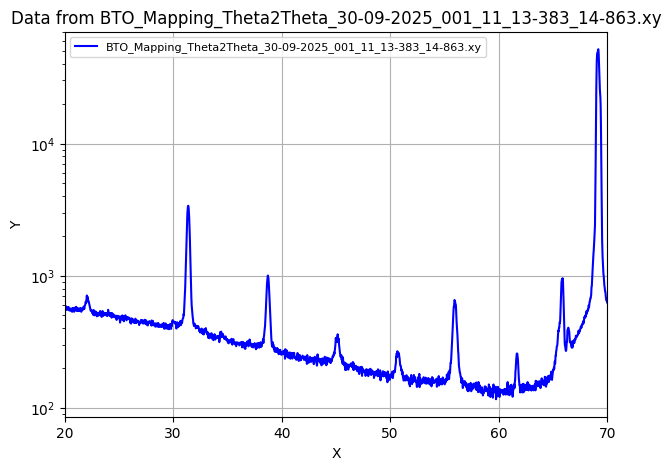

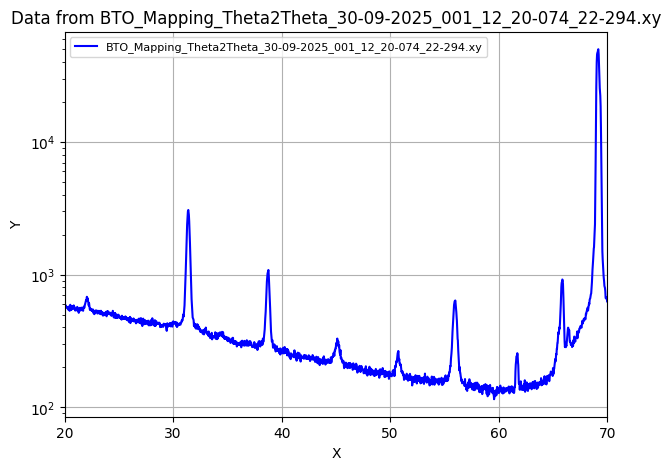

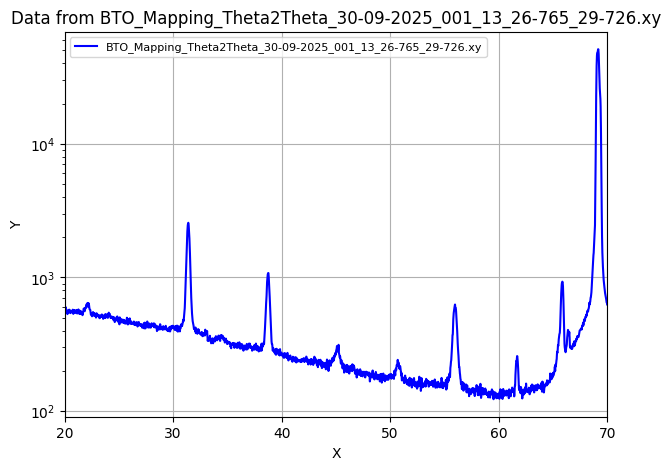

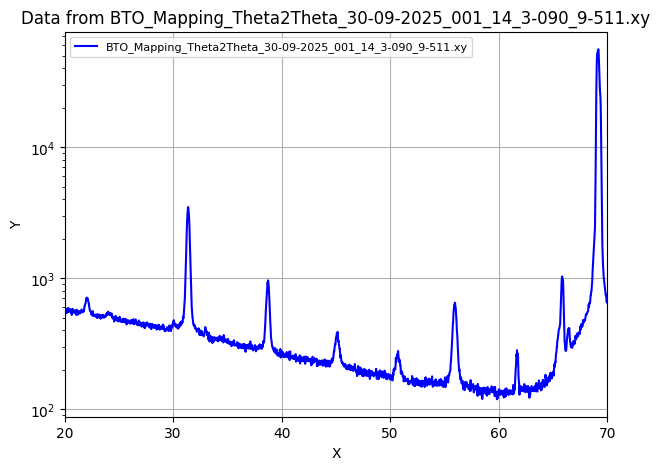

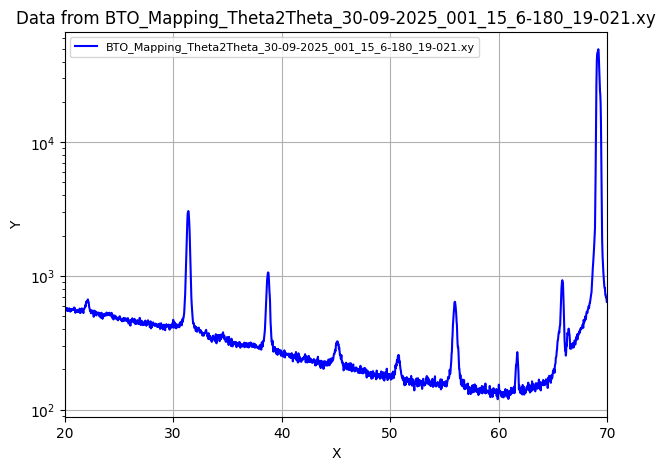

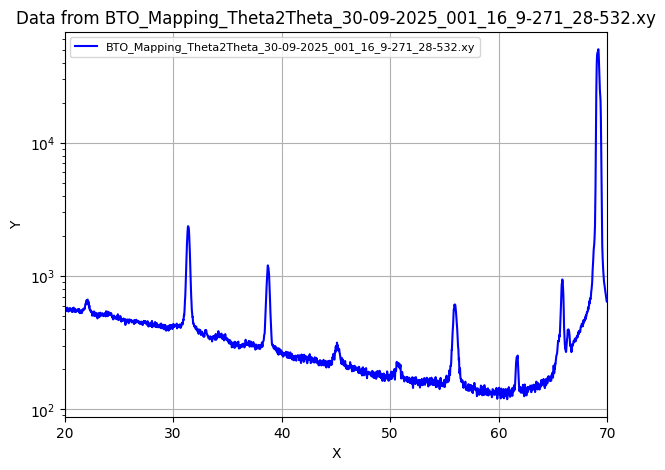

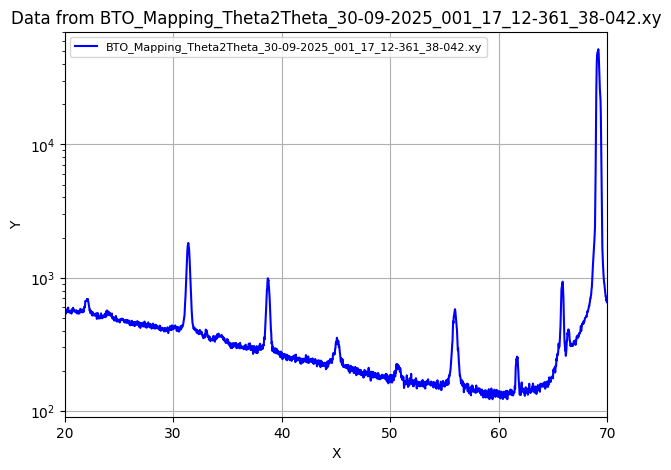

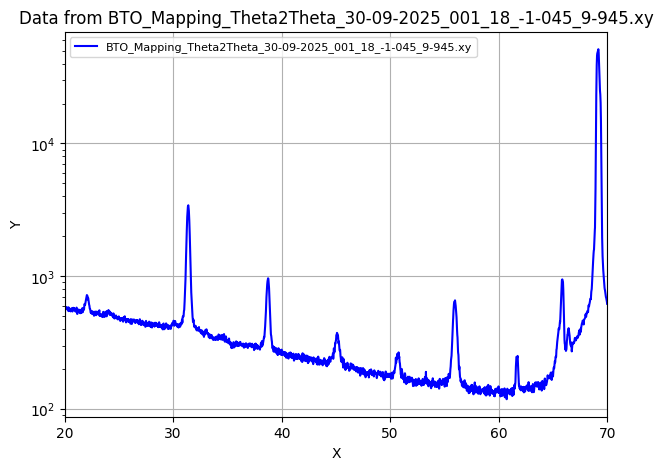

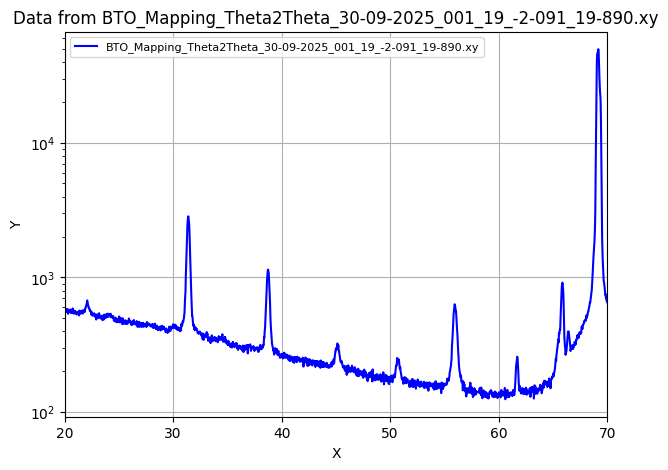

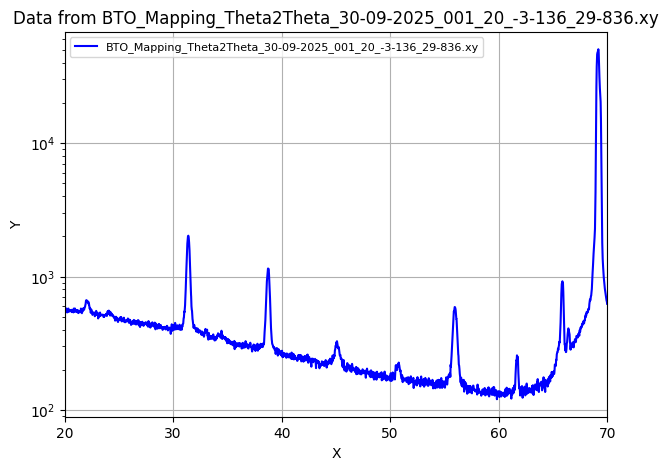

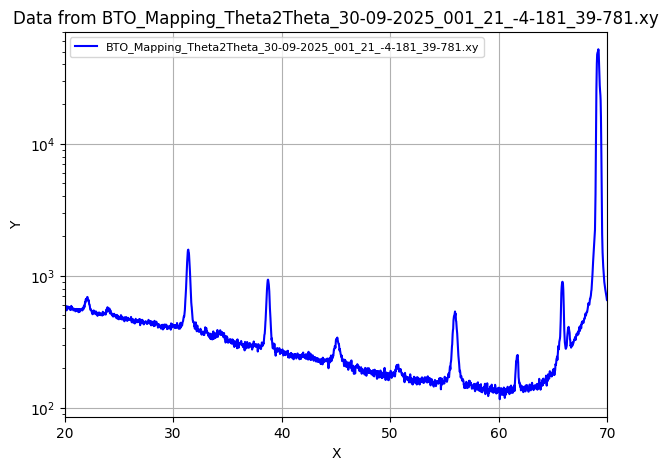

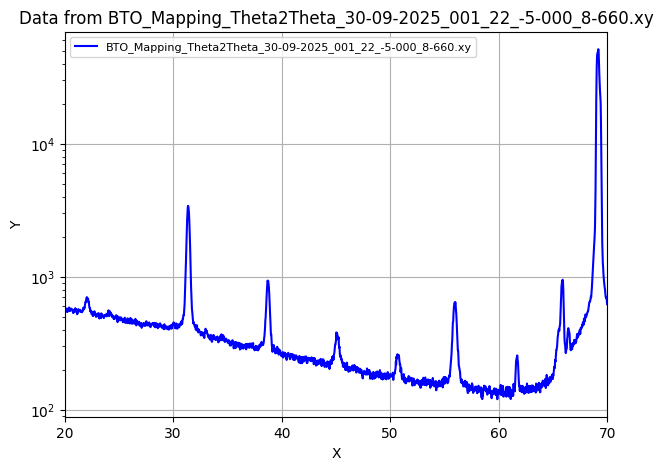

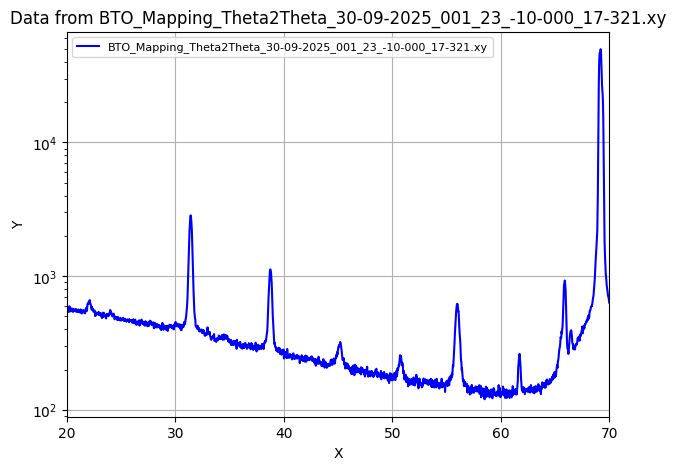

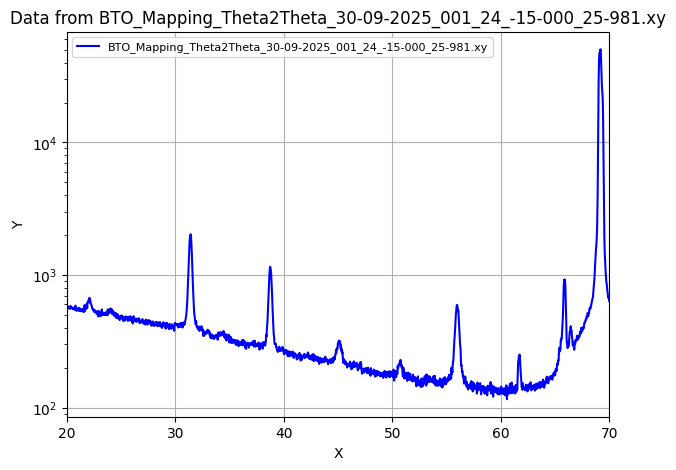

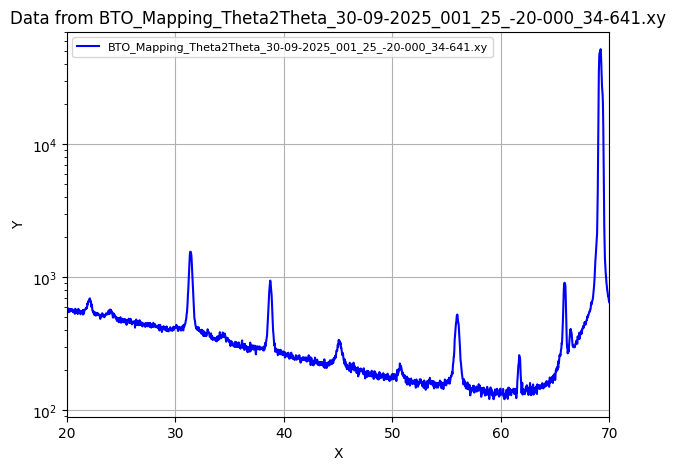

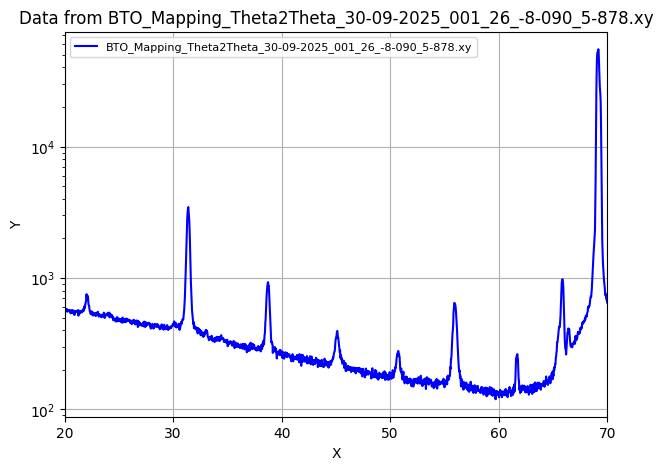

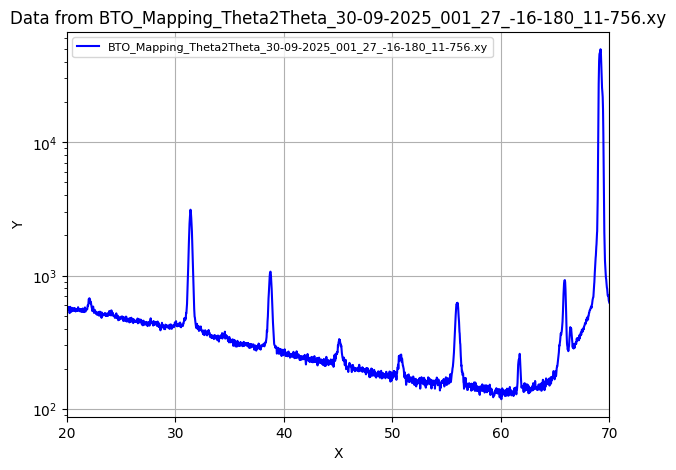

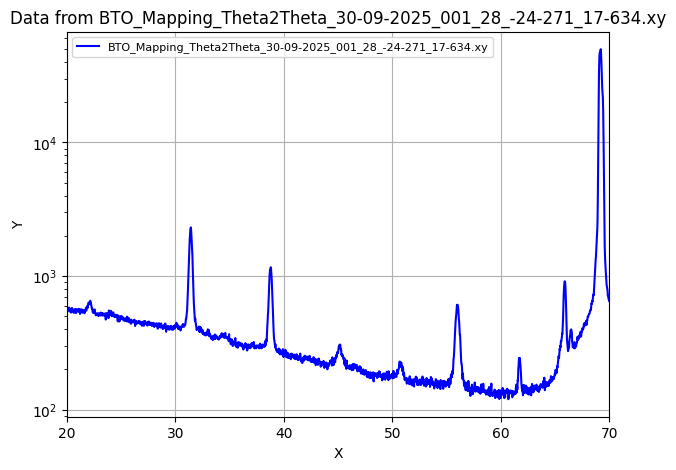

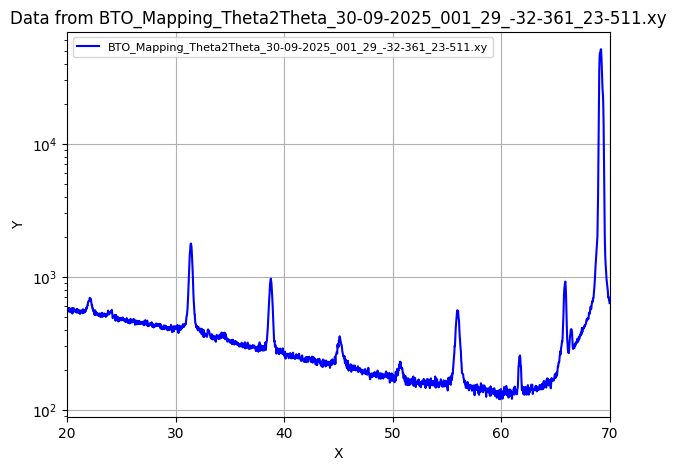

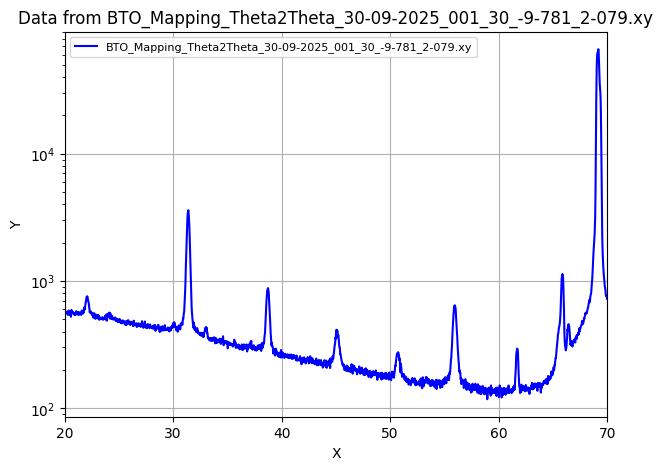

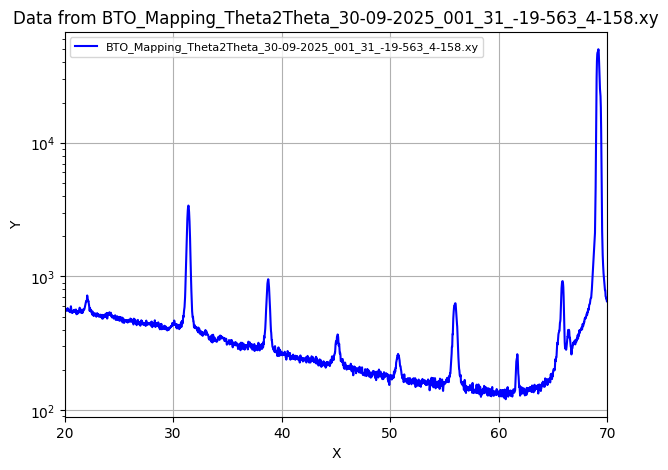

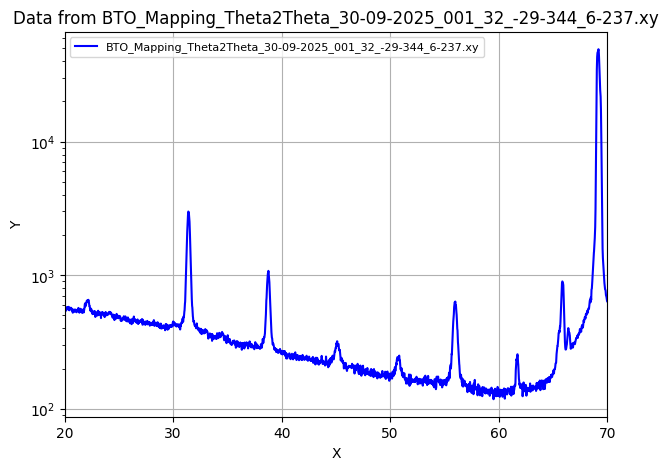

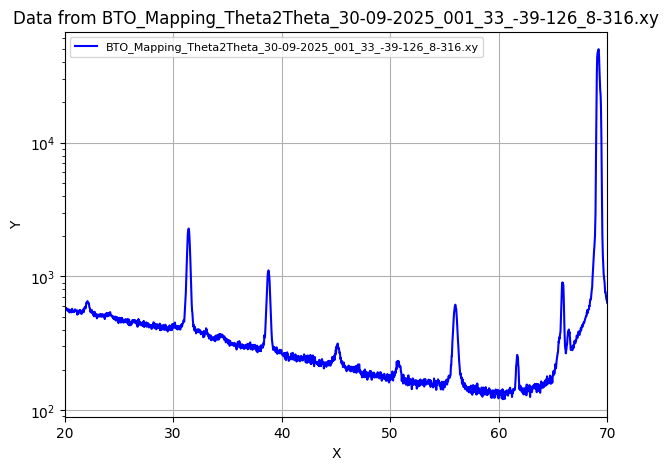

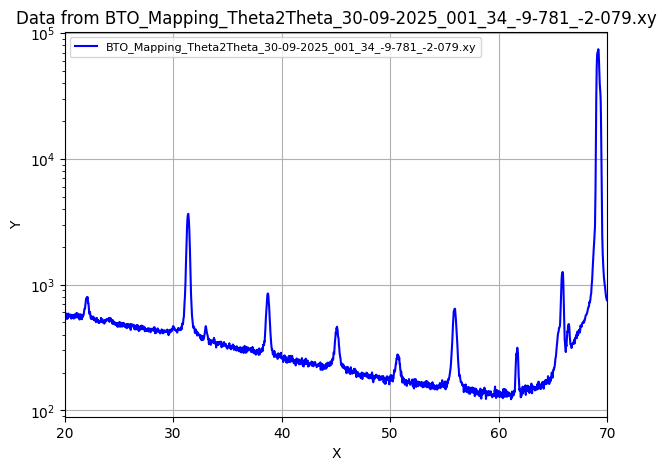

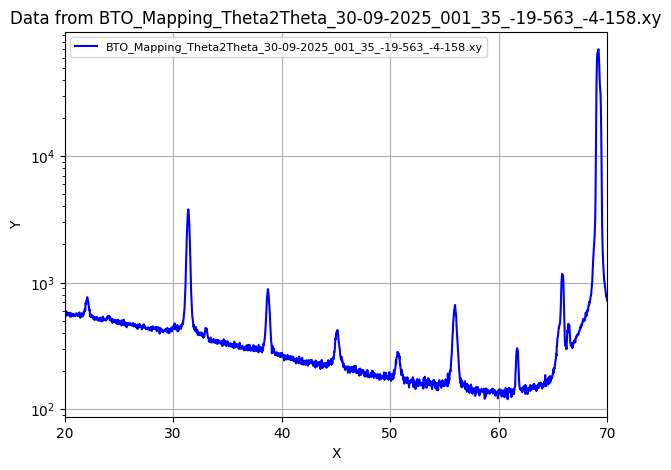

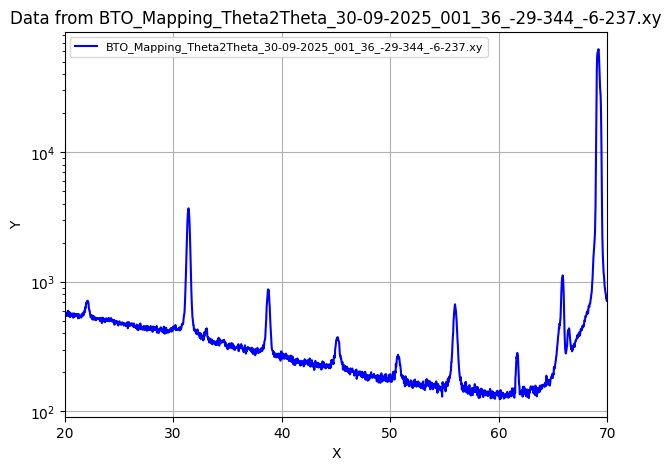

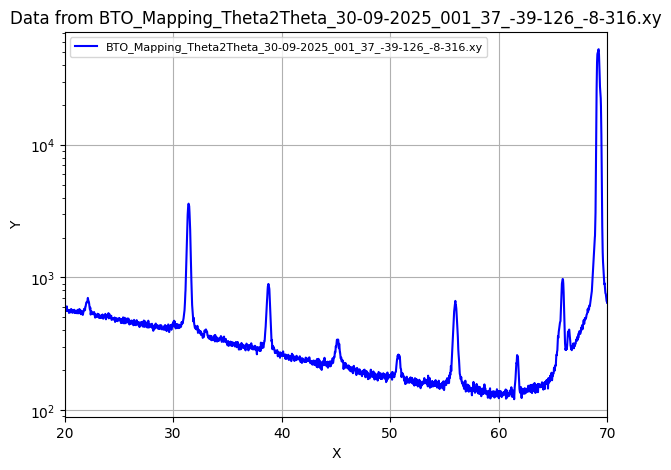

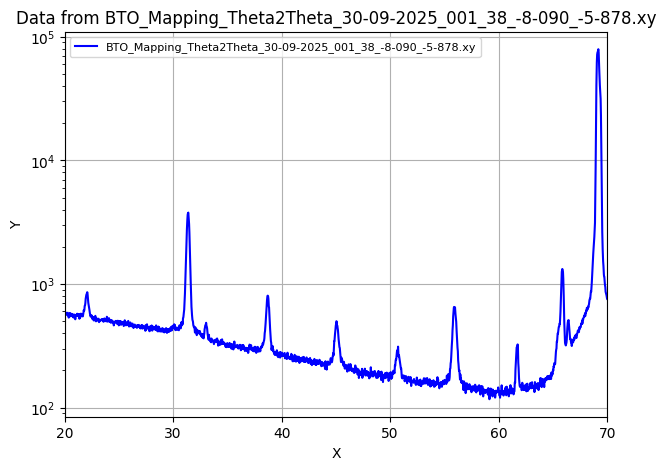

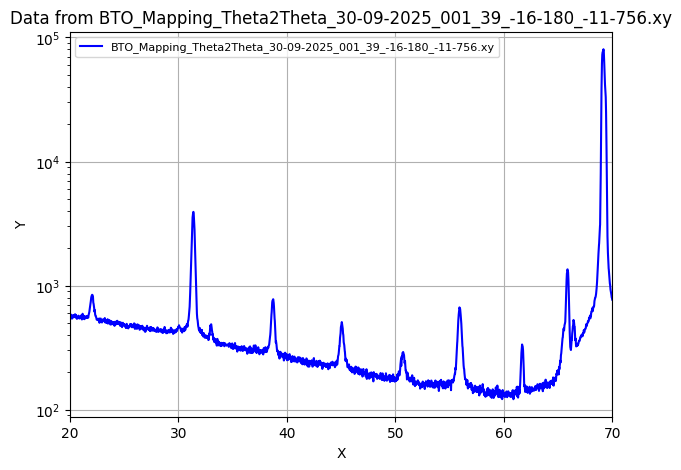

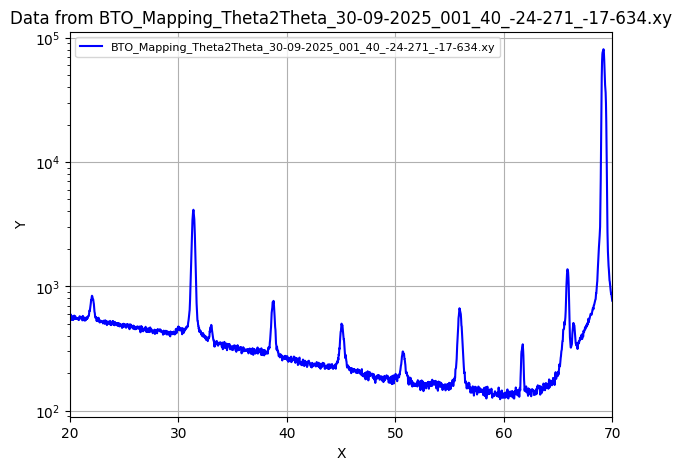

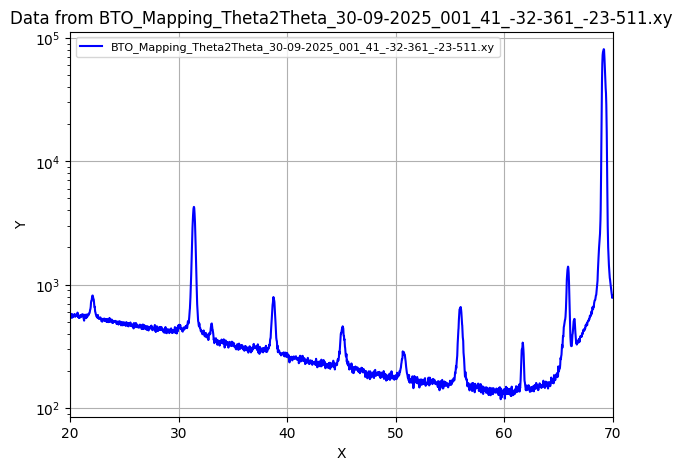

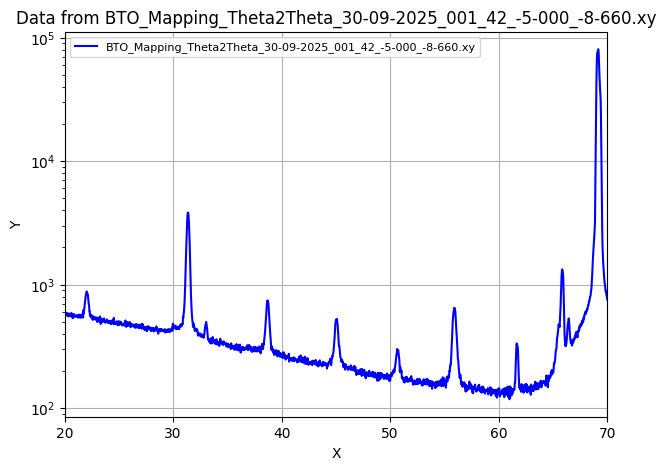

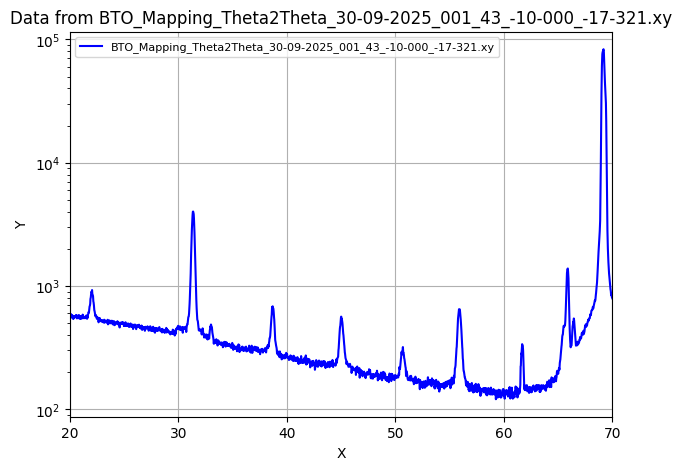

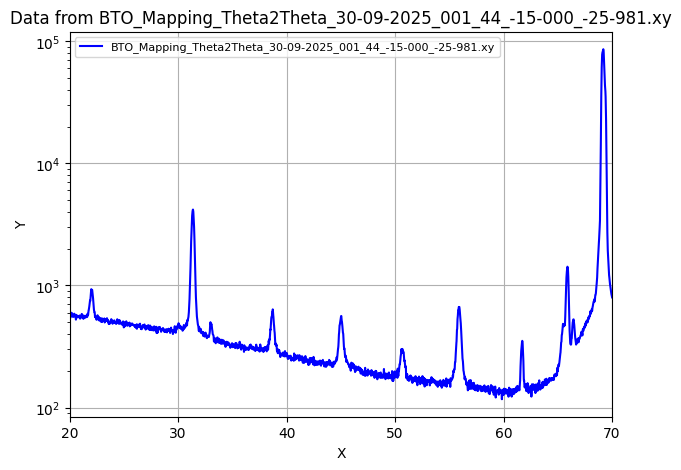

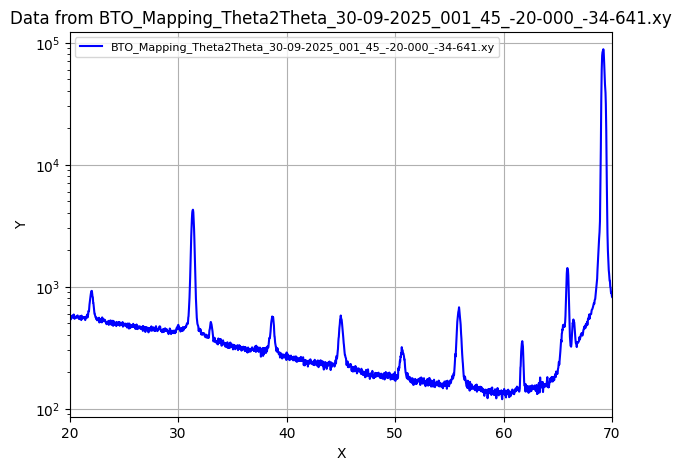

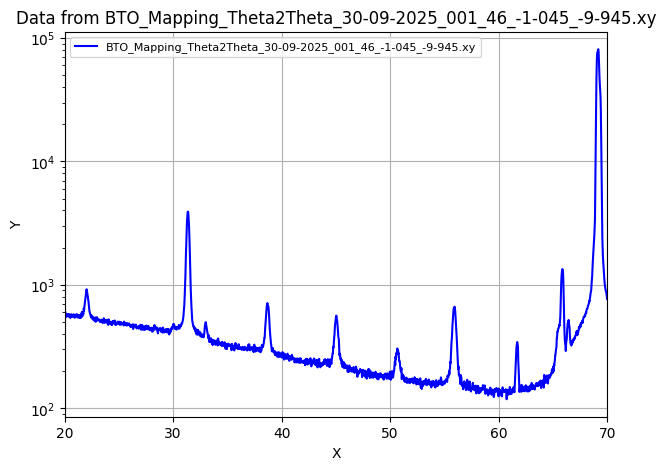

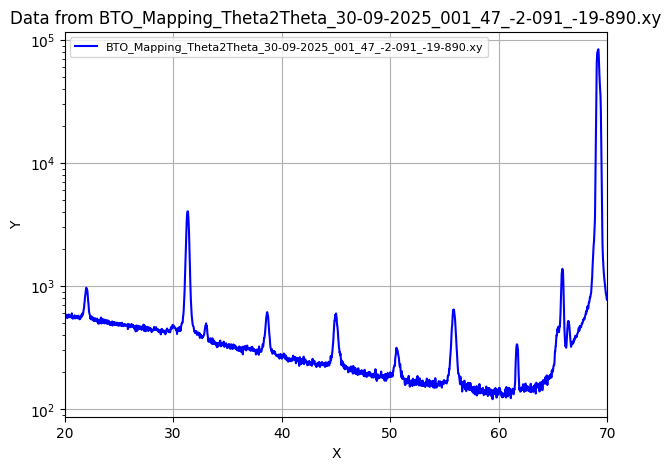

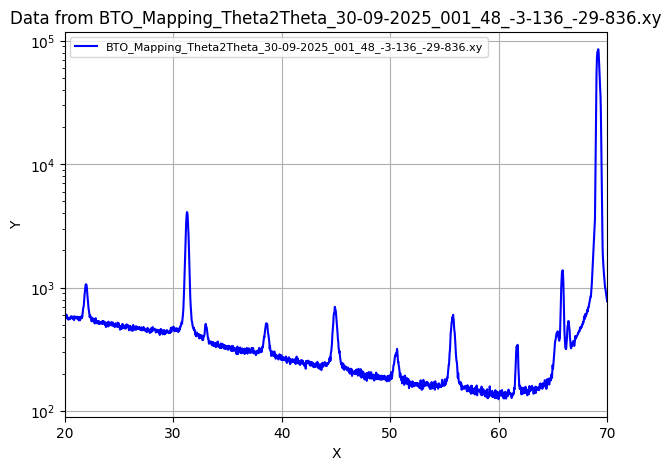

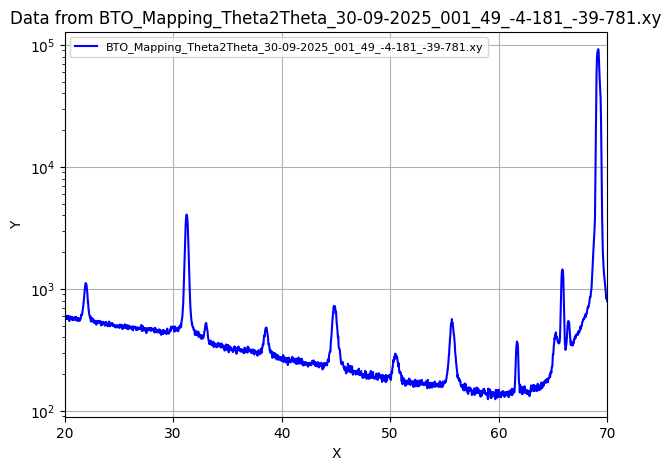

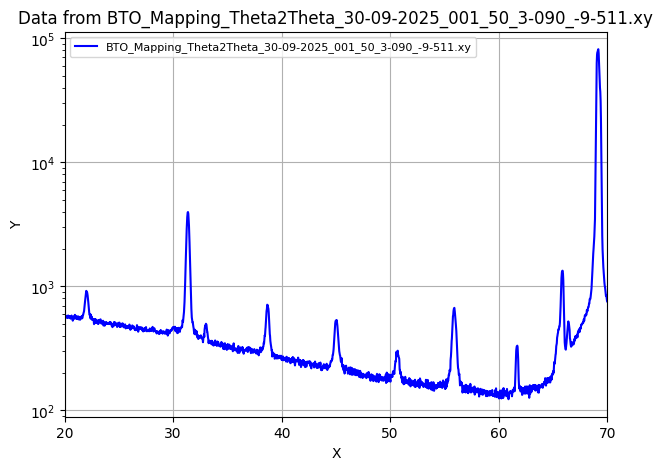

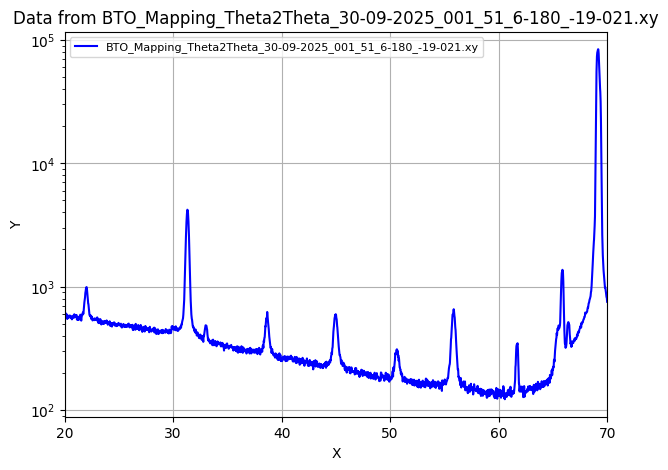

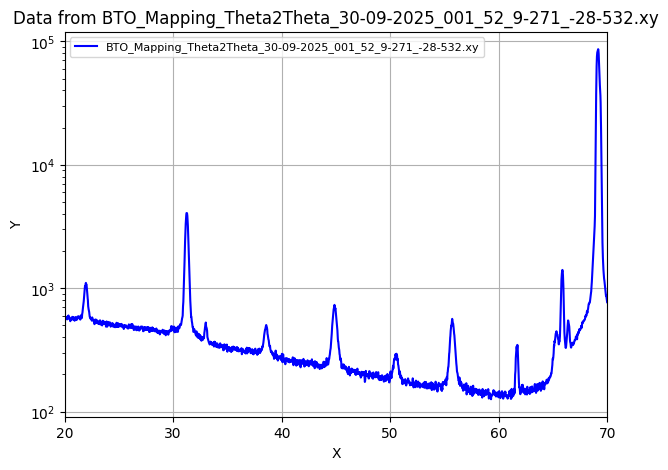

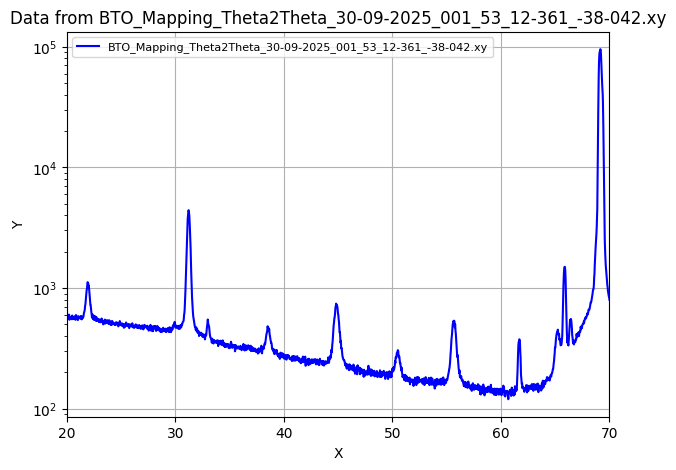

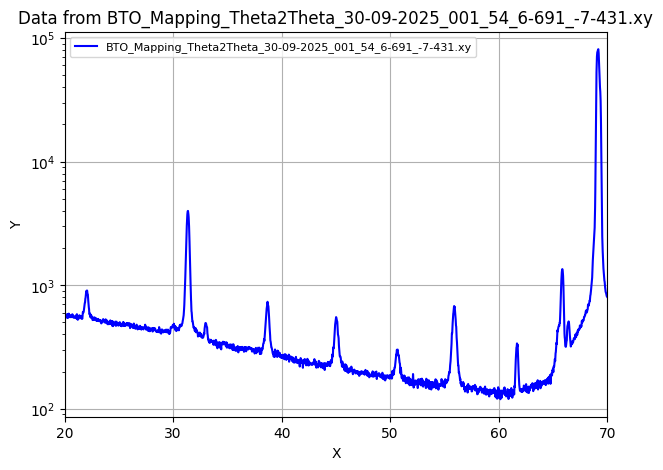

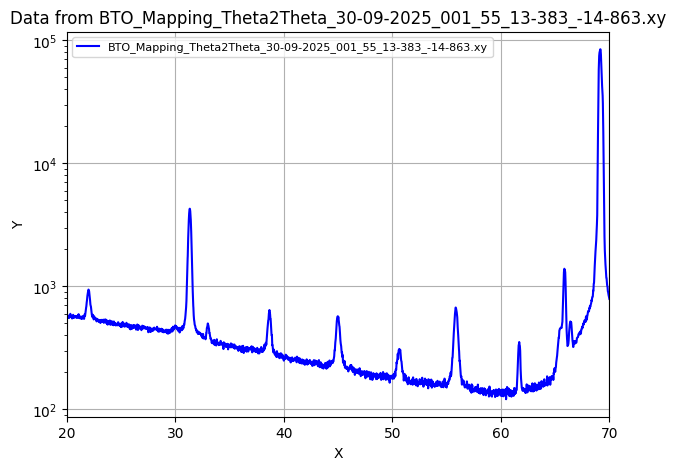

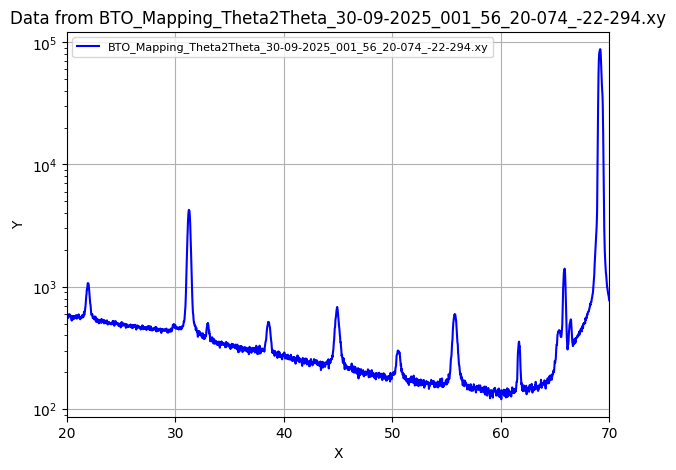

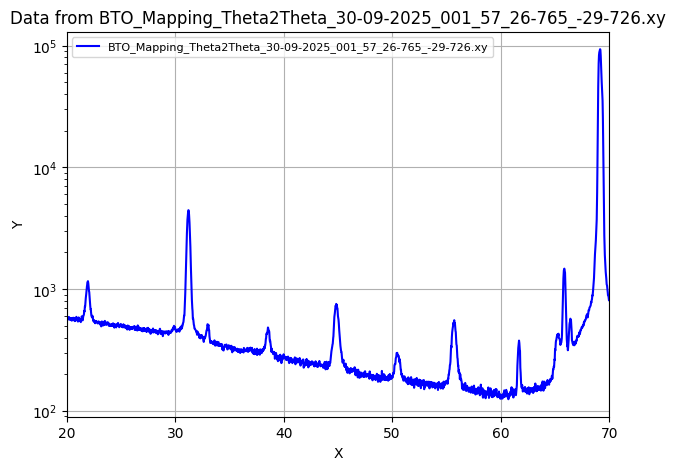

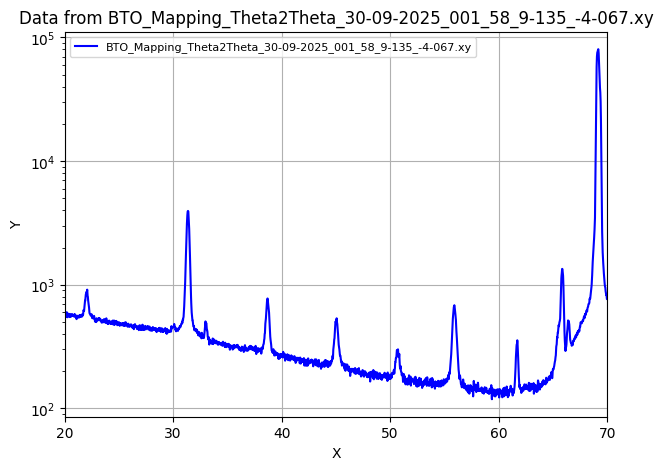

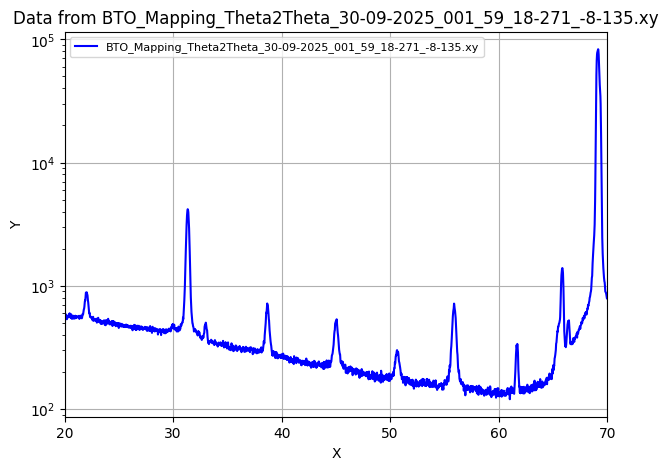

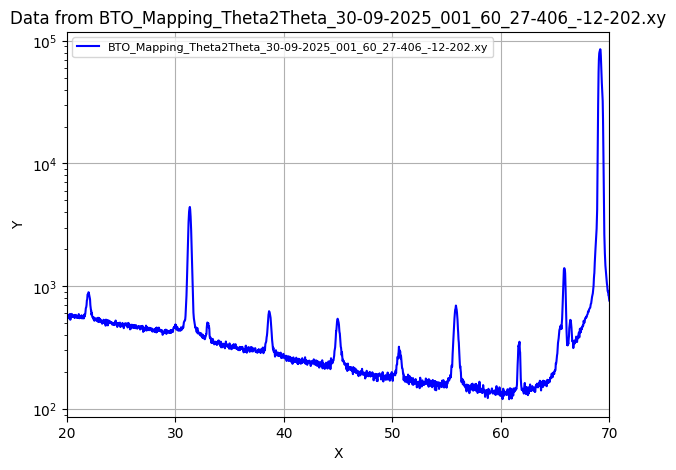

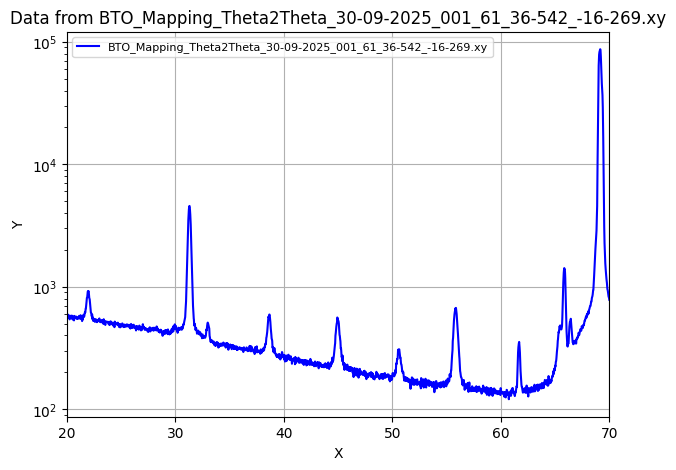

In [11]:
# Loop over each file and make a separate graph
for f in files:
    df = pd.read_csv(f, delim_whitespace=True, header=None, names=["X", "Y"])
    
    plt.figure(figsize=(7,5))
    plt.plot(df["X"], df["Y"], label=f, color="blue")
    plt.title(f"Data from {f}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend(fontsize=8)
    plt.xlim(20,70)
    # plt.ylim(0,100000)
    plt.yscale('log')
    plt.grid()
    plt.show()

## Stacked Plot

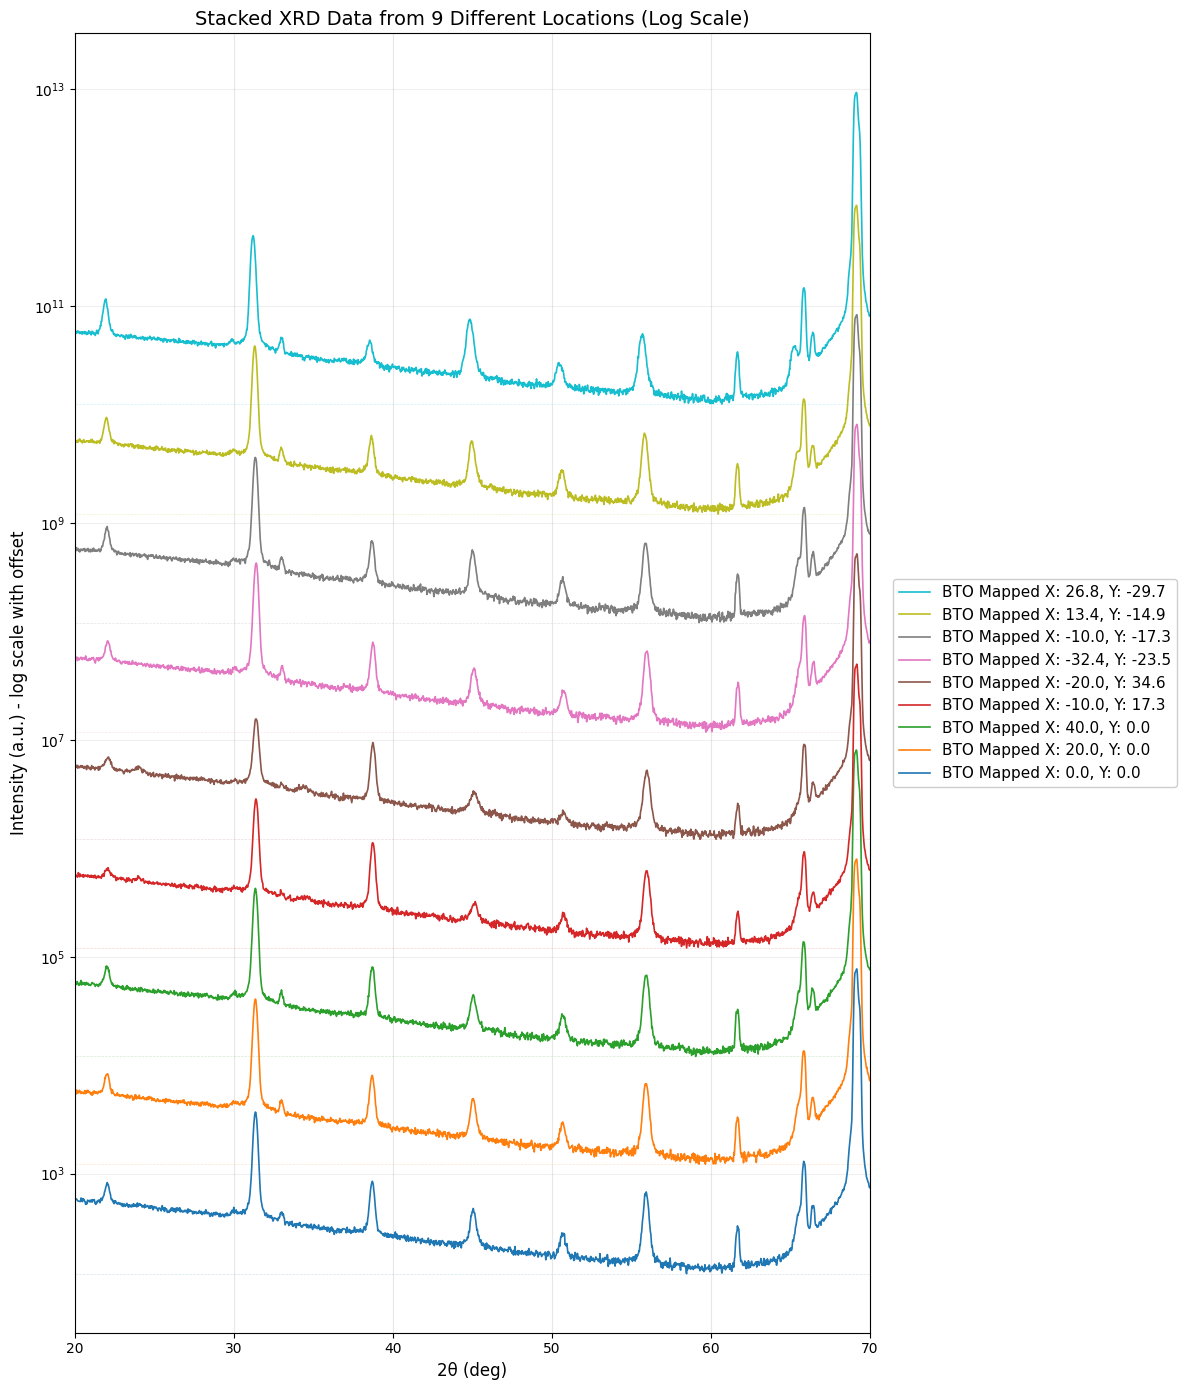

In [12]:
files_to_plot = [files[0], files[2], files[4], files[22], files[24], files[40], files[42], files[54], files[56]]

# Helper function to extract X and Y coordinates from filename
def extract_xy_from_filename(filename):
    """Extract X and Y coordinates from filename like 'something_X-value_Y-value.xy'"""
    name = os.path.basename(filename).rsplit('.', 1)[0]
    parts = name.split('_')
    try:
        x_str, y_str = parts[-2], parts[-1]
        # convert dash-separated decimals to proper floats
        def tok_to_float(t):
            if '-' in t[1:]:
                t = ('-' + t[1:].replace('-', '.', 1)) if t.startswith('-') else t.replace('-', '.', 1)
            return float(t)
        x_val, y_val = tok_to_float(x_str), tok_to_float(y_str)
        return x_val, y_val
    except Exception:
        return None, None

# Create ONE figure for all plots
fig, ax = plt.subplots(figsize=(12, 14))

# Define a colormap
colors = plt.cm.tab10(np.linspace(0, 1, len(files_to_plot)))

# Load data and prepare labels
data_list = []
label_list = []

for f in files_to_plot:
    df = pd.read_csv(f, delim_whitespace=True, header=None, names=["X", "Y"])
    data_list.append(df)
    
    # Extract coordinates and create label
    x_coord, y_coord = extract_xy_from_filename(f)
    if x_coord is not None and y_coord is not None:
        label = f"BTO Mapped X: {x_coord:.1f}, Y: {y_coord:.1f}"
    else:
        label = os.path.basename(f)
    label_list.append(label)

# Use logarithmic offset: multiply each curve by 10^idx
# This creates even spacing on a log scale
log_offset_factor = 10  # Each curve is shifted by factor of 10

# Store handles and labels for reverse ordering
handles = []
labels_for_legend = []

# Plot with logarithmic offsets
for idx, (df, label) in enumerate(zip(data_list, label_list)):
    # Multiply by 10^idx to create logarithmic offset
    offset_multiplier = log_offset_factor ** idx
    
    line, = ax.plot(df["X"], df["Y"] * offset_multiplier,
                    color=colors[idx], linewidth=1.2)
    
    handles.append(line)
    labels_for_legend.append(label)
    
    # Optional: Add horizontal gridline at baseline of each curve
    # Find the minimum value for this curve to draw baseline
    baseline = df["Y"].min() * offset_multiplier
    ax.axhline(y=baseline, color=colors[idx], linestyle='--',
               alpha=0.2, linewidth=0.5)

# Set logarithmic scale for Y-axis
ax.set_yscale('log')

# Reverse the order for legend (top curve appears at top of legend)
handles_reversed = handles[::-1]
labels_reversed = labels_for_legend[::-1]

# Add legend outside the plot on the right, with larger font
ax.legend(handles_reversed, labels_reversed, 
          loc='center left', fontsize=11, framealpha=0.95,
          bbox_to_anchor=(1.02, 0.5))

# Add labels and formatting
ax.set_title("Stacked XRD Data from 9 Different Locations (Log Scale)", fontsize=14)
ax.set_xlabel("2θ (deg)", fontsize=12)
ax.set_ylabel("Intensity (a.u.) - log scale with offset", fontsize=12)
ax.set_xlim(20, 70)
ax.grid(True, alpha=0.3, axis='x')  # Only vertical gridlines
ax.grid(True, alpha=0.2, axis='y', which='both')  # Add horizontal log grid
plt.tight_layout()
plt.show()

## Plots with smoothing, peak finding and various calculations


BTO_Mapping_Theta2Theta_30-09-2025_001_01_0-000_0-000.xy  peaks: 6
  (100)    [R1]   22.050°   I≈814.6   FWHM≈1.1210°   Area≈136.91
  (110)    [R2]   31.370°   I≈3680.8   FWHM≈1.7841°   Area≈1169.32
  (111)    [R3]   38.730°   I≈843.7   FWHM≈1.4478°   Area≈224.16
  (200)    [R4]   45.070°   I≈462.6   FWHM≈2.1301°   Area≈139.24
  (210)    [R5]   50.770°   I≈280.7   FWHM≈1.7390°   Area≈57.95
  (112)    [R6]   55.960°   I≈658.6   FWHM≈1.7478°   Area≈231.85


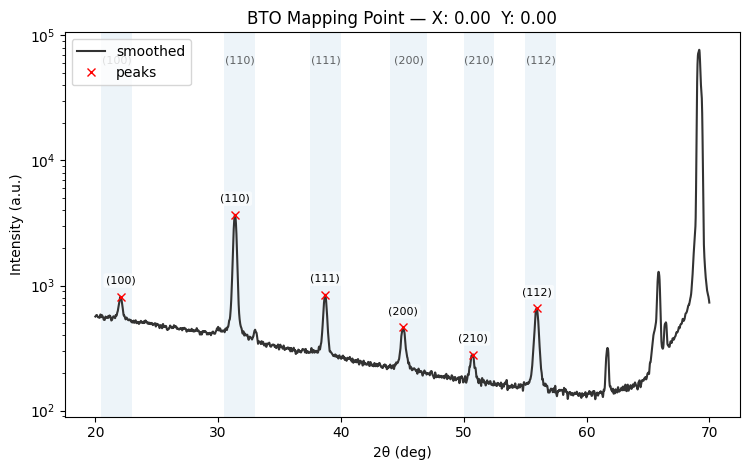


BTO_Mapping_Theta2Theta_30-09-2025_001_02_10-000_0-000.xy  peaks: 6
  (100)    [R1]   22.040°   I≈864.5   FWHM≈1.1144°   Area≈122.19
  (110)    [R2]   31.360°   I≈3844.4   FWHM≈1.7868°   Area≈1210.98
  (111)    [R3]   38.710°   I≈812.8   FWHM≈1.4590°   Area≈214.00
  (200)    [R4]   45.060°   I≈496.2   FWHM≈2.1197°   Area≈147.90
  (210)    [R5]   50.720°   I≈295.7   FWHM≈1.8346°   Area≈63.45
  (112)    [R6]   55.920°   I≈674.2   FWHM≈1.7657°   Area≈248.42


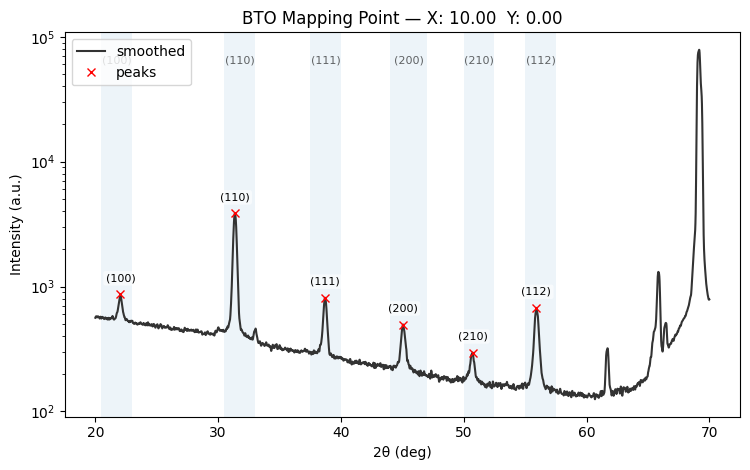


BTO_Mapping_Theta2Theta_30-09-2025_001_03_20-000_0-000.xy  peaks: 6
  (100)    [R1]   22.060°   I≈831.9   FWHM≈1.1378°   Area≈131.63
  (110)    [R2]   31.370°   I≈4053.6   FWHM≈1.7873°   Area≈1269.06
  (111)    [R3]   38.710°   I≈801.5   FWHM≈1.4581°   Area≈233.07
  (200)    [R4]   45.050°   I≈487.2   FWHM≈2.1249°   Area≈146.10
  (210)    [R5]   50.710°   I≈292.0   FWHM≈1.8648°   Area≈62.64
  (112)    [R6]   55.940°   I≈670.2   FWHM≈1.7728°   Area≈260.74


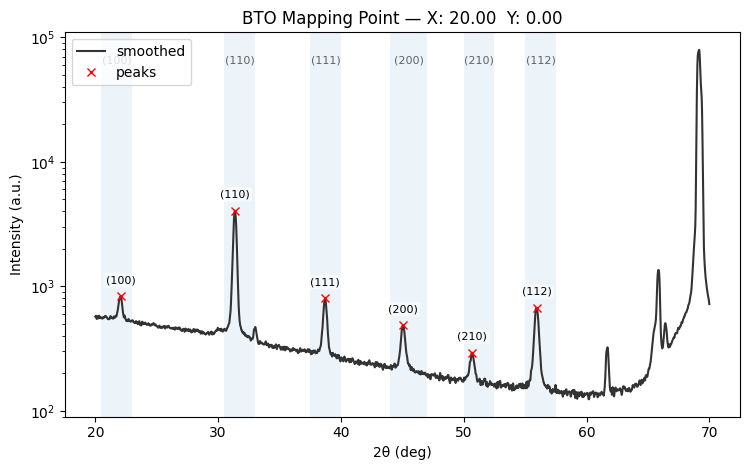


BTO_Mapping_Theta2Theta_30-09-2025_001_04_30-000_0-000.xy  peaks: 6
  (100)    [R1]   22.040°   I≈830.9   FWHM≈1.1376°   Area≈166.32
  (110)    [R2]   31.360°   I≈4132.1   FWHM≈1.7896°   Area≈1319.48
  (111)    [R3]   38.720°   I≈813.1   FWHM≈1.4541°   Area≈227.66
  (200)    [R4]   45.050°   I≈476.7   FWHM≈2.1278°   Area≈149.51
  (210)    [R5]   50.660°   I≈294.8   FWHM≈1.8290°   Area≈67.21
  (112)    [R6]   55.910°   I≈675.9   FWHM≈1.7746°   Area≈254.63


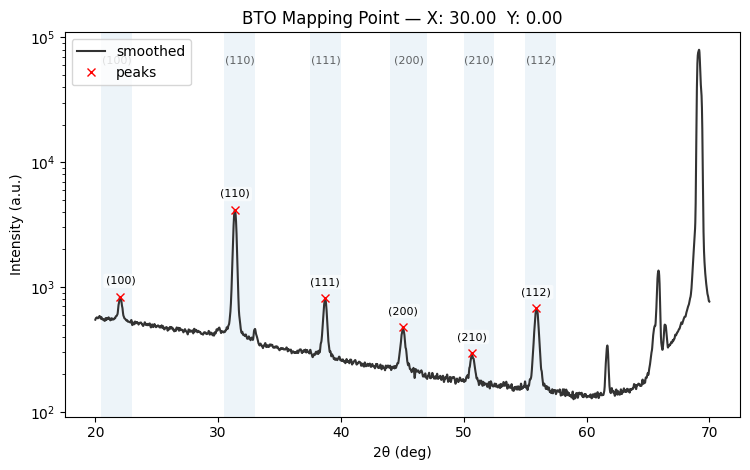


BTO_Mapping_Theta2Theta_30-09-2025_001_05_40-000_0-000.xy  peaks: 6
  (100)    [R1]   22.070°   I≈805.4   FWHM≈1.1309°   Area≈119.36
  (110)    [R2]   31.370°   I≈4233.9   FWHM≈1.7878°   Area≈1349.20
  (111)    [R3]   38.730°   I≈799.0   FWHM≈1.4555°   Area≈237.61
  (200)    [R4]   45.080°   I≈444.4   FWHM≈2.1294°   Area≈127.37
  (210)    [R5]   50.660°   I≈293.5   FWHM≈1.8664°   Area≈61.65
  (112)    [R6]   55.960°   I≈674.4   FWHM≈1.7698°   Area≈262.26


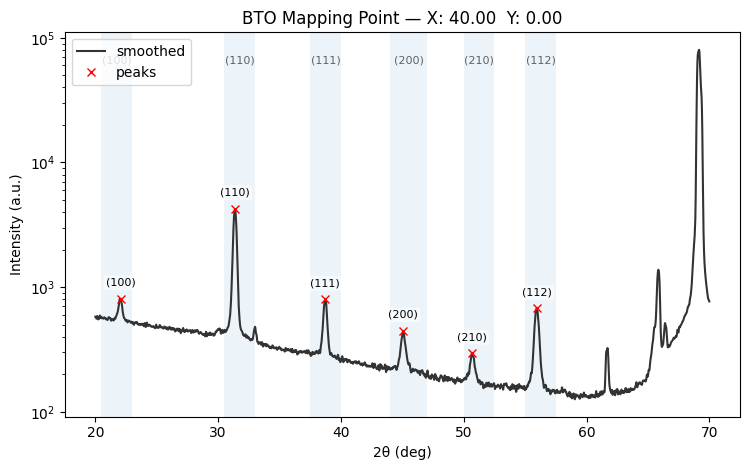


BTO_Mapping_Theta2Theta_30-09-2025_001_06_9-135_4-067.xy  peaks: 6
  (100)    [R1]   22.040°   I≈816.6   FWHM≈1.1316°   Area≈112.28
  (110)    [R2]   31.360°   I≈3728.8   FWHM≈1.7787°   Area≈1161.11
  (111)    [R3]   38.730°   I≈861.4   FWHM≈1.4439°   Area≈231.78
  (200)    [R4]   45.060°   I≈449.3   FWHM≈2.0967°   Area≈123.74
  (210)    [R5]   50.690°   I≈278.1   FWHM≈1.7331°   Area≈59.12
  (112)    [R6]   55.940°   I≈653.9   FWHM≈1.7580°   Area≈240.85


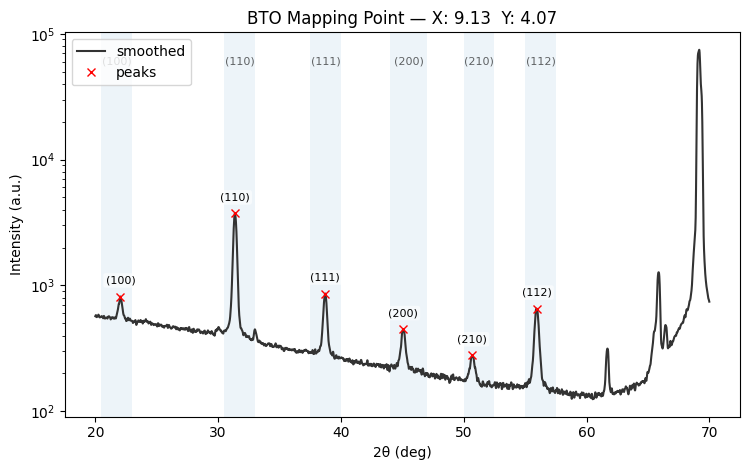


BTO_Mapping_Theta2Theta_30-09-2025_001_07_18-271_8-135.xy  peaks: 6
  (100)    [R1]   22.090°   I≈760.7   FWHM≈1.1330°   Area≈100.13
  (110)    [R2]   31.380°   I≈3689.2   FWHM≈1.7799°   Area≈1172.76
  (111)    [R3]   38.710°   I≈905.6   FWHM≈1.4381°   Area≈256.23
  (200)    [R4]   45.070°   I≈417.1   FWHM≈2.1072°   Area≈106.95
  (210)    [R5]   50.700°   I≈280.7   FWHM≈1.7323°   Area≈63.11
  (112)    [R6]   55.920°   I≈664.3   FWHM≈1.7456°   Area≈247.53


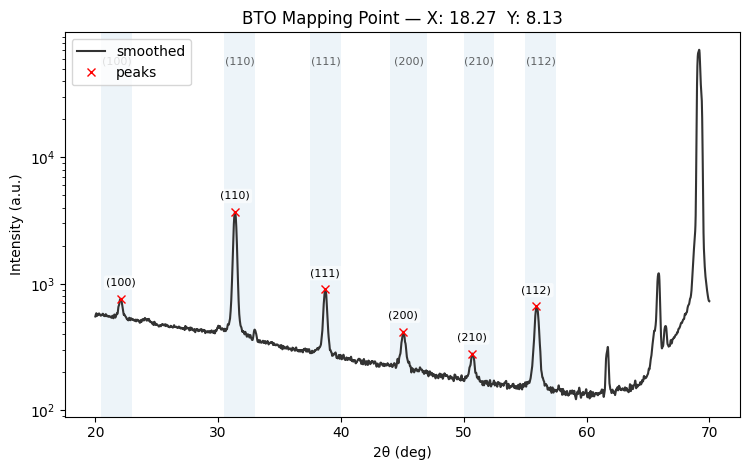


BTO_Mapping_Theta2Theta_30-09-2025_001_08_27-406_12-202.xy  peaks: 6
  (100)    [R1]   22.050°   I≈711.6   FWHM≈1.1318°   Area≈88.79
  (110)    [R2]   31.390°   I≈3618.5   FWHM≈1.7750°   Area≈1141.72
  (111)    [R3]   38.740°   I≈952.0   FWHM≈1.4319°   Area≈265.79
  (200)    [R4]   45.130°   I≈375.4   FWHM≈2.0642°   Area≈110.47
  (210)    [R5]   50.720°   I≈276.6   FWHM≈1.7098°   Area≈53.30
  (112)    [R6]   55.960°   I≈642.9   FWHM≈1.7456°   Area≈246.35


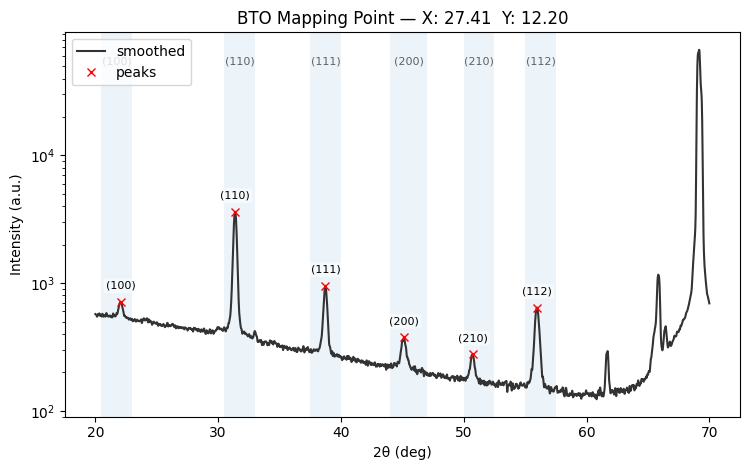


BTO_Mapping_Theta2Theta_30-09-2025_001_09_36-542_16-269.xy  peaks: 6
  (100)    [R1]   22.100°   I≈696.9   FWHM≈1.0866°   Area≈81.56
  (110)    [R2]   31.390°   I≈3507.8   FWHM≈1.7665°   Area≈1117.34
  (111)    [R3]   38.720°   I≈925.7   FWHM≈1.4222°   Area≈265.51
  (200)    [R4]   45.130°   I≈330.9   FWHM≈1.8226°   Area≈80.84
  (210)    [R5]   50.670°   I≈266.9   FWHM≈1.6759°   Area≈55.22
  (112)    [R6]   56.010°   I≈639.4   FWHM≈1.7355°   Area≈249.24


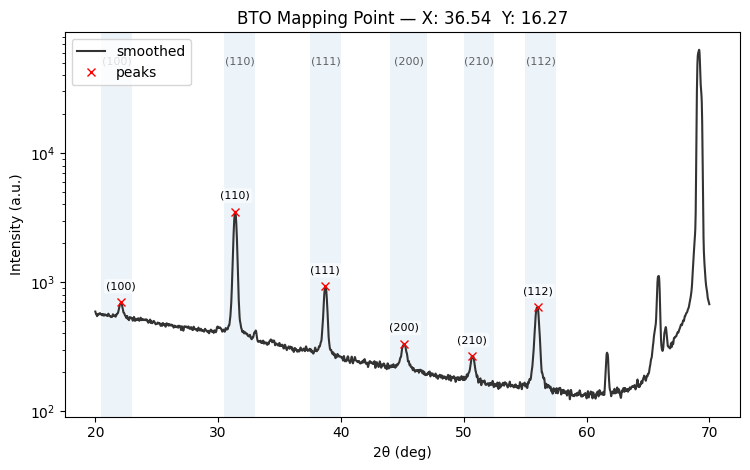


BTO_Mapping_Theta2Theta_30-09-2025_001_10_6-691_7-431.xy  peaks: 6
  (100)    [R1]   22.050°   I≈771.5   FWHM≈1.1032°   Area≈102.88
  (110)    [R2]   31.380°   I≈3605.3   FWHM≈1.7734°   Area≈1118.03
  (111)    [R3]   38.710°   I≈902.3   FWHM≈1.4380°   Area≈257.85
  (200)    [R4]   45.090°   I≈414.1   FWHM≈2.0937°   Area≈119.17
  (210)    [R5]   50.680°   I≈280.0   FWHM≈1.7632°   Area≈58.59
  (112)    [R6]   55.940°   I≈658.3   FWHM≈1.7405°   Area≈240.05


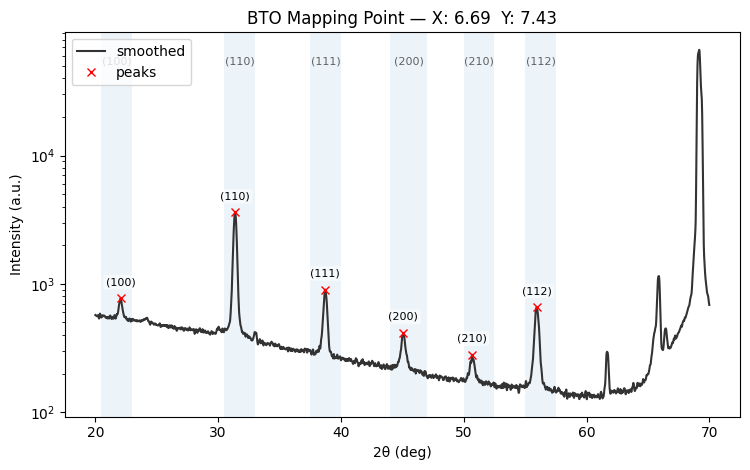


BTO_Mapping_Theta2Theta_30-09-2025_001_11_13-383_14-863.xy  peaks: 6
  (100)    [R1]   22.040°   I≈688.6   FWHM≈1.0927°   Area≈75.33
  (110)    [R2]   31.390°   I≈3384.0   FWHM≈1.7692°   Area≈1066.55
  (111)    [R3]   38.740°   I≈990.4   FWHM≈1.4236°   Area≈286.56
  (200)    [R4]   45.160°   I≈353.8   FWHM≈1.9104°   Area≈96.57
  (210)    [R5]   50.700°   I≈260.5   FWHM≈1.6453°   Area≈63.16
  (112)    [R6]   55.950°   I≈654.5   FWHM≈1.7338°   Area≈247.60


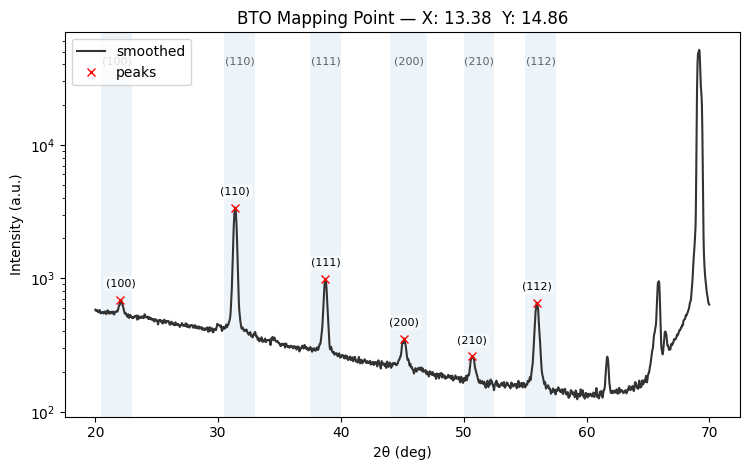


BTO_Mapping_Theta2Theta_30-09-2025_001_12_20-074_22-294.xy  peaks: 6
  (100)    [R1]   22.070°   I≈659.8   FWHM≈1.1257°   Area≈71.52
  (110)    [R2]   31.390°   I≈3059.5   FWHM≈1.7679°   Area≈964.83
  (111)    [R3]   38.770°   I≈1073.2   FWHM≈1.4173°   Area≈318.99
  (200)    [R4]   45.120°   I≈318.1   FWHM≈1.7486°   Area≈89.04
  (210)    [R5]   50.740°   I≈262.1   FWHM≈1.6173°   Area≈49.96
  (112)    [R6]   55.980°   I≈635.3   FWHM≈1.7311°   Area≈235.84


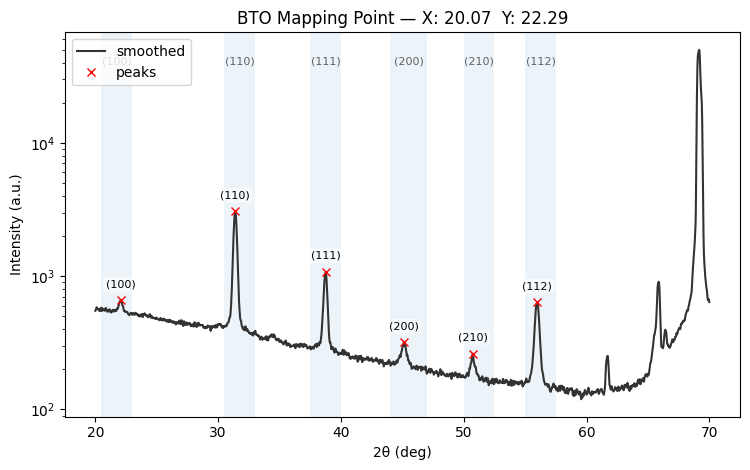


BTO_Mapping_Theta2Theta_30-09-2025_001_13_26-765_29-726.xy  peaks: 6
  (100)    [R1]   22.110°   I≈641.7   FWHM≈1.0936°   Area≈55.73
  (110)    [R2]   31.390°   I≈2559.2   FWHM≈1.7662°   Area≈804.12
  (111)    [R3]   38.760°   I≈1079.1   FWHM≈1.4096°   Area≈299.88
  (200)    [R4]   45.230°   I≈302.6   FWHM≈1.6854°   Area≈89.42
  (210)    [R5]   50.720°   I≈231.5   FWHM≈1.5229°   Area≈39.33
  (112)    [R6]   55.970°   I≈616.7   FWHM≈1.7305°   Area≈238.73


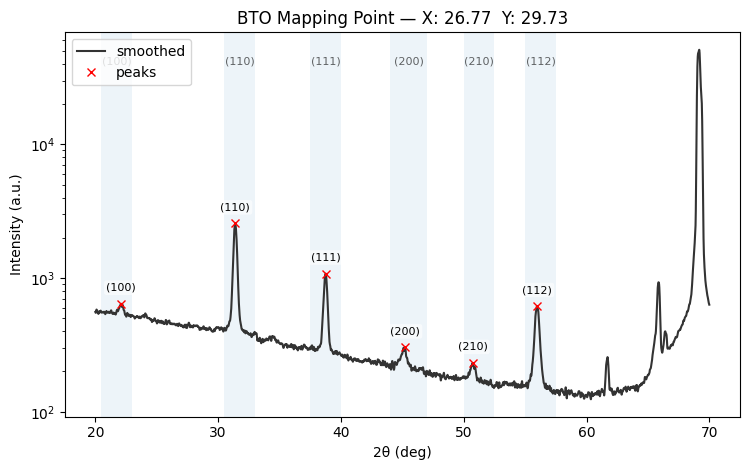


BTO_Mapping_Theta2Theta_30-09-2025_001_14_3-090_9-511.xy  peaks: 6
  (100)    [R1]   22.100°   I≈704.5   FWHM≈1.1442°   Area≈98.82
  (110)    [R2]   31.380°   I≈3468.8   FWHM≈1.7701°   Area≈1076.89
  (111)    [R3]   38.730°   I≈941.6   FWHM≈1.4240°   Area≈260.51
  (200)    [R4]   45.130°   I≈382.8   FWHM≈2.0966°   Area≈116.99
  (210)    [R5]   50.730°   I≈270.2   FWHM≈1.7030°   Area≈60.46
  (112)    [R6]   55.960°   I≈642.3   FWHM≈1.7441°   Area≈238.08


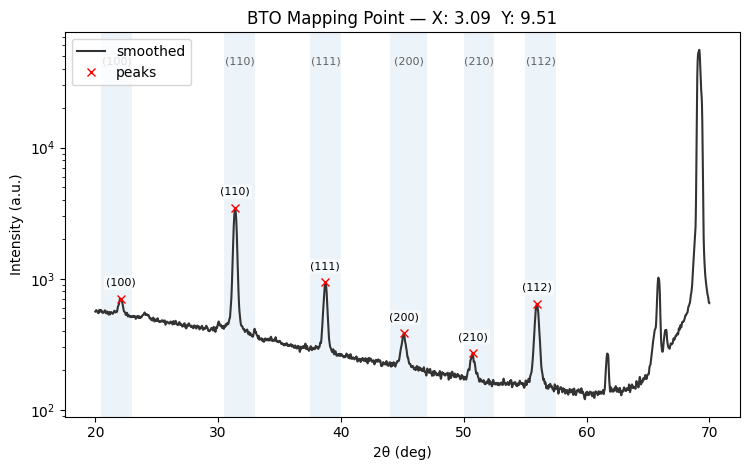


BTO_Mapping_Theta2Theta_30-09-2025_001_15_6-180_19-021.xy  peaks: 6
  (100)    [R1]   22.140°   I≈661.3   FWHM≈1.0791°   Area≈67.66
  (110)    [R2]   31.390°   I≈3047.6   FWHM≈1.7641°   Area≈960.74
  (111)    [R3]   38.760°   I≈1065.1   FWHM≈1.4202°   Area≈298.03
  (200)    [R4]   45.140°   I≈322.5   FWHM≈1.7984°   Area≈77.07
  (210)    [R5]   50.730°   I≈253.9   FWHM≈1.5690°   Area≈52.04
  (112)    [R6]   55.960°   I≈642.7   FWHM≈1.7277°   Area≈236.29


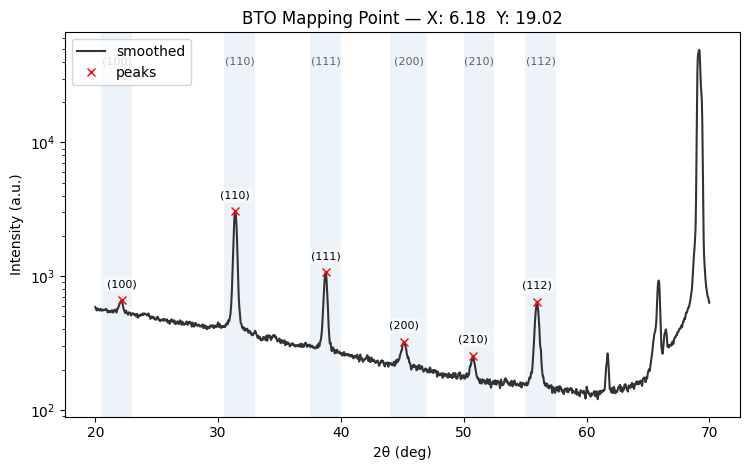


BTO_Mapping_Theta2Theta_30-09-2025_001_16_9-271_28-532.xy  peaks: 6
  (100)    [R1]   22.110°   I≈653.9   FWHM≈1.1213°   Area≈68.09
  (110)    [R2]   31.390°   I≈2365.7   FWHM≈1.7669°   Area≈732.22
  (111)    [R3]   38.740°   I≈1188.7   FWHM≈1.4116°   Area≈351.22
  (200)    [R4]   45.120°   I≈307.0   FWHM≈1.6733°   Area≈71.93
  (210)    [R5]   50.610°   I≈220.8   FWHM≈1.4319°   Area≈40.96
  (112)    [R6]   55.960°   I≈609.1   FWHM≈1.7391°   Area≈236.51


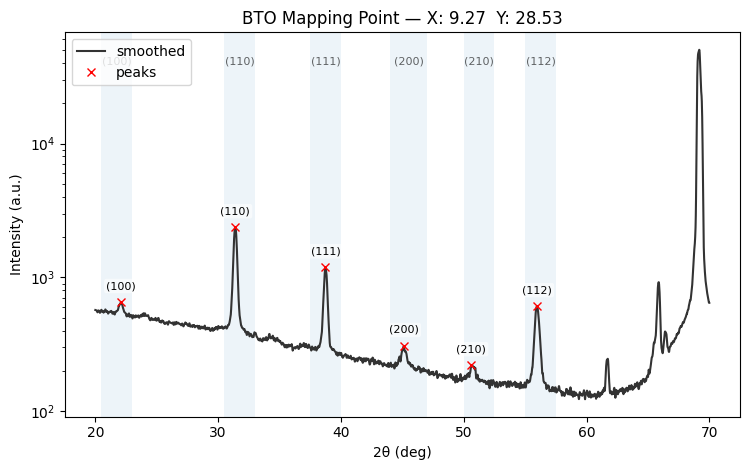


BTO_Mapping_Theta2Theta_30-09-2025_001_17_12-361_38-042.xy  peaks: 6
  (100)    [R1]   22.070°   I≈686.5   FWHM≈1.1370°   Area≈95.31
  (110)    [R2]   31.400°   I≈1801.5   FWHM≈1.7754°   Area≈579.15
  (111)    [R3]   38.740°   I≈975.5   FWHM≈1.4155°   Area≈285.46
  (200)    [R4]   45.080°   I≈344.1   FWHM≈1.8595°   Area≈102.83
  (210)    [R5]   50.670°   I≈223.4   FWHM≈1.4384°   Area≈49.23
  (112)    [R6]   55.980°   I≈574.4   FWHM≈1.7408°   Area≈213.21


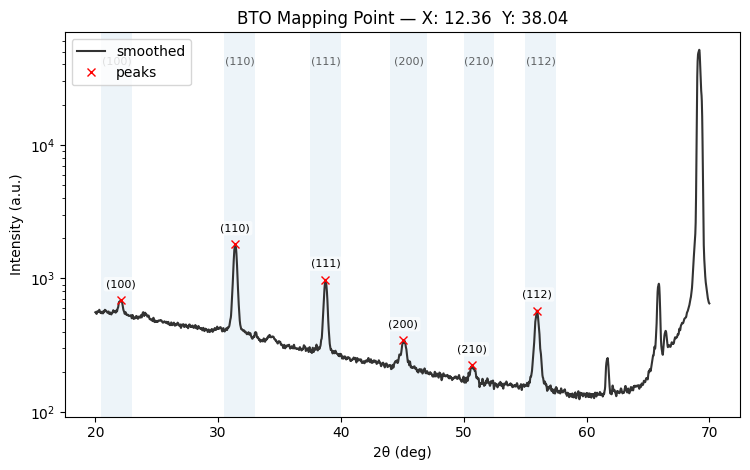


BTO_Mapping_Theta2Theta_30-09-2025_001_18_-1-045_9-945.xy  peaks: 6
  (100)    [R1]   22.070°   I≈717.6   FWHM≈1.0962°   Area≈97.37
  (110)    [R2]   31.390°   I≈3405.7   FWHM≈1.7661°   Area≈1077.28
  (111)    [R3]   38.750°   I≈960.8   FWHM≈1.4247°   Area≈263.15
  (200)    [R4]   45.120°   I≈370.2   FWHM≈2.0169°   Area≈97.23
  (210)    [R5]   50.760°   I≈262.7   FWHM≈1.6743°   Area≈54.56
  (112)    [R6]   55.960°   I≈650.7   FWHM≈1.7323°   Area≈240.23


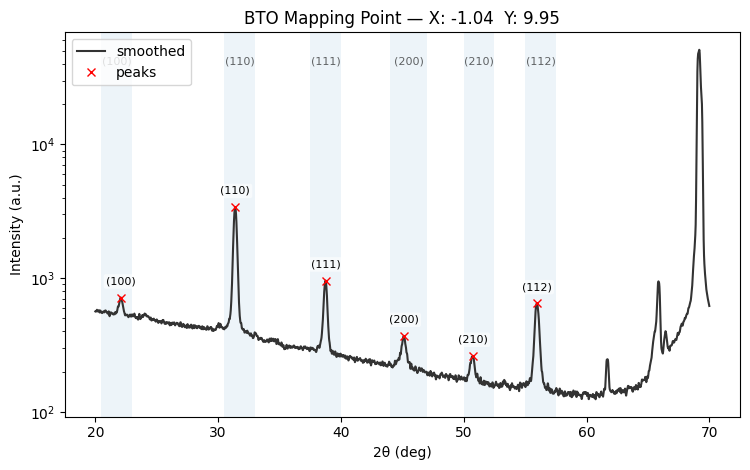


BTO_Mapping_Theta2Theta_30-09-2025_001_19_-2-091_19-890.xy  peaks: 6
  (100)    [R1]   22.090°   I≈667.2   FWHM≈1.0587°   Area≈76.71
  (110)    [R2]   31.390°   I≈2819.2   FWHM≈1.7623°   Area≈904.07
  (111)    [R3]   38.750°   I≈1138.6   FWHM≈1.4135°   Area≈336.02
  (200)    [R4]   45.140°   I≈317.4   FWHM≈1.7543°   Area≈68.74
  (210)    [R5]   50.670°   I≈245.3   FWHM≈1.5604°   Area≈51.73
  (112)    [R6]   55.960°   I≈625.3   FWHM≈1.7255°   Area≈238.20


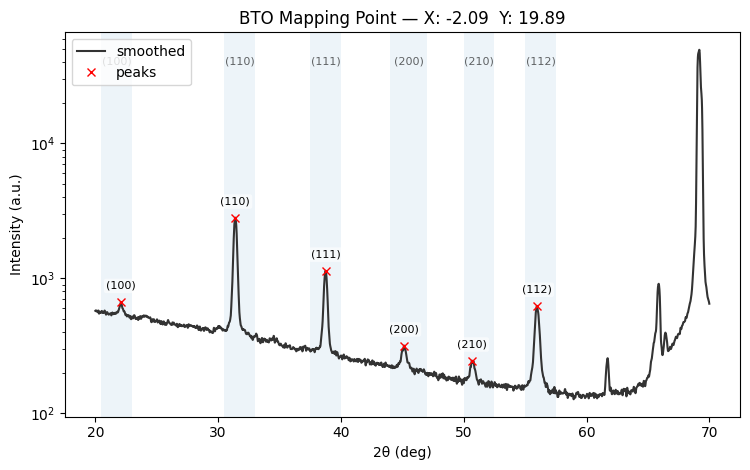


BTO_Mapping_Theta2Theta_30-09-2025_001_20_-3-136_29-836.xy  peaks: 6
  (100)    [R1]   22.000°   I≈664.2   FWHM≈1.1121°   Area≈72.71
  (110)    [R2]   31.400°   I≈2027.1   FWHM≈1.7659°   Area≈631.51
  (111)    [R3]   38.770°   I≈1147.1   FWHM≈1.4145°   Area≈346.47
  (200)    [R4]   45.080°   I≈320.0   FWHM≈1.7819°   Area≈78.62
  (210)    [R5]   50.810°   I≈222.4   FWHM≈1.4754°   Area≈35.81
  (112)    [R6]   55.970°   I≈590.4   FWHM≈1.7332°   Area≈227.11


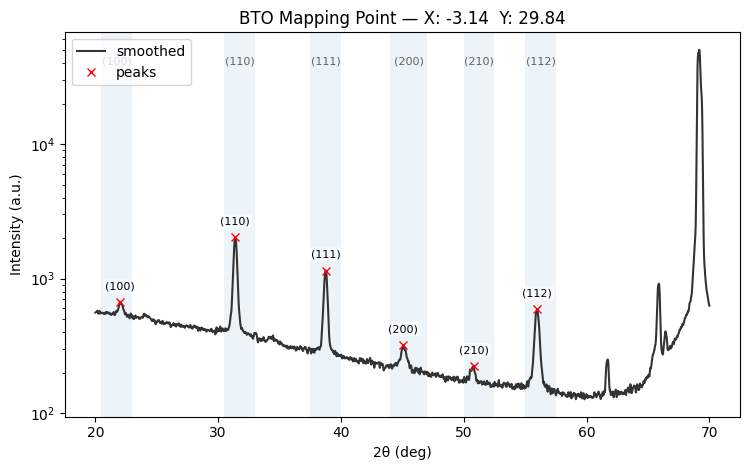


BTO_Mapping_Theta2Theta_30-09-2025_001_21_-4-181_39-781.xy  peaks: 6
  (100)    [R1]   22.100°   I≈686.0   FWHM≈1.1296°   Area≈92.11
  (110)    [R2]   31.380°   I≈1571.7   FWHM≈1.7702°   Area≈493.15
  (111)    [R3]   38.740°   I≈933.0   FWHM≈1.4205°   Area≈269.75
  (200)    [R4]   45.110°   I≈336.3   FWHM≈1.8904°   Area≈111.99
  (210)    [R5]   50.730°   I≈210.7   FWHM≈1.3995°   Area≈31.62
  (112)    [R6]   55.970°   I≈525.0   FWHM≈1.7536°   Area≈195.97


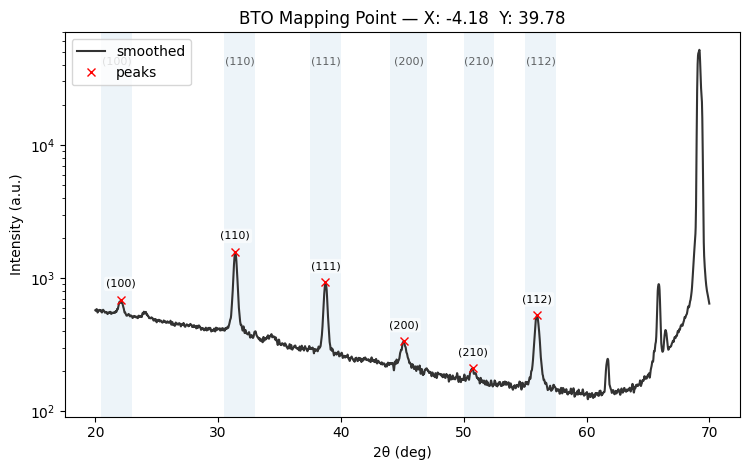


BTO_Mapping_Theta2Theta_30-09-2025_001_22_-5-000_8-660.xy  peaks: 6
  (100)    [R1]   22.030°   I≈697.9   FWHM≈1.1161°   Area≈87.97
  (110)    [R2]   31.380°   I≈3410.9   FWHM≈1.7629°   Area≈1061.35
  (111)    [R3]   38.730°   I≈933.8   FWHM≈1.4231°   Area≈277.00
  (200)    [R4]   45.070°   I≈369.7   FWHM≈2.0019°   Area≈100.56
  (210)    [R5]   50.690°   I≈259.1   FWHM≈1.6404°   Area≈48.30
  (112)    [R6]   55.990°   I≈635.4   FWHM≈1.7456°   Area≈244.45


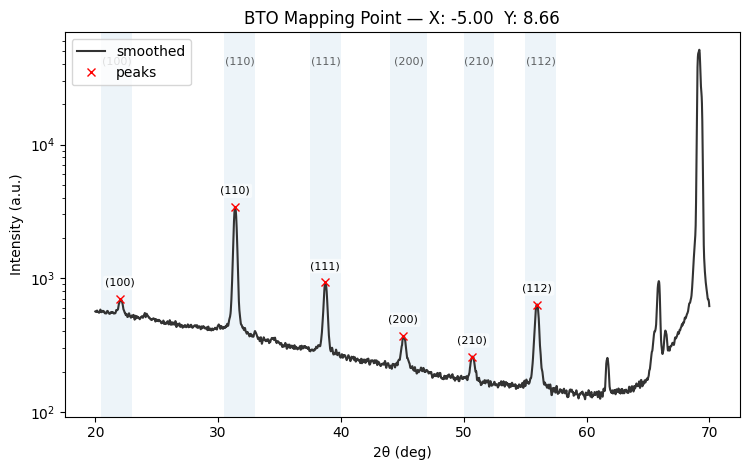


BTO_Mapping_Theta2Theta_30-09-2025_001_23_-10-000_17-321.xy  peaks: 6
  (100)    [R1]   22.020°   I≈646.8   FWHM≈1.1272°   Area≈70.83
  (110)    [R2]   31.400°   I≈2839.4   FWHM≈1.7549°   Area≈898.93
  (111)    [R3]   38.740°   I≈1126.0   FWHM≈1.4134°   Area≈349.28
  (200)    [R4]   45.200°   I≈317.1   FWHM≈1.7281°   Area≈76.51
  (210)    [R5]   50.700°   I≈250.5   FWHM≈1.5448°   Area≈48.85
  (112)    [R6]   55.980°   I≈620.1   FWHM≈1.7342°   Area≈237.24


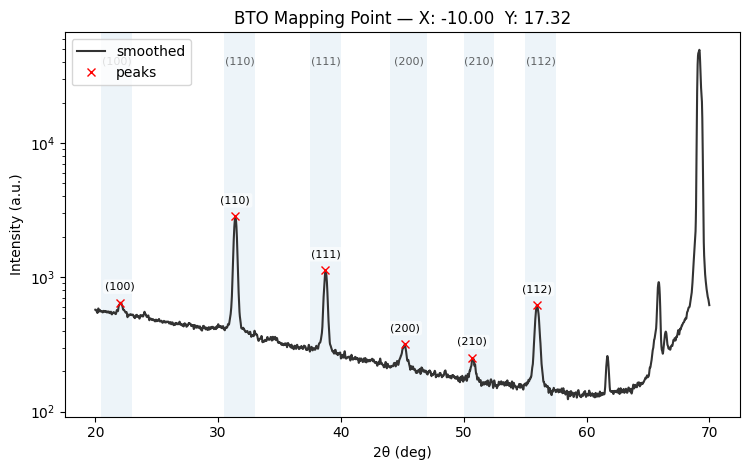


BTO_Mapping_Theta2Theta_30-09-2025_001_24_-15-000_25-981.xy  peaks: 6
  (100)    [R1]   22.080°   I≈668.8   FWHM≈1.0877°   Area≈83.85
  (110)    [R2]   31.410°   I≈2029.1   FWHM≈1.7652°   Area≈632.97
  (111)    [R3]   38.750°   I≈1145.1   FWHM≈1.4057°   Area≈332.23
  (200)    [R4]   45.100°   I≈316.7   FWHM≈1.8249°   Area≈80.61
  (210)    [R5]   50.760°   I≈222.6   FWHM≈1.4613°   Area≈41.67
  (112)    [R6]   55.970°   I≈592.4   FWHM≈1.7243°   Area≈220.15


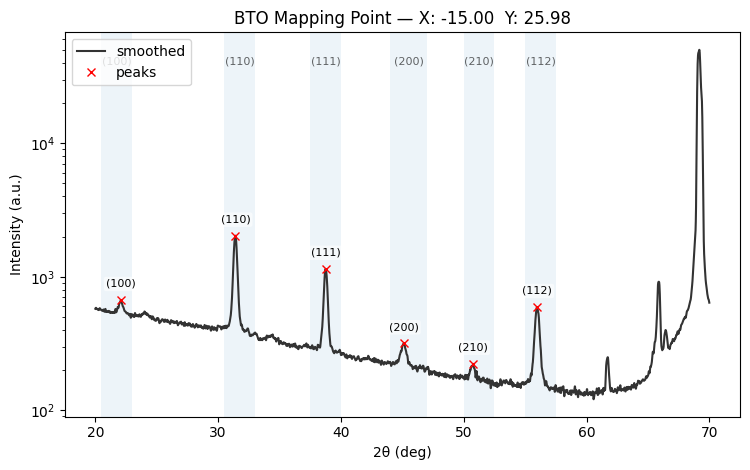


BTO_Mapping_Theta2Theta_30-09-2025_001_25_-20-000_34-641.xy  peaks: 6
  (100)    [R1]   22.120°   I≈692.2   FWHM≈1.1100°   Area≈89.47
  (110)    [R2]   31.400°   I≈1560.9   FWHM≈1.7624°   Area≈492.49
  (111)    [R3]   38.760°   I≈934.9   FWHM≈1.4049°   Area≈247.00
  (200)    [R4]   45.160°   I≈330.2   FWHM≈1.8930°   Area≈98.50
  (210)    [R5]   50.710°   I≈217.3   FWHM≈1.3918°   Area≈27.71
  (112)    [R6]   55.980°   I≈524.3   FWHM≈1.7379°   Area≈188.21


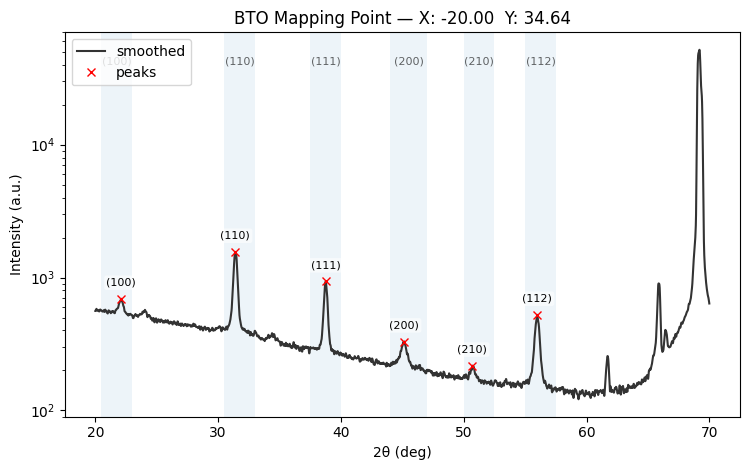


BTO_Mapping_Theta2Theta_30-09-2025_001_26_-8-090_5-878.xy  peaks: 6
  (100)    [R1]   22.120°   I≈732.9   FWHM≈1.0879°   Area≈99.18
  (110)    [R2]   31.390°   I≈3435.3   FWHM≈1.7659°   Area≈1092.45
  (111)    [R3]   38.730°   I≈919.8   FWHM≈1.4311°   Area≈261.36
  (200)    [R4]   45.110°   I≈394.6   FWHM≈2.0734°   Area≈102.01
  (210)    [R5]   50.730°   I≈276.2   FWHM≈1.7074°   Area≈55.27
  (112)    [R6]   55.940°   I≈644.0   FWHM≈1.7258°   Area≈240.12


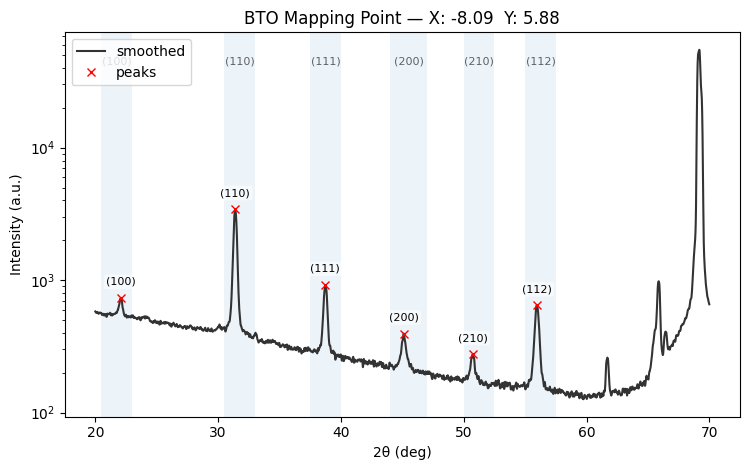


BTO_Mapping_Theta2Theta_30-09-2025_001_27_-16-180_11-756.xy  peaks: 6
  (100)    [R1]   22.100°   I≈671.0   FWHM≈1.0351°   Area≈58.81
  (110)    [R2]   31.410°   I≈3062.4   FWHM≈1.7536°   Area≈958.93
  (111)    [R3]   38.760°   I≈1071.4   FWHM≈1.4045°   Area≈296.11
  (200)    [R4]   45.130°   I≈330.4   FWHM≈1.7765°   Area≈69.77
  (210)    [R5]   50.710°   I≈251.7   FWHM≈1.5601°   Area≈47.83
  (112)    [R6]   56.020°   I≈618.9   FWHM≈1.7264°   Area≈233.18


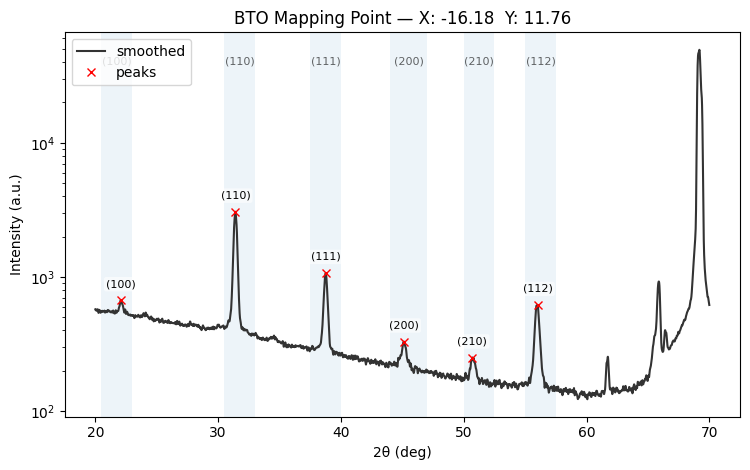


BTO_Mapping_Theta2Theta_30-09-2025_001_28_-24-271_17-634.xy  peaks: 6
  (100)    [R1]   22.150°   I≈644.0   FWHM≈1.0790°   Area≈84.19
  (110)    [R2]   31.420°   I≈2299.4   FWHM≈1.7465°   Area≈713.47
  (111)    [R3]   38.790°   I≈1153.8   FWHM≈1.3912°   Area≈329.51
  (200)    [R4]   45.160°   I≈303.2   FWHM≈1.6909°   Area≈74.25
  (210)    [R5]   50.820°   I≈223.8   FWHM≈1.4349°   Area≈32.04
  (112)    [R6]   55.980°   I≈611.5   FWHM≈1.7184°   Area≈235.42


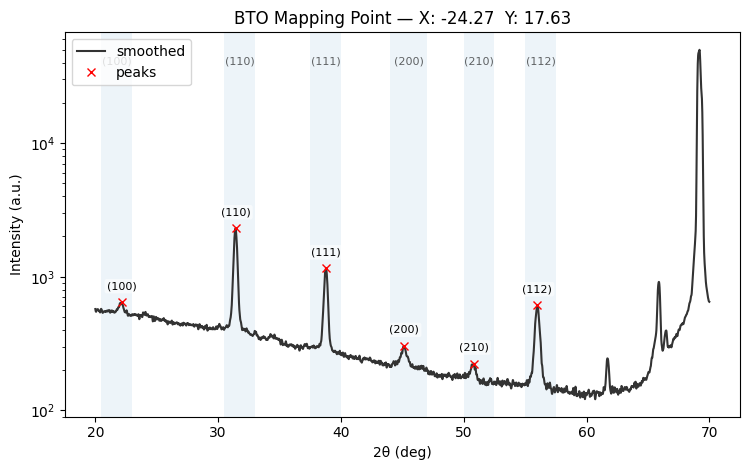


BTO_Mapping_Theta2Theta_30-09-2025_001_29_-32-361_23-511.xy  peaks: 6
  (100)    [R1]   22.100°   I≈693.8   FWHM≈1.1123°   Area≈92.73
  (110)    [R2]   31.410°   I≈1780.9   FWHM≈1.7519°   Area≈548.00
  (111)    [R3]   38.770°   I≈955.0   FWHM≈1.3956°   Area≈270.49
  (200)    [R4]   45.130°   I≈356.1   FWHM≈1.9271°   Area≈97.51
  (210)    [R5]   50.710°   I≈230.2   FWHM≈1.4316°   Area≈41.61
  (112)    [R6]   55.970°   I≈558.2   FWHM≈1.7179°   Area≈214.42


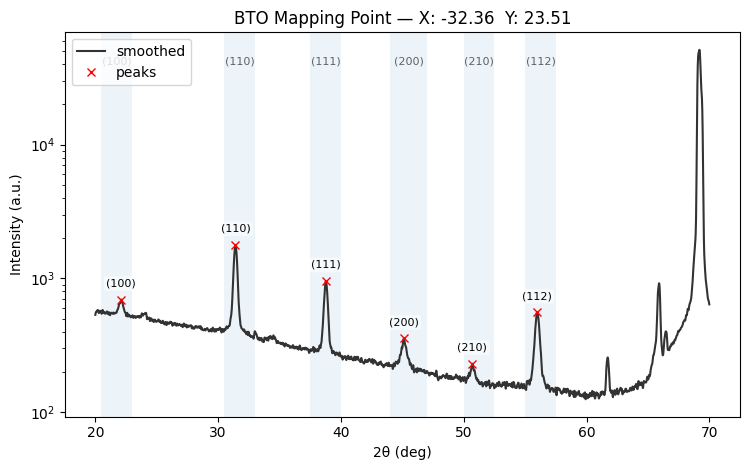


BTO_Mapping_Theta2Theta_30-09-2025_001_30_-9-781_2-079.xy  peaks: 6
  (100)    [R1]   22.070°   I≈755.5   FWHM≈1.0992°   Area≈128.92
  (110)    [R2]   31.390°   I≈3562.7   FWHM≈1.7678°   Area≈1117.86
  (111)    [R3]   38.740°   I≈871.8   FWHM≈1.4389°   Area≈251.81
  (200)    [R4]   45.050°   I≈409.0   FWHM≈2.1011°   Area≈121.06
  (210)    [R5]   50.760°   I≈273.2   FWHM≈1.7040°   Area≈62.60
  (112)    [R6]   55.940°   I≈640.7   FWHM≈1.7448°   Area≈243.07


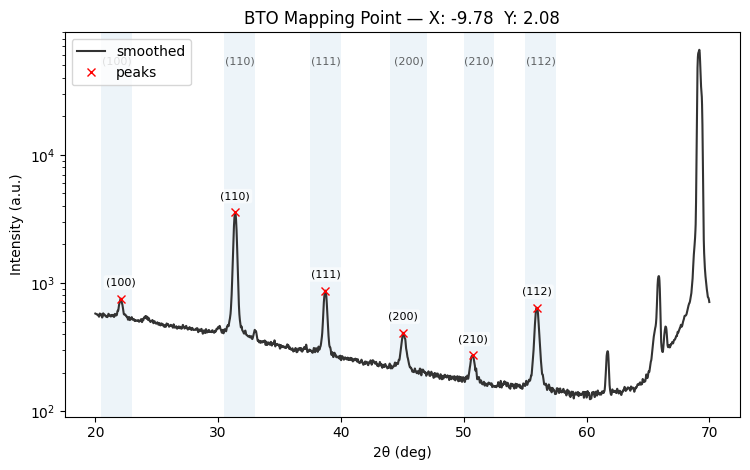


BTO_Mapping_Theta2Theta_30-09-2025_001_31_-19-563_4-158.xy  peaks: 6
  (100)    [R1]   22.090°   I≈704.1   FWHM≈1.0893°   Area≈90.58
  (110)    [R2]   31.410°   I≈3394.9   FWHM≈1.7516°   Area≈1073.07
  (111)    [R3]   38.760°   I≈950.4   FWHM≈1.4083°   Area≈263.27
  (200)    [R4]   45.180°   I≈364.2   FWHM≈1.9370°   Area≈99.40
  (210)    [R5]   50.710°   I≈259.3   FWHM≈1.6211°   Area≈48.56
  (112)    [R6]   56.000°   I≈632.5   FWHM≈1.7221°   Area≈234.15


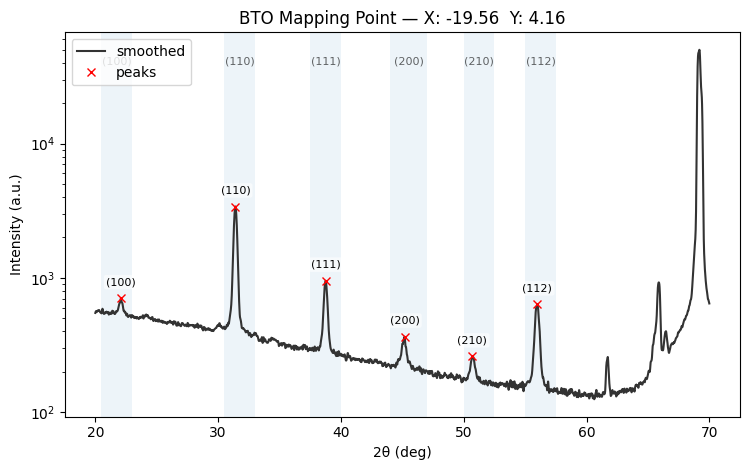


BTO_Mapping_Theta2Theta_30-09-2025_001_32_-29-344_6-237.xy  peaks: 6
  (100)    [R1]   22.190°   I≈651.8   FWHM≈1.1594°   Area≈71.74
  (110)    [R2]   31.410°   I≈2989.7   FWHM≈1.7386°   Area≈947.71
  (111)    [R3]   38.770°   I≈1060.9   FWHM≈1.3985°   Area≈299.65
  (200)    [R4]   45.110°   I≈317.0   FWHM≈1.7611°   Area≈78.48
  (210)    [R5]   50.820°   I≈247.2   FWHM≈1.5595°   Area≈45.94
  (112)    [R6]   55.980°   I≈631.2   FWHM≈1.7149°   Area≈236.17


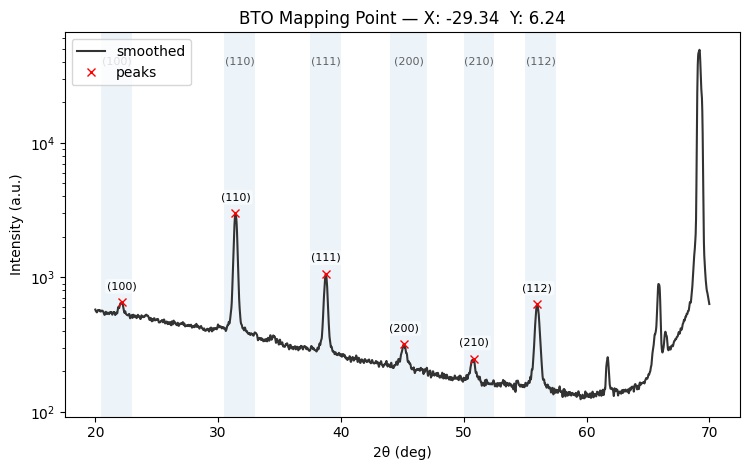


BTO_Mapping_Theta2Theta_30-09-2025_001_33_-39-126_8-316.xy  peaks: 6
  (100)    [R1]   22.090°   I≈648.0   FWHM≈1.0612°   Area≈82.66
  (110)    [R2]   31.430°   I≈2276.5   FWHM≈1.7342°   Area≈695.21
  (111)    [R3]   38.790°   I≈1101.2   FWHM≈1.3852°   Area≈320.72
  (200)    [R4]   45.150°   I≈307.3   FWHM≈1.6858°   Area≈55.95
  (210)    [R5]   50.760°   I≈230.5   FWHM≈1.4656°   Area≈42.57
  (112)    [R6]   56.000°   I≈610.9   FWHM≈1.7060°   Area≈236.02


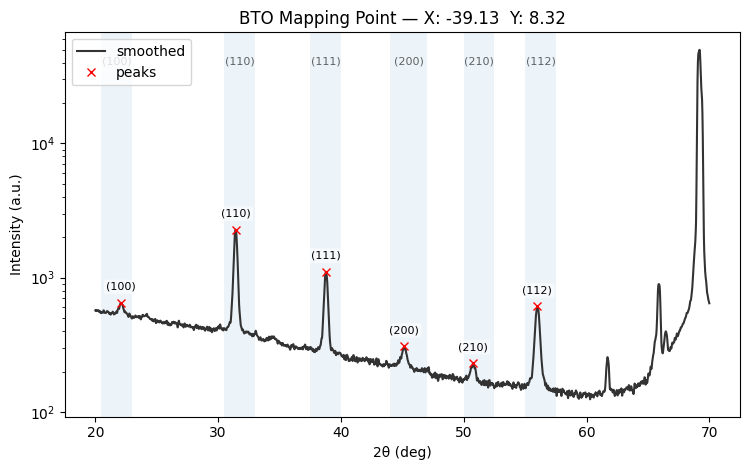


BTO_Mapping_Theta2Theta_30-09-2025_001_34_-9-781_-2-079.xy  peaks: 6
  (100)    [R1]   22.090°   I≈790.7   FWHM≈1.1120°   Area≈119.07
  (110)    [R2]   31.380°   I≈3648.7   FWHM≈1.7711°   Area≈1146.62
  (111)    [R3]   38.730°   I≈852.5   FWHM≈1.4379°   Area≈224.04
  (200)    [R4]   45.090°   I≈457.5   FWHM≈2.1033°   Area≈127.97
  (210)    [R5]   50.680°   I≈277.3   FWHM≈1.7615°   Area≈54.02
  (112)    [R6]   55.950°   I≈644.6   FWHM≈1.7485°   Area≈235.60


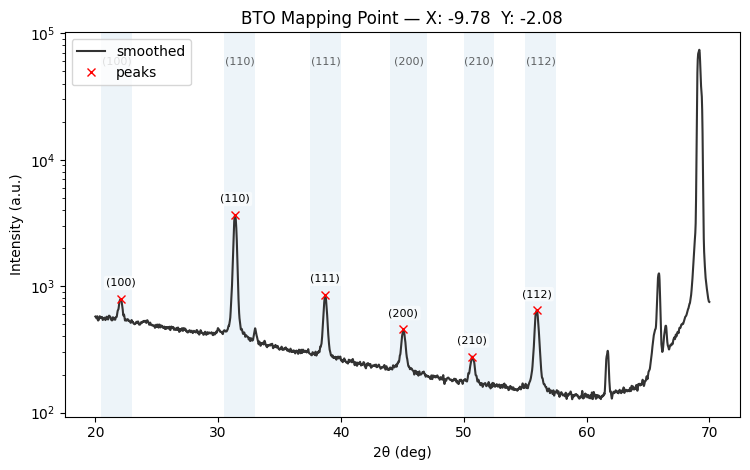


BTO_Mapping_Theta2Theta_30-09-2025_001_35_-19-563_-4-158.xy  peaks: 6
  (100)    [R1]   22.080°   I≈760.5   FWHM≈1.0791°   Area≈91.70
  (110)    [R2]   31.400°   I≈3722.1   FWHM≈1.7580°   Area≈1157.32
  (111)    [R3]   38.730°   I≈876.3   FWHM≈1.4114°   Area≈216.86
  (200)    [R4]   45.140°   I≈419.9   FWHM≈2.0876°   Area≈118.75
  (210)    [R5]   50.690°   I≈280.0   FWHM≈1.7508°   Area≈60.70
  (112)    [R6]   55.980°   I≈654.9   FWHM≈1.7308°   Area≈232.61


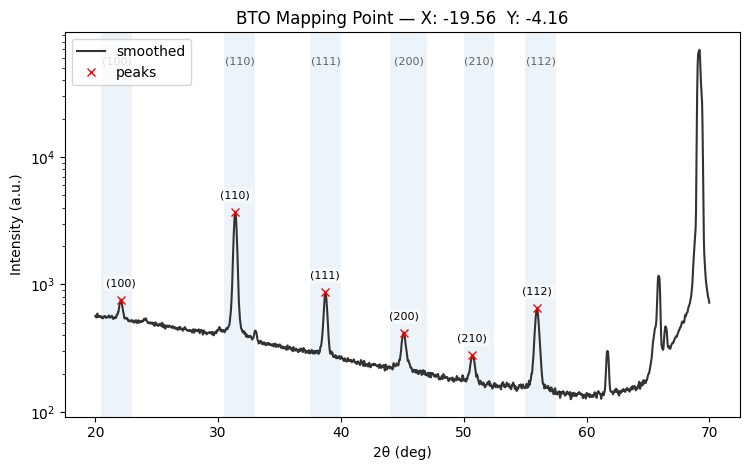


BTO_Mapping_Theta2Theta_30-09-2025_001_36_-29-344_-6-237.xy  peaks: 6
  (100)    [R1]   22.120°   I≈713.7   FWHM≈1.0928°   Area≈94.92
  (110)    [R2]   31.410°   I≈3679.0   FWHM≈1.7405°   Area≈1149.45
  (111)    [R3]   38.770°   I≈867.0   FWHM≈1.4040°   Area≈253.31
  (200)    [R4]   45.170°   I≈368.6   FWHM≈2.0019°   Area≈111.27
  (210)    [R5]   50.720°   I≈271.5   FWHM≈1.6857°   Area≈58.46
  (112)    [R6]   55.970°   I≈659.4   FWHM≈1.7002°   Area≈244.13


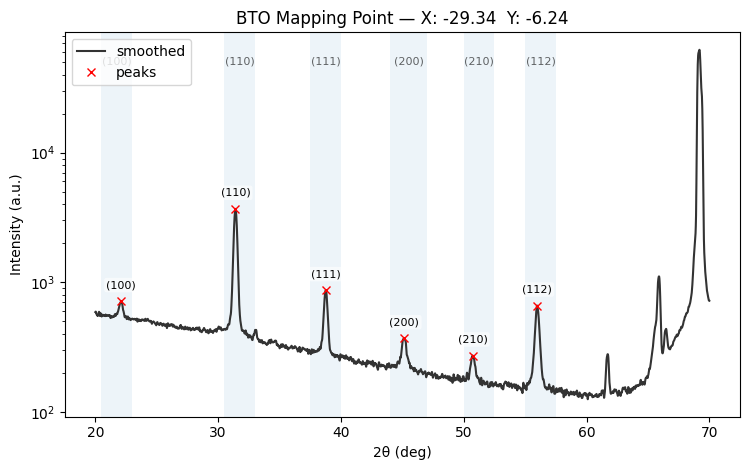


BTO_Mapping_Theta2Theta_30-09-2025_001_37_-39-126_-8-316.xy  peaks: 6
  (100)    [R1]   22.140°   I≈691.0   FWHM≈1.0673°   Area≈75.92
  (110)    [R2]   31.430°   I≈3589.8   FWHM≈1.7271°   Area≈1150.22
  (111)    [R3]   38.780°   I≈886.0   FWHM≈1.3853°   Area≈243.05
  (200)    [R4]   45.200°   I≈339.7   FWHM≈1.8251°   Area≈95.15
  (210)    [R5]   50.760°   I≈257.1   FWHM≈1.6008°   Area≈43.07
  (112)    [R6]   56.000°   I≈648.1   FWHM≈1.6975°   Area≈242.07


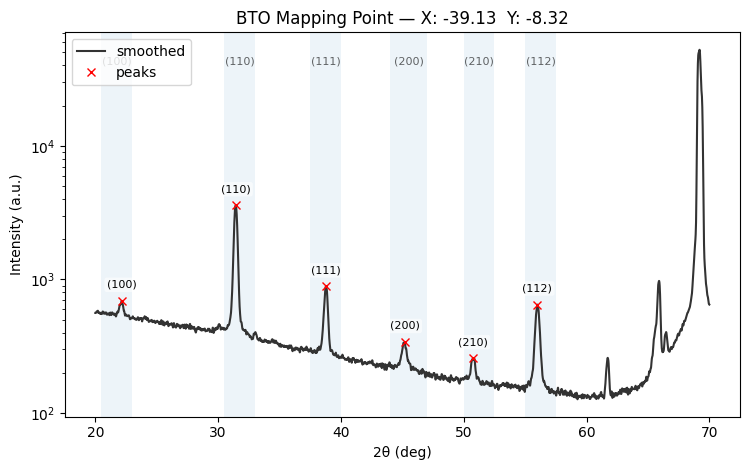


BTO_Mapping_Theta2Theta_30-09-2025_001_38_-8-090_-5-878.xy  peaks: 6
  (100)    [R1]   22.080°   I≈855.8   FWHM≈1.1019°   Area≈142.85
  (110)    [R2]   31.380°   I≈3771.9   FWHM≈1.7764°   Area≈1196.91
  (111)    [R3]   38.720°   I≈807.6   FWHM≈1.4346°   Area≈211.60
  (200)    [R4]   45.050°   I≈495.1   FWHM≈2.1335°   Area≈151.13
  (210)    [R5]   50.720°   I≈295.6   FWHM≈1.8505°   Area≈65.13
  (112)    [R6]   55.900°   I≈648.7   FWHM≈1.7560°   Area≈239.28


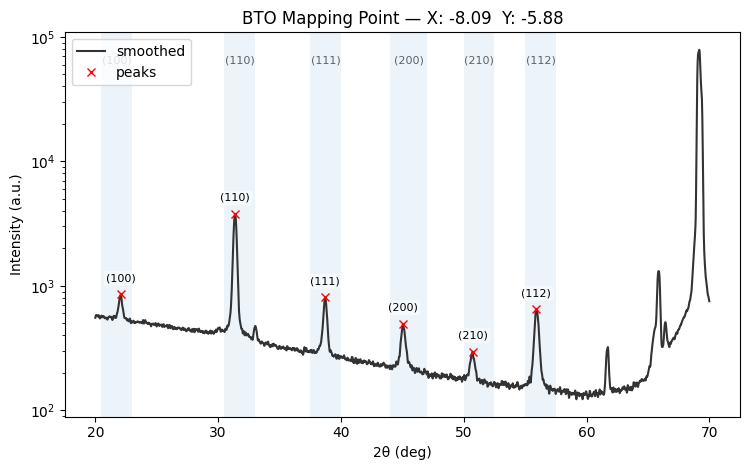


BTO_Mapping_Theta2Theta_30-09-2025_001_39_-16-180_-11-756.xy  peaks: 6
  (100)    [R1]   22.070°   I≈842.5   FWHM≈1.1172°   Area≈148.99
  (110)    [R2]   31.390°   I≈3924.3   FWHM≈1.7693°   Area≈1234.85
  (111)    [R3]   38.740°   I≈771.5   FWHM≈1.4420°   Area≈206.30
  (200)    [R4]   45.080°   I≈499.8   FWHM≈2.1038°   Area≈139.47
  (210)    [R5]   50.710°   I≈288.8   FWHM≈1.8310°   Area≈70.48
  (112)    [R6]   55.940°   I≈658.2   FWHM≈1.7505°   Area≈241.47


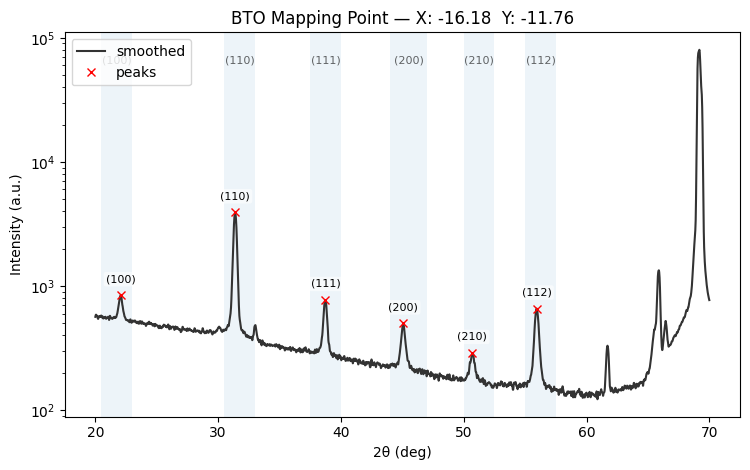


BTO_Mapping_Theta2Theta_30-09-2025_001_40_-24-271_-17-634.xy  peaks: 6
  (100)    [R1]   22.050°   I≈837.0   FWHM≈1.0974°   Area≈130.07
  (110)    [R2]   31.400°   I≈4076.3   FWHM≈1.7562°   Area≈1296.10
  (111)    [R3]   38.770°   I≈747.7   FWHM≈1.4321°   Area≈198.36
  (200)    [R4]   45.060°   I≈492.7   FWHM≈2.0968°   Area≈132.38
  (210)    [R5]   50.700°   I≈299.1   FWHM≈1.8290°   Area≈63.41
  (112)    [R6]   55.930°   I≈660.1   FWHM≈1.7416°   Area≈246.64


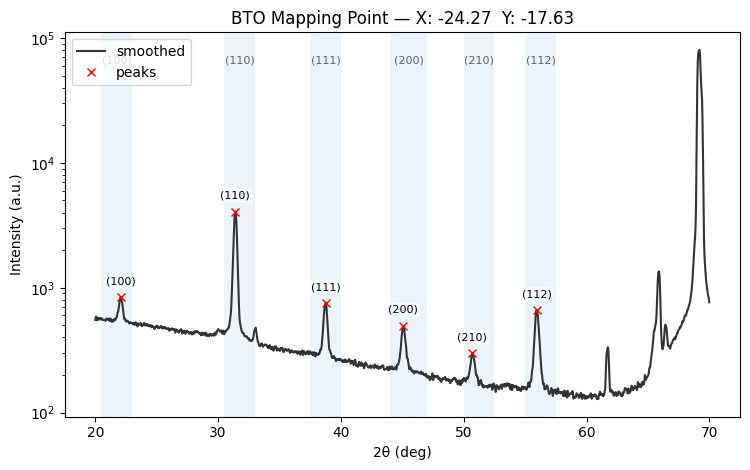


BTO_Mapping_Theta2Theta_30-09-2025_001_41_-32-361_-23-511.xy  peaks: 6
  (100)    [R1]   22.070°   I≈817.5   FWHM≈1.0905°   Area≈150.13
  (110)    [R2]   31.420°   I≈4265.0   FWHM≈1.7418°   Area≈1358.82
  (111)    [R3]   38.750°   I≈781.5   FWHM≈1.3992°   Area≈200.17
  (200)    [R4]   45.150°   I≈455.2   FWHM≈2.0992°   Area≈131.21
  (210)    [R5]   50.760°   I≈284.1   FWHM≈1.7422°   Area≈70.11
  (112)    [R6]   55.990°   I≈655.3   FWHM≈1.7173°   Area≈241.41


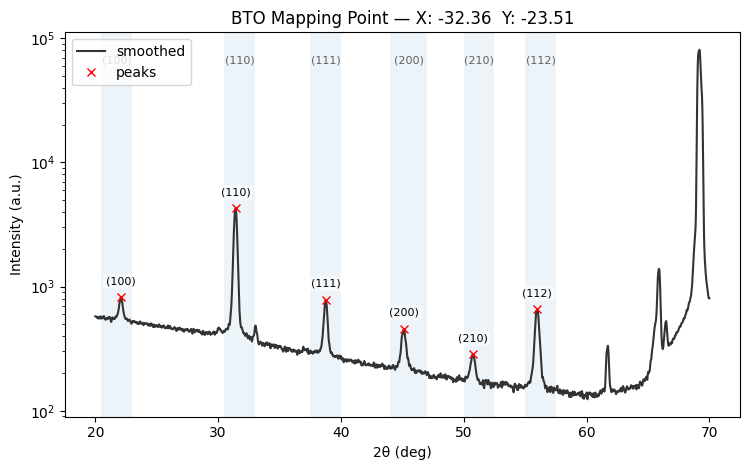


BTO_Mapping_Theta2Theta_30-09-2025_001_42_-5-000_-8-660.xy  peaks: 6
  (100)    [R1]   22.030°   I≈874.1   FWHM≈1.1268°   Area≈173.37
  (110)    [R2]   31.370°   I≈3844.9   FWHM≈1.7834°   Area≈1205.39
  (111)    [R3]   38.700°   I≈741.8   FWHM≈1.4479°   Area≈189.15
  (200)    [R4]   45.070°   I≈528.2   FWHM≈2.1223°   Area≈163.95
  (210)    [R5]   50.650°   I≈293.2   FWHM≈1.8135°   Area≈71.38
  (112)    [R6]   55.920°   I≈649.8   FWHM≈1.7749°   Area≈241.61


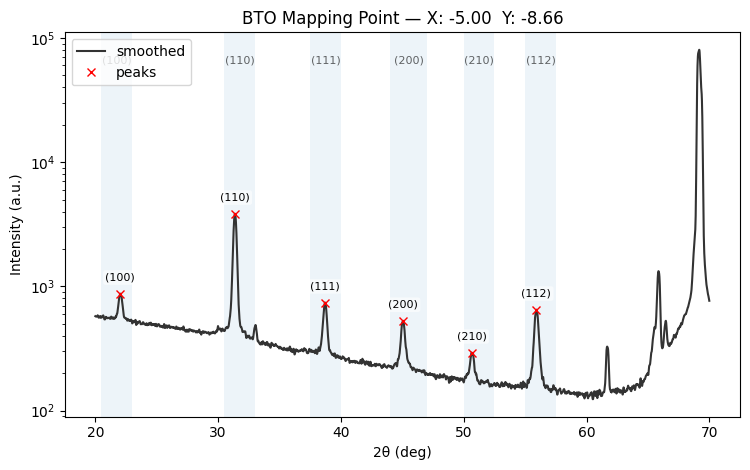


BTO_Mapping_Theta2Theta_30-09-2025_001_43_-10-000_-17-321.xy  peaks: 6
  (100)    [R1]   22.030°   I≈905.0   FWHM≈1.1259°   Area≈162.15
  (110)    [R2]   31.360°   I≈4020.3   FWHM≈1.7903°   Area≈1268.25
  (111)    [R3]   38.670°   I≈681.6   FWHM≈1.4621°   Area≈181.38
  (200)    [R4]   45.010°   I≈558.5   FWHM≈2.1610°   Area≈168.74
  (210)    [R5]   50.690°   I≈307.9   FWHM≈1.9455°   Area≈65.68
  (112)    [R6]   55.900°   I≈649.9   FWHM≈1.7932°   Area≈244.79


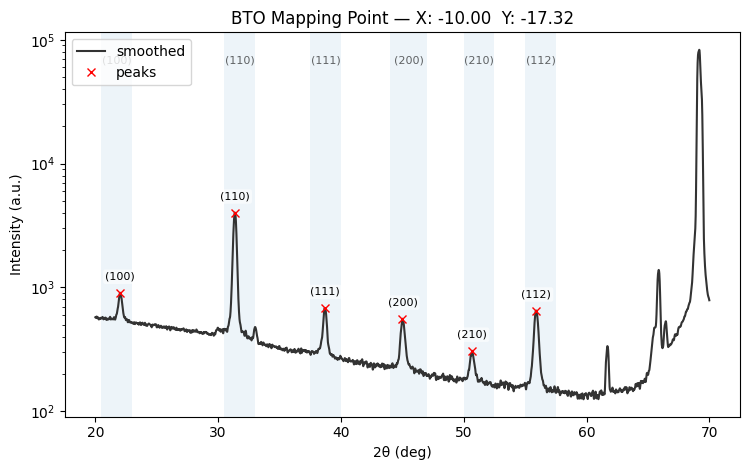


BTO_Mapping_Theta2Theta_30-09-2025_001_44_-15-000_-25-981.xy  peaks: 6
  (100)    [R1]   22.000°   I≈921.3   FWHM≈1.1387°   Area≈169.99
  (110)    [R2]   31.360°   I≈4164.8   FWHM≈1.7970°   Area≈1299.38
  (111)    [R3]   38.710°   I≈622.0   FWHM≈1.4688°   Area≈132.96
  (200)    [R4]   45.020°   I≈558.8   FWHM≈2.1819°   Area≈183.35
  (210)    [R5]   50.660°   I≈295.4   FWHM≈1.9194°   Area≈68.67
  (112)    [R6]   55.900°   I≈669.8   FWHM≈1.8079°   Area≈247.97


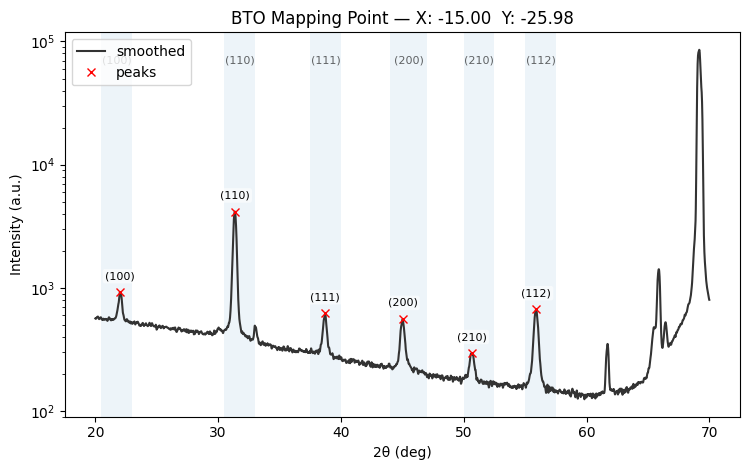


BTO_Mapping_Theta2Theta_30-09-2025_001_45_-20-000_-34-641.xy  peaks: 6
  (100)    [R1]   22.030°   I≈924.2   FWHM≈1.1504°   Area≈153.73
  (110)    [R2]   31.350°   I≈4255.2   FWHM≈1.8059°   Area≈1331.33
  (111)    [R3]   38.680°   I≈560.8   FWHM≈1.4908°   Area≈149.03
  (200)    [R4]   44.990°   I≈565.8   FWHM≈2.1941°   Area≈194.23
  (210)    [R5]   50.630°   I≈308.6   FWHM≈1.9633°   Area≈75.57
  (112)    [R6]   55.890°   I≈660.7   FWHM≈1.8294°   Area≈242.50


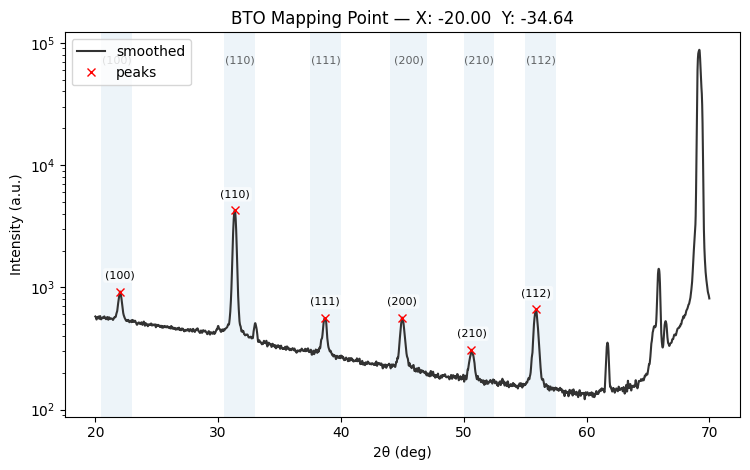


BTO_Mapping_Theta2Theta_30-09-2025_001_46_-1-045_-9-945.xy  peaks: 6
  (100)    [R1]   22.030°   I≈912.1   FWHM≈1.1175°   Area≈145.66
  (110)    [R2]   31.370°   I≈3920.3   FWHM≈1.7907°   Area≈1213.78
  (111)    [R3]   38.670°   I≈705.0   FWHM≈1.4788°   Area≈180.89
  (200)    [R4]   45.030°   I≈553.6   FWHM≈2.1433°   Area≈171.01
  (210)    [R5]   50.660°   I≈297.5   FWHM≈1.9004°   Area≈63.05
  (112)    [R6]   55.930°   I≈660.7   FWHM≈1.7889°   Area≈248.13


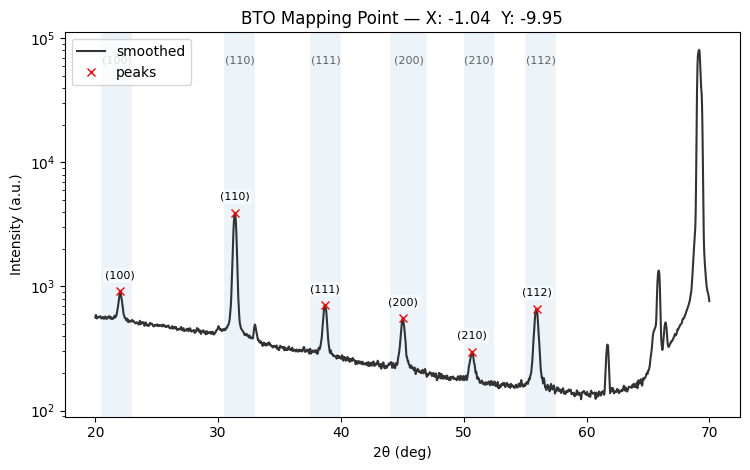


BTO_Mapping_Theta2Theta_30-09-2025_001_47_-2-091_-19-890.xy  peaks: 6
  (100)    [R1]   22.000°   I≈960.9   FWHM≈1.1580°   Area≈165.26
  (110)    [R2]   31.340°   I≈4061.7   FWHM≈1.8183°   Area≈1292.31
  (111)    [R3]   38.670°   I≈613.0   FWHM≈1.5047°   Area≈153.56
  (200)    [R4]   45.000°   I≈591.2   FWHM≈2.2064°   Area≈191.29
  (210)    [R5]   50.590°   I≈306.9   FWHM≈1.9955°   Area≈68.44
  (112)    [R6]   55.850°   I≈638.3   FWHM≈1.8475°   Area≈233.06


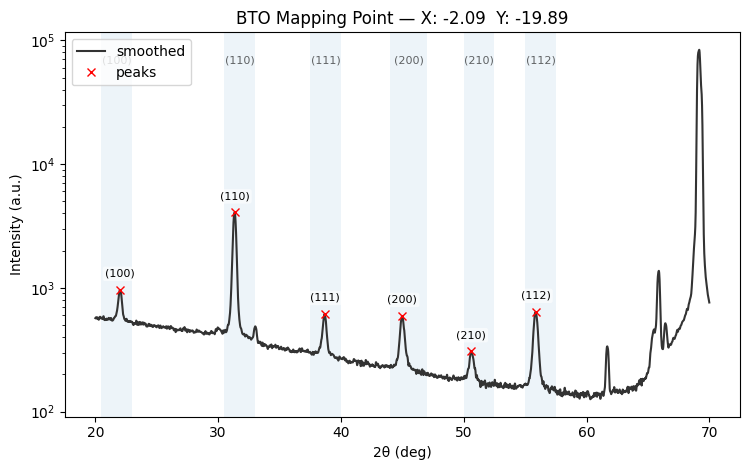


BTO_Mapping_Theta2Theta_30-09-2025_001_48_-3-136_-29-836.xy  peaks: 6
  (100)    [R1]   21.970°   I≈1068.6   FWHM≈1.1936°   Area≈224.90
  (110)    [R2]   31.290°   I≈4083.0   FWHM≈1.8710°   Area≈1314.17
  (111)    [R3]   38.640°   I≈512.4   FWHM≈1.5981°   Area≈122.16
  (200)    [R4]   44.920°   I≈690.2   FWHM≈2.2810°   Area≈227.79
  (210)    [R5]   50.640°   I≈312.5   FWHM≈2.0971°   Area≈71.76
  (112)    [R6]   55.790°   I≈590.2   FWHM≈1.9463°   Area≈216.89


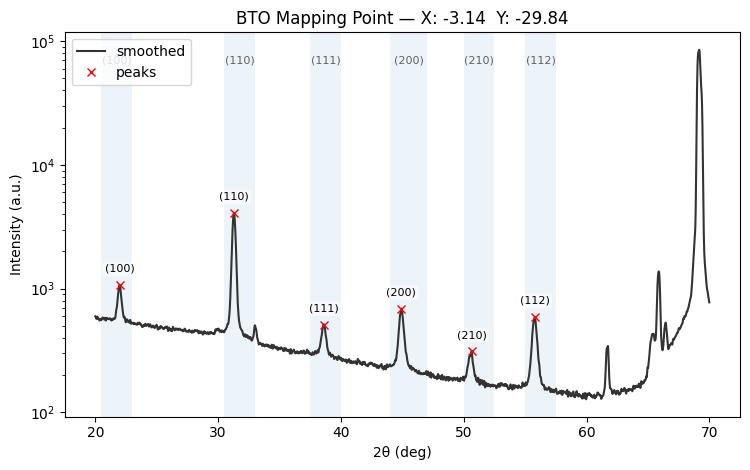


BTO_Mapping_Theta2Theta_30-09-2025_001_49_-4-181_-39-781.xy  peaks: 6
  (100)    [R1]   21.950°   I≈1111.4   FWHM≈1.2166°   Area≈246.71
  (110)    [R2]   31.250°   I≈4053.7   FWHM≈1.9162°   Area≈1340.80
  (111)    [R3]   38.570°   I≈479.5   FWHM≈1.6511°   Area≈103.64
  (200)    [R4]   44.830°   I≈725.1   FWHM≈2.3654°   Area≈292.54
  (210)    [R5]   50.490°   I≈292.5   FWHM≈2.1362°   Area≈66.20
  (112)    [R6]   55.700°   I≈545.2   FWHM≈2.0131°   Area≈208.94


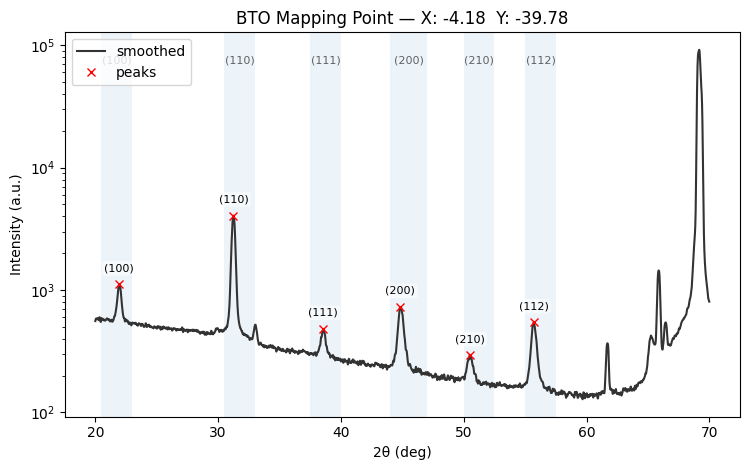


BTO_Mapping_Theta2Theta_30-09-2025_001_50_3-090_-9-511.xy  peaks: 6
  (100)    [R1]   22.010°   I≈914.3   FWHM≈1.1465°   Area≈183.02
  (110)    [R2]   31.360°   I≈3967.9   FWHM≈1.7949°   Area≈1253.29
  (111)    [R3]   38.690°   I≈707.8   FWHM≈1.4650°   Area≈182.59
  (200)    [R4]   45.050°   I≈531.7   FWHM≈2.1542°   Area≈159.24
  (210)    [R5]   50.680°   I≈298.8   FWHM≈1.8969°   Area≈72.66
  (112)    [R6]   55.900°   I≈669.3   FWHM≈1.7913°   Area≈249.38


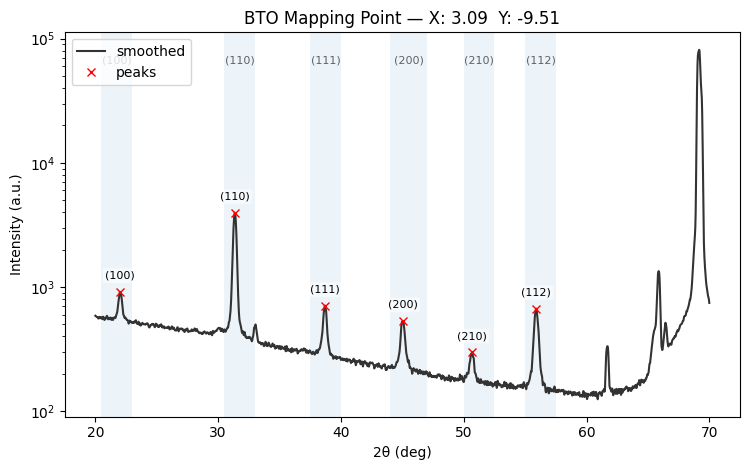


BTO_Mapping_Theta2Theta_30-09-2025_001_51_6-180_-19-021.xy  peaks: 6
  (100)    [R1]   22.010°   I≈989.6   FWHM≈1.1616°   Area≈165.98
  (110)    [R2]   31.320°   I≈4184.3   FWHM≈1.8329°   Area≈1326.16
  (111)    [R3]   38.680°   I≈598.6   FWHM≈1.5221°   Area≈148.97
  (200)    [R4]   44.980°   I≈593.0   FWHM≈2.2428°   Area≈191.56
  (210)    [R5]   50.610°   I≈309.6   FWHM≈2.0162°   Area≈71.85
  (112)    [R6]   55.860°   I≈648.5   FWHM≈1.8606°   Area≈233.90


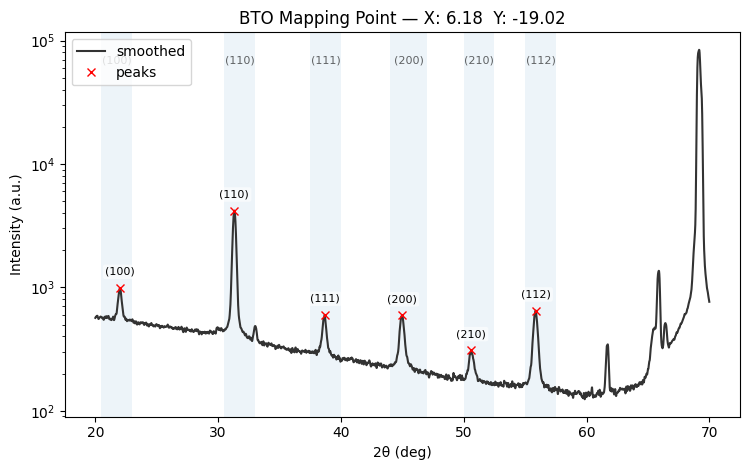


BTO_Mapping_Theta2Theta_30-09-2025_001_52_9-271_-28-532.xy  peaks: 6
  (100)    [R1]   21.960°   I≈1092.0   FWHM≈1.2226°   Area≈259.68
  (110)    [R2]   31.250°   I≈4084.0   FWHM≈1.9071°   Area≈1331.57
  (111)    [R3]   38.570°   I≈498.5   FWHM≈1.6321°   Area≈121.65
  (200)    [R4]   44.860°   I≈718.3   FWHM≈2.3510°   Area≈269.98
  (210)    [R5]   50.590°   I≈294.5   FWHM≈2.0988°   Area≈58.52
  (112)    [R6]   55.720°   I≈556.3   FWHM≈1.9926°   Area≈206.69


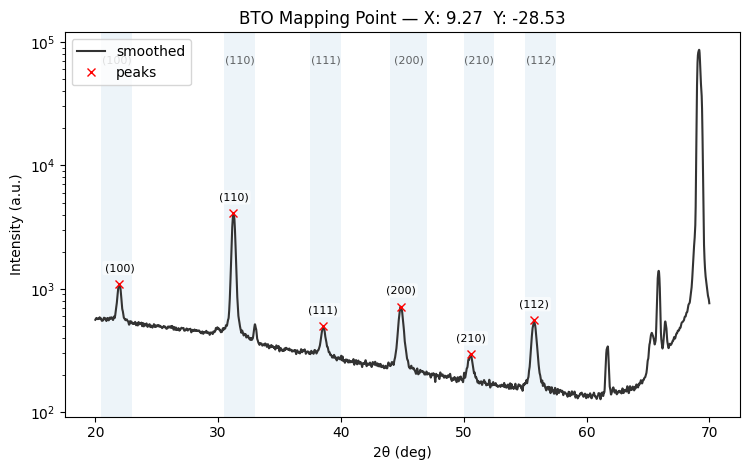


BTO_Mapping_Theta2Theta_30-09-2025_001_53_12-361_-38-042.xy  peaks: 6
  (100)    [R1]   21.920°   I≈1113.1   FWHM≈1.2512°   Area≈255.93
  (110)    [R2]   31.210°   I≈4403.9   FWHM≈1.9501°   Area≈1450.53
  (111)    [R3]   38.520°   I≈476.5   FWHM≈1.6679°   Area≈117.41
  (200)    [R4]   44.830°   I≈728.4   FWHM≈2.4179°   Area≈298.05
  (210)    [R5]   50.500°   I≈304.1   FWHM≈2.2212°   Area≈50.81
  (112)    [R6]   55.680°   I≈533.8   FWHM≈2.0759°   Area≈202.69


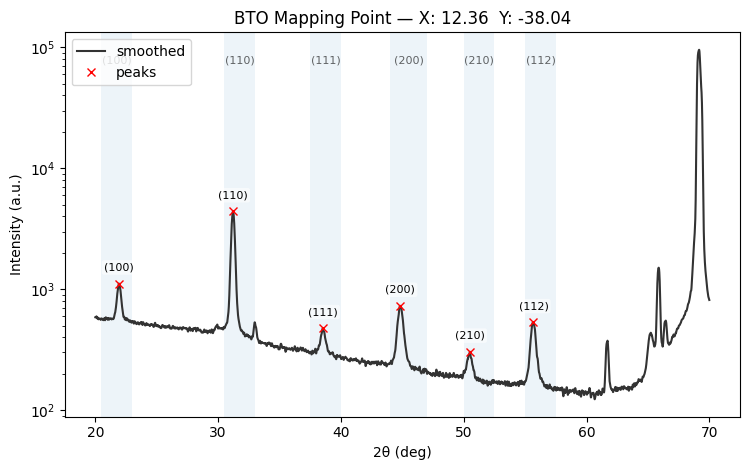


BTO_Mapping_Theta2Theta_30-09-2025_001_54_6-691_-7-431.xy  peaks: 6
  (100)    [R1]   22.050°   I≈899.5   FWHM≈1.1413°   Area≈155.93
  (110)    [R2]   31.360°   I≈3980.8   FWHM≈1.7940°   Area≈1252.71
  (111)    [R3]   38.700°   I≈719.8   FWHM≈1.4668°   Area≈186.36
  (200)    [R4]   45.030°   I≈548.1   FWHM≈2.1386°   Area≈162.02
  (210)    [R5]   50.650°   I≈299.4   FWHM≈1.9037°   Area≈65.61
  (112)    [R6]   55.910°   I≈672.3   FWHM≈1.7890°   Area≈244.13


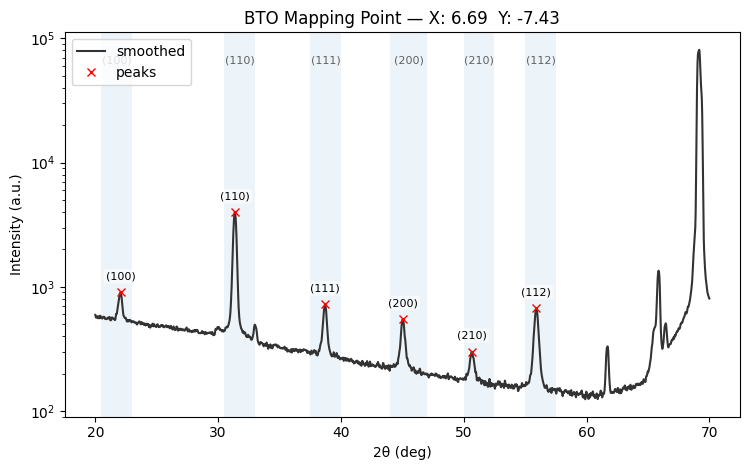


BTO_Mapping_Theta2Theta_30-09-2025_001_55_13-383_-14-863.xy  peaks: 6
  (100)    [R1]   22.000°   I≈935.3   FWHM≈1.1688°   Area≈158.97
  (110)    [R2]   31.330°   I≈4277.6   FWHM≈1.8253°   Area≈1338.14
  (111)    [R3]   38.650°   I≈624.6   FWHM≈1.5082°   Area≈156.69
  (200)    [R4]   44.980°   I≈559.9   FWHM≈2.2100°   Area≈182.24
  (210)    [R5]   50.610°   I≈306.5   FWHM≈2.0065°   Area≈74.34
  (112)    [R6]   55.840°   I≈670.0   FWHM≈1.8443°   Area≈254.41


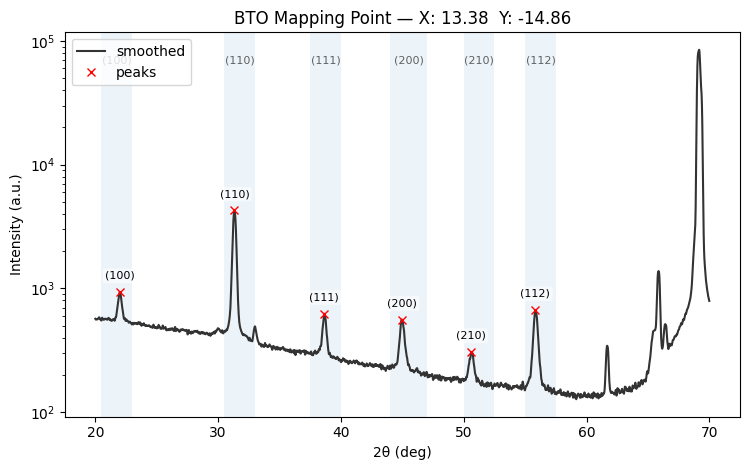


BTO_Mapping_Theta2Theta_30-09-2025_001_56_20-074_-22-294.xy  peaks: 6
  (100)    [R1]   21.960°   I≈1071.1   FWHM≈1.2176°   Area≈222.57
  (110)    [R2]   31.270°   I≈4257.6   FWHM≈1.8885°   Area≈1382.21
  (111)    [R3]   38.590°   I≈514.3   FWHM≈1.5943°   Area≈111.65
  (200)    [R4]   44.920°   I≈678.3   FWHM≈2.2942°   Area≈243.04
  (210)    [R5]   50.510°   I≈297.3   FWHM≈2.0740°   Area≈57.32
  (112)    [R6]   55.780°   I≈593.7   FWHM≈1.9513°   Area≈232.88


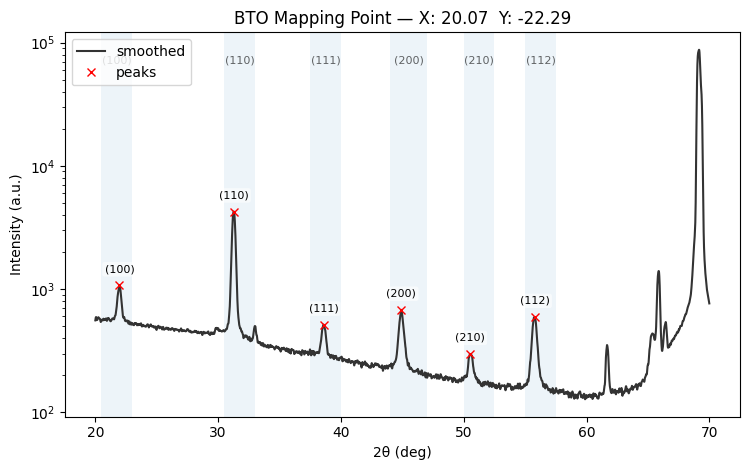


BTO_Mapping_Theta2Theta_30-09-2025_001_57_26-765_-29-726.xy  peaks: 6
  (100)    [R1]   21.940°   I≈1157.3   FWHM≈1.2364°   Area≈254.73
  (110)    [R2]   31.220°   I≈4443.4   FWHM≈1.9422°   Area≈1464.28
  (111)    [R3]   38.560°   I≈476.0   FWHM≈1.6459°   Area≈97.29
  (200)    [R4]   44.860°   I≈745.0   FWHM≈2.3763°   Area≈316.24
  (210)    [R5]   50.440°   I≈300.1   FWHM≈2.1622°   Area≈66.58
  (112)    [R6]   55.710°   I≈541.7   FWHM≈2.0328°   Area≈204.39


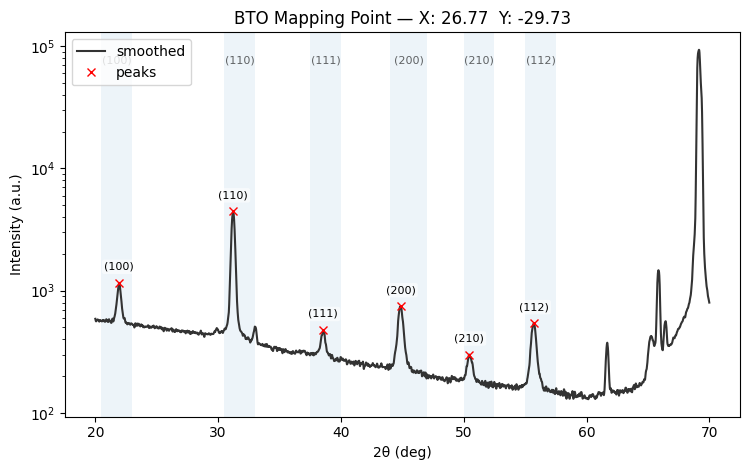


BTO_Mapping_Theta2Theta_30-09-2025_001_58_9-135_-4-067.xy  peaks: 6
  (100)    [R1]   22.060°   I≈891.7   FWHM≈1.1335°   Area≈156.91
  (110)    [R2]   31.370°   I≈3969.6   FWHM≈1.7875°   Area≈1245.58
  (111)    [R3]   38.690°   I≈761.3   FWHM≈1.4643°   Area≈206.05
  (200)    [R4]   45.050°   I≈523.0   FWHM≈2.1355°   Area≈150.91
  (210)    [R5]   50.710°   I≈294.0   FWHM≈1.8722°   Area≈67.28
  (112)    [R6]   55.910°   I≈679.0   FWHM≈1.7776°   Area≈244.12


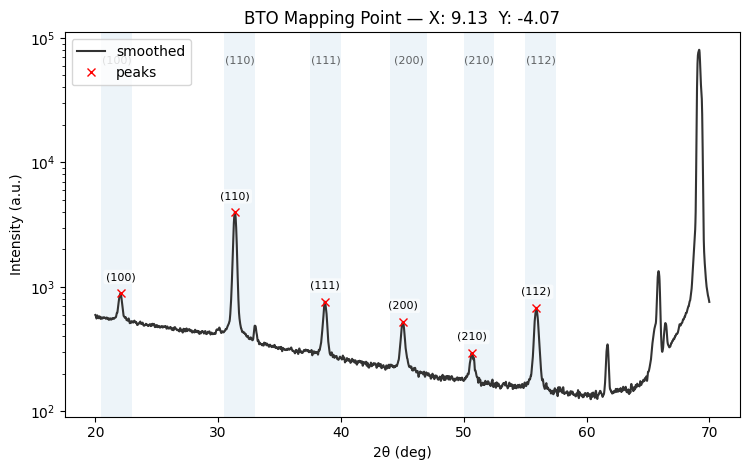


BTO_Mapping_Theta2Theta_30-09-2025_001_59_18-271_-8-135.xy  peaks: 6
  (100)    [R1]   22.000°   I≈877.1   FWHM≈1.1606°   Area≈141.25
  (110)    [R2]   31.350°   I≈4175.9   FWHM≈1.8074°   Area≈1331.38
  (111)    [R3]   38.690°   I≈714.2   FWHM≈1.4719°   Area≈174.21
  (200)    [R4]   45.050°   I≈521.3   FWHM≈2.1801°   Area≈158.18
  (210)    [R5]   50.620°   I≈297.8   FWHM≈1.9185°   Area≈72.21
  (112)    [R6]   55.900°   I≈702.4   FWHM≈1.7915°   Area≈247.99


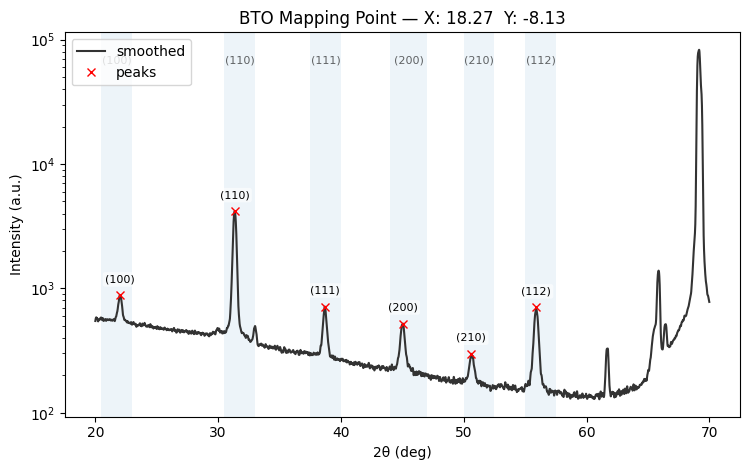


BTO_Mapping_Theta2Theta_30-09-2025_001_60_27-406_-12-202.xy  peaks: 6
  (100)    [R1]   22.010°   I≈888.1   FWHM≈1.1760°   Area≈141.84
  (110)    [R2]   31.330°   I≈4387.2   FWHM≈1.8300°   Area≈1394.14
  (111)    [R3]   38.660°   I≈619.0   FWHM≈1.4994°   Area≈147.40
  (200)    [R4]   44.960°   I≈541.0   FWHM≈2.2143°   Area≈176.23
  (210)    [R5]   50.620°   I≈308.7   FWHM≈1.9812°   Area≈74.27
  (112)    [R6]   55.870°   I≈682.6   FWHM≈1.8423°   Area≈256.58


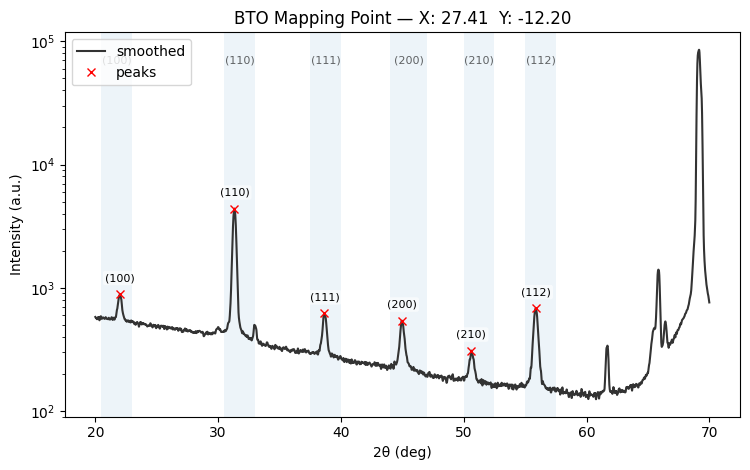


BTO_Mapping_Theta2Theta_30-09-2025_001_61_36-542_-16-269.xy  peaks: 6
  (100)    [R1]   21.980°   I≈920.2   FWHM≈1.1961°   Area≈155.01
  (110)    [R2]   31.300°   I≈4559.9   FWHM≈1.8547°   Area≈1432.02
  (111)    [R3]   38.670°   I≈594.2   FWHM≈1.5143°   Area≈139.38
  (200)    [R4]   44.950°   I≈554.0   FWHM≈2.2440°   Area≈193.33
  (210)    [R5]   50.630°   I≈306.0   FWHM≈2.0395°   Area≈60.36
  (112)    [R6]   55.840°   I≈663.6   FWHM≈1.8817°   Area≈255.20


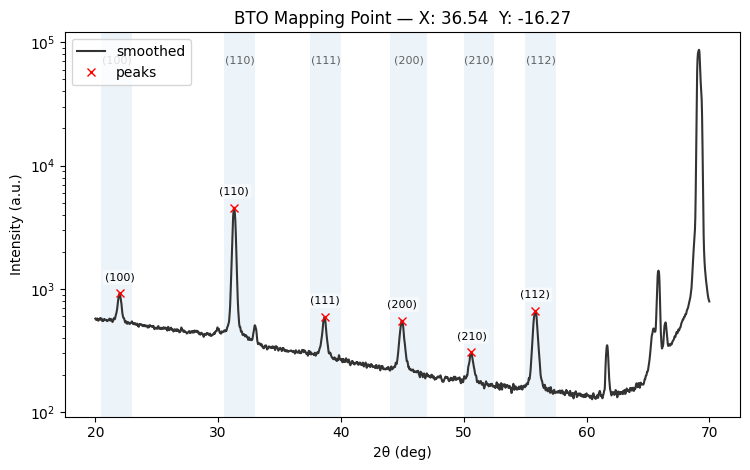


=== Summary ===
Number of files processed: 61
Results shape (FWHM): (61, 6)
Peak intensity shape: (61, 6)
Peak areas shape: (61, 6)
Coordinates: 61 x, 61 y

FWHM statistics (excluding NaN):
  (100): min=1.0351°, max=1.2512°, mean=1.1276°
  (110): min=1.7271°, max=1.9501°, mean=1.7891°
  (111): min=1.3852°, max=1.6679°, mean=1.4565°
  (200): min=1.6733°, max=2.4179°, mean=2.0410°
  (210): min=1.3918°, max=2.2212°, mean=1.7594°
  (112): min=1.6975°, max=2.0759°, mean=1.7810°

Integrated Area statistics (excluding NaN):
  (100): min=55.73, max=259.68, mean=126.58
  (110): min=492.49, max=1464.28, mean=1109.99
  (111): min=97.29, max=351.22, mean=229.25
  (200): min=55.95, max=316.24, mean=137.83
  (210): min=27.71, max=75.57, mean=57.41
  (112): min=188.21, max=262.26, mean=236.59


In [13]:
# ---------- settings ----------
pattern       = "*.xy"
window_pts    = 12
polyorder     = 2
min_sep_deg   = 0.25
width_deg     = (0.06, 1.2)
ratio_min     = 1.2
frac_min      = 0.00

# Initialize storage: list of dictionaries, one per file
all_file_results = []
x_coordinates = []
y_coordinates = []

# Define your search windows (lo, hi) and their names (same order!)
REGIONS = [
    (20.5, 23.0),   # e.g. (100)
    (30.5, 33.0),   # e.g. (110)
    (37.5, 40.0),   # e.g. (111) or whatever you expect
    (44.0, 47.0),   # e.g. (200)
    (50.0, 52.5),   # e.g. (210)
    (55.0, 57.5),   # e.g. (300)
]
REGION_NAMES = ["(100)", "(110)", "(111)", "(200)", "(210)", "(112)"]  # <- set to your BTO planes

# ------------------------------
def _safe_window(n, w, p):
    if n < 5:
        return None, None
    w = min(w, n - (1 - (n % 2)))
    if w % 2 == 0: w += 1
    w = max(5, w)
    p = min(p, w - 2)
    return w, p

files = sorted(glob.glob(pattern))
for fp in files:
    data = np.loadtxt(fp)
    x, y = data[:,0], data[:,1]
    step = float(np.mean(np.diff(x)))

    # smooth for visuals
    w_use, p_use = _safe_window(len(x), window_pts, polyorder)
    ys = savgol_filter(y, w_use, p_use, mode="interp") if w_use is not None else y.copy()

    distance = max(1, int(min_sep_deg/step))
    width_s  = (max(1, int(width_deg[0]/step)), max(2, int(width_deg[1]/step)))

    # Storage for THIS file: we'll store 6 values (one per region)
    file_fwhm = np.full(6, np.nan)      # Initialize with NaN
    file_intensity = np.full(6, np.nan)
    file_area = np.full(6, np.nan)
    file_peak_positions = [None] * 6
    
    all_peaks_idx = []
    all_fwhm_deg  = []
    all_area      = []
    all_region_id = []
    all_Ipk       = []
    all_labels    = []

    # counters per region for numbering multiple peaks
    per_region_count = {i: 0 for i in range(1, len(REGIONS)+1)}

    for rid, (lo, hi) in enumerate(REGIONS, start=1):
        m = (x >= lo) & (x <= hi)
        if np.count_nonzero(m) < 7:
            continue

        xr  = x[m]
        yr  = ys[m]
        idx0 = np.nonzero(m)[0][0]

        # coarse candidates
        cand_r, prop = find_peaks(yr, distance=distance, width=width_s)
        if cand_r.size == 0:
            continue

        keep_r = []
        for i, pk in enumerate(cand_r):
            lb = prop["left_bases"][i]
            rb = prop["right_bases"][i]
            base = max(yr[lb], yr[rb])
            amp  = yr[pk] - base
            if amp <= 0:                                  continue
            if yr[pk] / max(base, 1e-9) < ratio_min:     continue
            if amp < frac_min * base:                    continue
            keep_r.append(i)

        if not keep_r:
            continue

        peaks_r = cand_r[keep_r]
        widths, w_left, w_right, _ = peak_widths(yr, peaks_r, rel_height=0.5)

        idx_axis = np.arange(len(xr), dtype=float)
        left_x   = np.interp(w_left,  idx_axis, xr)
        right_x  = np.interp(w_right, idx_axis, xr)
        fwhm_deg = np.abs(right_x - left_x)  # Ensure positive FWHM

        for j, pk in enumerate(peaks_r):
            lb = prop["left_bases"][keep_r[j]]
            rb = prop["right_bases"][keep_r[j]]

            # Get baseline points
            x_lb, y_lb = xr[lb], yr[lb]
            x_rb, y_rb = xr[rb], yr[rb]

            # Define integration limits: use the base points as limits
            # (these are typically wider than FWHM)
            lx, rx = x_lb, x_rb
            
            # Make sure lx < rx
            if lx >= rx:
                lx = left_x[j]
                rx = right_x[j]
            
            # Get all points in the integration region
            seg_mask = (xr >= lx) & (xr <= rx)
            
            if np.count_nonzero(seg_mask) < 2:
                # Fallback: use a window around the peak
                k0 = max(0, pk - 3)
                k1 = min(len(xr), pk + 4)
                seg_mask = np.zeros_like(xr, dtype=bool)
                seg_mask[k0:k1] = True
            
            # Get x and y values in integration region
            xs = xr[seg_mask]
            ys_seg = yr[seg_mask]
            
            # Calculate linear baseline
            if x_rb != x_lb:
                slope = (y_rb - y_lb) / (x_rb - x_lb)
                y_base = y_lb + slope * (xs - x_lb)
            else:
                y_base = np.full_like(xs, np.mean([y_lb, y_rb]))
            
            # Integrate: area above baseline
            area = np.trapz(np.maximum(ys_seg - y_base, 0.0), xs)
            
            # Alternative: simpler rectangular approximation if trapz gives issues
            if area == 0.0 or not np.isfinite(area):
                # Use peak height times FWHM as approximation (Gaussian-like)
                peak_height = yr[pk] - np.mean([y_lb, y_rb])
                area = peak_height * fwhm_deg[j] * 0.5 * np.sqrt(np.pi / np.log(2))

            gi = idx0 + pk
            all_peaks_idx.append(gi)
            all_fwhm_deg.append(float(fwhm_deg[j]))
            all_area.append(float(area))
            all_region_id.append(rid)
            all_Ipk.append(float(yr[pk]))

            # --- NAME the peak ---
            base_name = REGION_NAMES[rid-1] if rid-1 < len(REGION_NAMES) else f"R{rid}"
            per_region_count[rid] += 1
            label = base_name if per_region_count[rid] == 1 else f"{base_name}-{per_region_count[rid]}"
            all_labels.append(label)
            
            # Store in region array (use first peak if multiple)
            if per_region_count[rid] == 1:
                file_fwhm[rid-1] = float(fwhm_deg[j])
                file_intensity[rid-1] = float(yr[pk])
                file_area[rid-1] = float(area)
                file_peak_positions[rid-1] = float(x[gi])

    # ---- output ----
    print(f"\n{os.path.basename(fp)}  peaks: {len(all_peaks_idx)}")
    for lbl, rid, gi, Ipk, fwhm, area in zip(all_labels, all_region_id, all_peaks_idx, all_Ipk, all_fwhm_deg, all_area):
        print(f"  {lbl:8s} [R{rid}]  {x[gi]:7.3f}°   I≈{Ipk:.1f}   FWHM≈{fwhm:.4f}°   Area≈{area:.2f}")
    
    # ---- plot ----
    plt.figure(figsize=(7.6, 4.8))
    plt.plot(x, ys, label="smoothed", color="0.2")

    # annotate peaks with their names
    if all_peaks_idx:
        p_x = x[np.array(all_peaks_idx)]
        p_y = np.array(all_Ipk)
        plt.plot(p_x, p_y, "rx", label="peaks")
        for (xx, yy, lbl) in zip(p_x, p_y, all_labels):
            plt.annotate(lbl, (xx, yy), xytext=(0, 8), textcoords="offset points",
                         ha="center", va="bottom", fontsize=8, rotation=0,
                         bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.6))

    # draw region spans
    for (lo, hi), nm in zip(REGIONS, REGION_NAMES):
        plt.axvspan(lo, hi, alpha=0.08)
        mid = 0.5*(lo+hi)
        plt.text(mid, plt.ylim()[1]*0.85, nm, ha="center", va="top", fontsize=8, alpha=0.6)

    # --- extract X and Y coordinates from filename ---
    name = os.path.basename(fp).rsplit('.', 1)[0]
    parts = name.split('_')
    try:
        x_str, y_str = parts[-2], parts[-1]
        def tok_to_float(t):
            if '-' in t[1:]:
                t = ('-' + t[1:].replace('-', '.', 1)) if t.startswith('-') else t.replace('-', '.', 1)
            return float(t)
        x_val, y_val = tok_to_float(x_str), tok_to_float(y_str)
        x_coordinates.append(x_val)
        y_coordinates.append(y_val)
        title_text = f"BTO Mapping Point — X: {x_val:.2f}  Y: {y_val:.2f}"
    except Exception:
        title_text = "BTO Mapping Point — Coordinates Unknown"

    plt.title(title_text)
    plt.xlabel("2θ (deg)"); plt.ylabel("Intensity (a.u.)")
    plt.yscale("log")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Store results for this file
    all_file_results.append({
        'fwhm': file_fwhm,
        'intensity': file_intensity,
        'area': file_area,
        'peak_positions': file_peak_positions
    })

# Convert to numpy arrays for easier manipulation
results = np.array([f['fwhm'] for f in all_file_results])  # Shape: (n_files, 6)
peak_intensity = np.array([f['intensity'] for f in all_file_results])  # Shape: (n_files, 6)
peak_areas = np.array([f['area'] for f in all_file_results])  # Shape: (n_files, 6)

print(f"\n=== Summary ===")
print(f"Number of files processed: {len(all_file_results)}")
print(f"Results shape (FWHM): {results.shape}")
print(f"Peak intensity shape: {peak_intensity.shape}")
print(f"Peak areas shape: {peak_areas.shape}")
print(f"Coordinates: {len(x_coordinates)} x, {len(y_coordinates)} y")
print(f"\nFWHM statistics (excluding NaN):")
for i, name in enumerate(REGION_NAMES):
    valid_fwhm = results[:, i][~np.isnan(results[:, i])]
    if len(valid_fwhm) > 0:
        print(f"  {name}: min={valid_fwhm.min():.4f}°, max={valid_fwhm.max():.4f}°, mean={valid_fwhm.mean():.4f}°")
    else:
        print(f"  {name}: No valid data")

print(f"\nIntegrated Area statistics (excluding NaN):")
for i, name in enumerate(REGION_NAMES):
    valid_area = peak_areas[:, i][~np.isnan(peak_areas[:, i])]
    if len(valid_area) > 0:
        print(f"  {name}: min={valid_area.min():.2f}, max={valid_area.max():.2f}, mean={valid_area.mean():.2f}")
    else:
        print(f"  {name}: No valid data")

In [14]:
results[:] = np.abs(results)
print(len(x_coordinates), len(y_coordinates), peak_intensity)

61 61 [[ 814.56155245 3680.80318182  843.73923776  462.60958741  280.68537762
   658.62871329]
 [ 864.46540559 3844.35405594  812.76330769  496.23707692  295.69851748
   674.2355035 ]
 [ 831.90731469 4053.60811888  801.53554545  487.17176224  292.01724476
   670.19504196]
 [ 830.90981818 4132.12916084  813.07894406  476.66218881  294.8248951
   675.85812587]
 [ 805.38168531 4233.91532168  798.9643007   444.4251958   293.46658042
   674.39093706]
 [ 816.56271329 3728.81232168  861.37440559  449.25206993  278.06197902
   653.87808392]
 [ 760.71213287 3689.19214685  905.59305594  417.11806294  280.65930769
   664.26633566]
 [ 711.61608392 3618.51248252  951.98058741  375.42718881  276.60548951
   642.90527972]
 [ 696.9258951  3507.82572028  925.66051748  330.91937762  266.86577622
   639.40144755]
 [ 771.52223077 3605.29470629  902.32565734  414.10170629  280.0433007
   658.25175524]
 [ 688.63571329 3383.96798601  990.36724476  353.8434965   260.47646853
   654.45097902]
 [ 659.80748951 3

## Contour Line Graphs

### Contour all FWHM

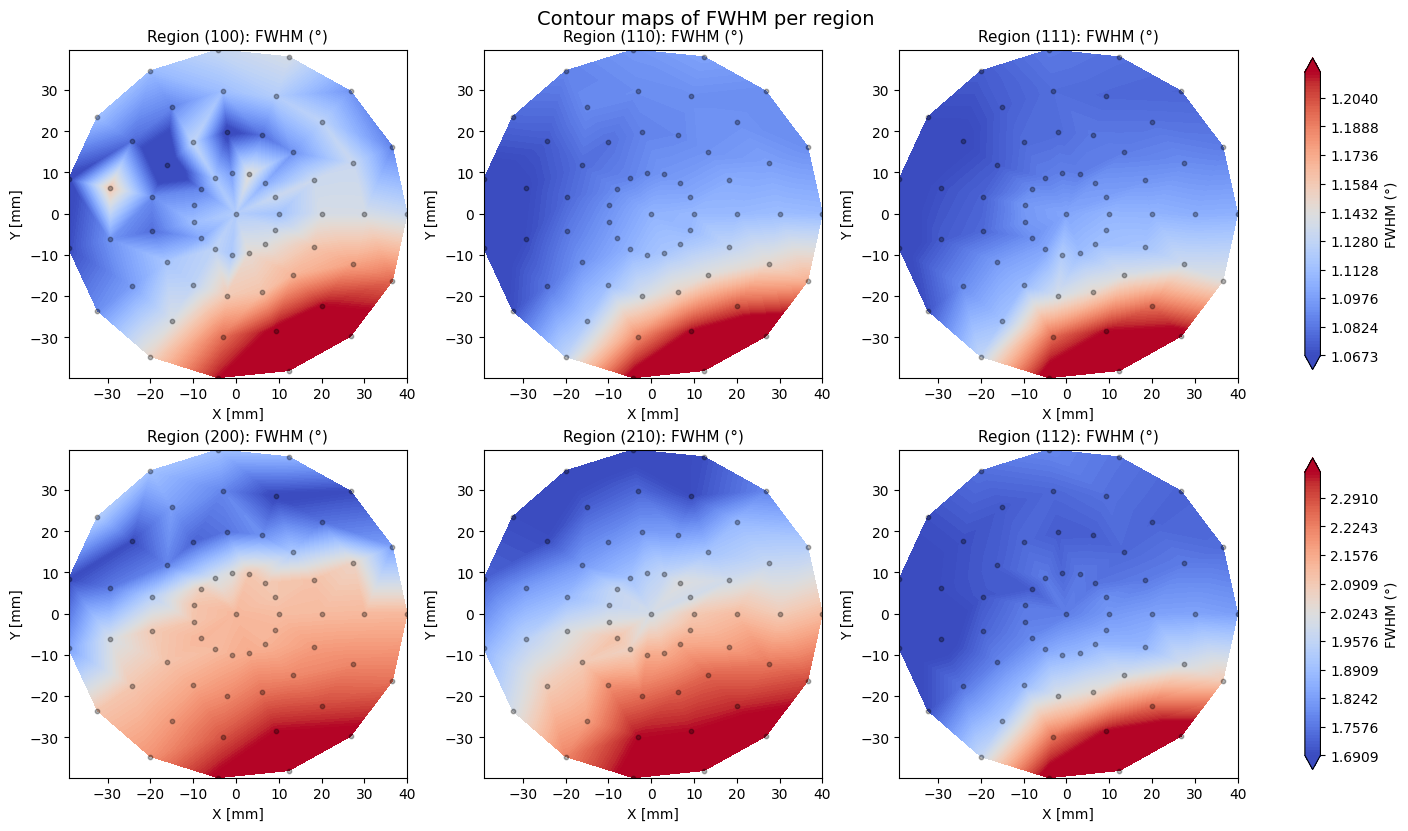

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from scipy.interpolate import griddata

# ---- your inputs ----
x_pos = np.asarray(x_coordinates, dtype=float)
y_pos = np.asarray(y_coordinates, dtype=float)
fw_raw = np.asarray(results, dtype=float)
N = x_pos.size


# ---- normalize fw_raw into shape (N, 6) ----
def normalize_fwhm(fw_raw, N):
    fw = np.asarray(fw_raw)
    if fw.ndim == 2 and fw.shape == (N, 6):
        return fw
    if fw.ndim == 1 and fw.size == N * 6:
        return fw.reshape(N, 6)
    if fw.ndim == 2 and fw.shape[0] == N * 6 and fw.shape[1] == 6:
        blocks = np.split(fw, 6, axis=0)
        return np.column_stack([blocks[j][:, j] for j in range(6)])
    if fw.ndim == 2 and fw.shape == (N * 6, 1):
        return fw.reshape(N, 6)
    raise ValueError(f"Cannot reshape results with shape {fw.shape} to (N,6).")

fwhm = normalize_fwhm(fw_raw, N)

# ---- helpers for plotting ----
def _unique_xy(x, y, z):
    arr = np.column_stack([x, y, z])
    keys = np.ascontiguousarray(arr[:, :2]).view(
        np.dtype((np.void, arr[:, :2].dtype.itemsize * 2))
    ).ravel()
    _, idx = np.unique(keys, return_index=True)
    idx = np.sort(idx)
    return arr[idx, 0], arr[idx, 1], arr[idx, 2]


def _contour_one(ax, xs, ys, zs, title, nlevels=100, cmap="coolwarm", try_grid_fallback=True):
    m = np.isfinite(xs) & np.isfinite(ys) & np.isfinite(zs)
    xs, ys, zs = xs[m], ys[m], zs[m]
    if len(xs) == 0:
        ax.text(0.5, 0.5, "No data", ha='center', va='center', transform=ax.transAxes)
        ax.set_axis_off(); return None

    xs, ys, zs = _unique_xy(xs, ys, zs)
    if len(xs) < 3:
        ax.text(0.5, 0.5, "Too few points", ha='center', va='center', transform=ax.transAxes)
        ax.set_axis_off(); return None

    # robust color limits
    vmin = np.nanpercentile(zs, 5)
    vmax = np.nanpercentile(zs, 95)
    if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
        vmin, vmax = float(np.nanmin(zs)), float(np.nanmax(zs))
        if not np.isfinite(vmin) or vmin == vmax:
            ax.text(0.5, 0.5, "No variation", ha='center', va='center', transform=ax.transAxes)
            ax.set_axis_off(); return None

    # triangulation or grid fallback
    try:
        tri = Triangulation(xs, ys)
        cf = ax.tricontourf(tri, zs, levels=np.linspace(vmin, vmax, nlevels),
                            extend='both', cmap=cmap)
    except Exception:
        if not try_grid_fallback:
            ax.text(0.5, 0.5, "Triangulation failed", ha='center', va='center', transform=ax.transAxes)
            ax.set_axis_off(); return None

        gx = np.linspace(xs.min(), xs.max(), 60)
        gy = np.linspace(ys.min(), ys.max(), 60)
        GX, GY = np.meshgrid(gx, gy)
        GZ = griddata((xs, ys), zs, (GX, GY), method='linear')
        if np.isnan(GZ).all():
            GZ = griddata((xs, ys), zs, (GX, GY), method='nearest')
        if np.isnan(GZ).all():
            ax.text(0.5, 0.5, "Insufficient geometry", ha='center', va='center', transform=ax.transAxes)
            ax.set_axis_off(); return None

        cf = ax.contourf(GX, GY, GZ, levels=np.linspace(vmin, vmax, nlevels),
                         extend='both', cmap=cmap)

    # no contour lines — only color map
    ax.scatter(xs, ys, s=10, c='k', alpha=0.3)  # optional: show measurement points
    ax.set_title(title, fontsize=11)
    ax.set_xlabel("X [mm]")
    ax.set_ylabel("Y [mm]")
    return cf

# ---- plot with coolwarm colormap ----
titles = [f"Region {REGION_NAMES[i]}" for i in range(6)]
fig, axes = plt.subplots(2, 3, figsize=(14, 8), constrained_layout=True)
cfs = []
for i in range(6):
    r, c = divmod(i, 3)
    cf = _contour_one(axes[r, c], x_pos, y_pos, fwhm[:, i],
                      title=f"{titles[i]}: FWHM (°)", cmap="coolwarm")
    cfs.append(cf)

# row-wise colorbars
for r in range(2):
    row = [cfs[r*3 + j] for j in range(3) if cfs[r*3 + j] is not None]
    if row:
        fig.colorbar(row[0], ax=axes[r, :], shrink=0.95, label="FWHM (°)")



plt.suptitle("Contour maps of FWHM per region", y=1.02, fontsize=14)
plt.show()


### Contour all Peak Intensity

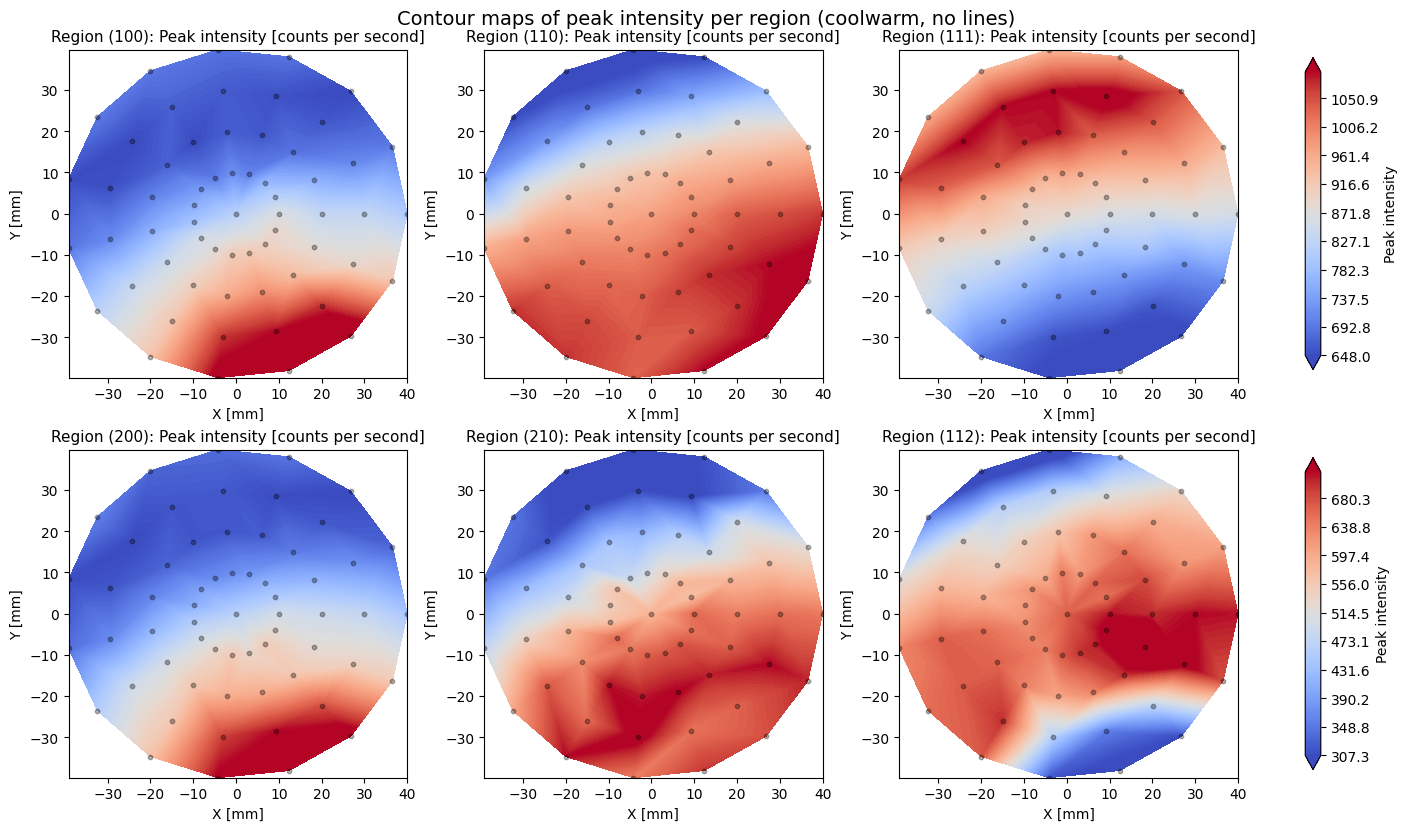

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from scipy.interpolate import griddata

# ---- inputs ----
x_pos = np.asarray(x_coordinates, dtype=float)
y_pos = np.asarray(y_coordinates, dtype=float)
pi_raw = np.asarray(peak_intensity, dtype=float)   # <-- use intensity here
N = x_pos.size

# ---- normalize into shape (N, 6) ----
def normalize_six(arr, N):
    a = np.asarray(arr)
    if a.ndim == 2 and a.shape == (N, 6):
        return a
    if a.ndim == 1 and a.size == N * 6:
        return a.reshape(N, 6)
    if a.ndim == 2 and a.shape[0] == N * 6 and a.shape[1] == 6:
        blocks = np.split(a, 6, axis=0)
        return np.column_stack([blocks[j][:, j] for j in range(6)])
    if a.ndim == 2 and a.shape == (N * 6, 1):
        return a.reshape(N, 6)
    raise ValueError(f"Cannot reshape array with shape {a.shape} to (N,6).")

peakI = normalize_six(pi_raw, N)   # (N, 6)

# ---- helpers ----
def _unique_xy(x, y, z):
    arr = np.column_stack([x, y, z])
    keys = np.ascontiguousarray(arr[:, :2]).view(
        np.dtype((np.void, arr[:, :2].dtype.itemsize * 2))
    ).ravel()
    _, idx = np.unique(keys, return_index=True)
    idx = np.sort(idx)
    return arr[idx, 0], arr[idx, 1], arr[idx, 2]

def _contour_one(ax, xs, ys, zs, title, nlevels=100, cmap="coolwarm", try_grid_fallback=True):
    m = np.isfinite(xs) & np.isfinite(ys) & np.isfinite(zs)
    xs, ys, zs = xs[m], ys[m], zs[m]
    if len(xs) == 0:
        ax.text(0.5, 0.5, "No data", ha='center', va='center', transform=ax.transAxes)
        ax.set_axis_off(); return None

    xs, ys, zs = _unique_xy(xs, ys, zs)
    if len(xs) < 3:
        ax.text(0.5, 0.5, "Too few points", ha='center', va='center', transform=ax.transAxes)
        ax.set_axis_off(); return None

    # color limits
    vmin = np.nanpercentile(zs, 5)
    vmax = np.nanpercentile(zs, 95)
    if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
        vmin, vmax = float(np.nanmin(zs)), float(np.nanmax(zs))
        if not np.isfinite(vmin) or vmin == vmax:
            ax.text(0.5, 0.5, "No variation", ha='center', va='center', transform=ax.transAxes)
            ax.set_axis_off(); return None

    # triangulation or grid fallback
    try:
        tri = Triangulation(xs, ys)
        cf = ax.tricontourf(tri, zs, levels=np.linspace(vmin, vmax, nlevels),
                            extend='both', cmap=cmap)
    except Exception:
        if not try_grid_fallback:
            ax.text(0.5, 0.5, "Triangulation failed", ha='center', va='center', transform=ax.transAxes)
            ax.set_axis_off(); return None

        gx = np.linspace(xs.min(), xs.max(), 60)
        gy = np.linspace(ys.min(), ys.max(), 60)
        GX, GY = np.meshgrid(gx, gy)
        GZ = griddata((xs, ys), zs, (GX, GY), method='linear')
        if np.isnan(GZ).all():
            GZ = griddata((xs, ys), zs, (GX, GY), method='nearest')
        if np.isnan(GZ).all():
            ax.text(0.5, 0.5, "Insufficient geometry", ha='center', va='center', transform=ax.transAxes)
            ax.set_axis_off(); return None

        cf = ax.contourf(GX, GY, GZ, levels=np.linspace(vmin, vmax, nlevels),
                         extend='both', cmap=cmap)

    ax.scatter(xs, ys, s=10, c='k', alpha=0.3)  # optional markers
    ax.set_title(title, fontsize=11)
    ax.set_xlabel("X [mm]")
    ax.set_ylabel("Y [mm]")
    return cf

# ---- plot 6 intensity maps ----
titles = [f"Region {REGION_NAMES[i]}" for i in range(6)]  # keep your region labels
fig, axes = plt.subplots(2, 3, figsize=(14, 8), constrained_layout=True)
cfs = []
for i in range(6):
    r, c = divmod(i, 3)
    cf = _contour_one(axes[r, c], x_pos, y_pos, peakI[:, i],
                      title=f"{titles[i]}: Peak intensity [counts per second]",
                      cmap="coolwarm", nlevels=120)
    cfs.append(cf)

# row-wise colorbars
for r in range(2):
    row = [cfs[r*3 + j] for j in range(3) if cfs[r*3 + j] is not None]
    if row:
        fig.colorbar(row[0], ax=axes[r, :], shrink=0.95, label="Peak intensity")


plt.suptitle("Contour maps of peak intensity per region (coolwarm, no lines)", y=1.02, fontsize=14)
plt.show()


### 100 and 110 Planes, FHWM, Peak Intensity, Integrated area and Ratio

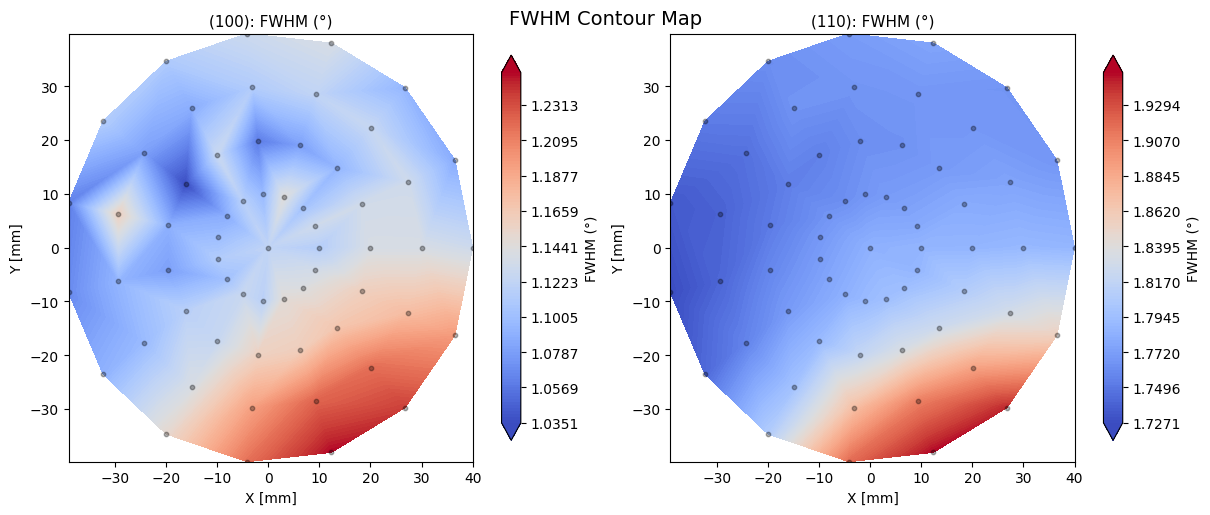

FWHM variability by plane (min, max, Δ):
  Region (100): min=1.0351, max=1.2512, Δ=0.2162
  Region (110): min=1.7271, max=1.9501, Δ=0.2230


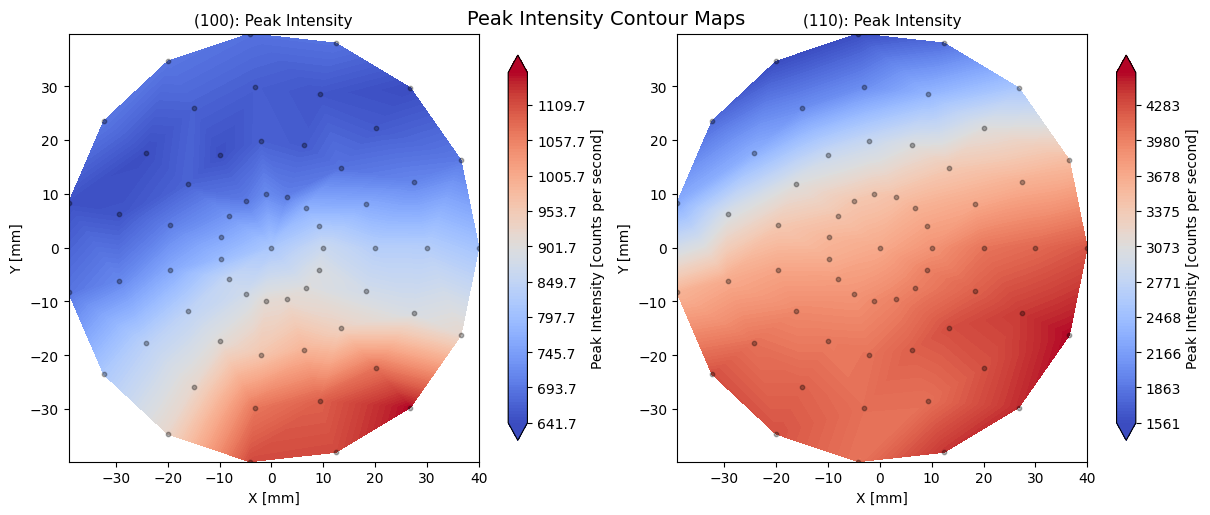

Peak intensity variability by plane (min, max, Δ):
  Region (100): min=641.6557, max=1157.3480, Δ=515.6923
  Region (110): min=1560.8694, max=4559.9034, Δ=2999.0340


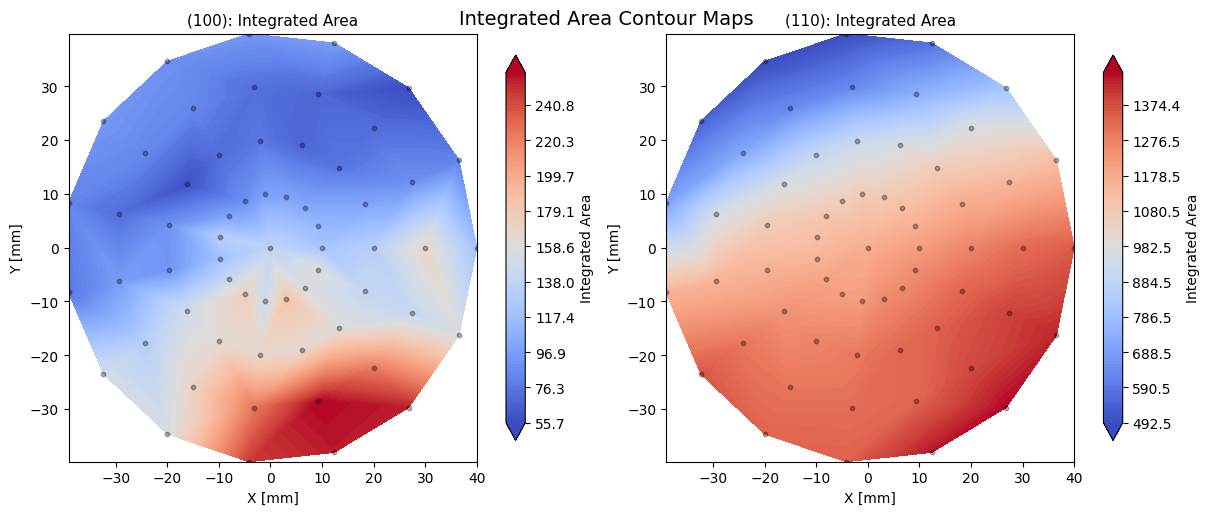

Integrated area variability by plane (min, max, Δ):
  Region (100): min=55.73, max=259.68, Δ=203.96
  Region (110): min=492.49, max=1464.28, Δ=971.78


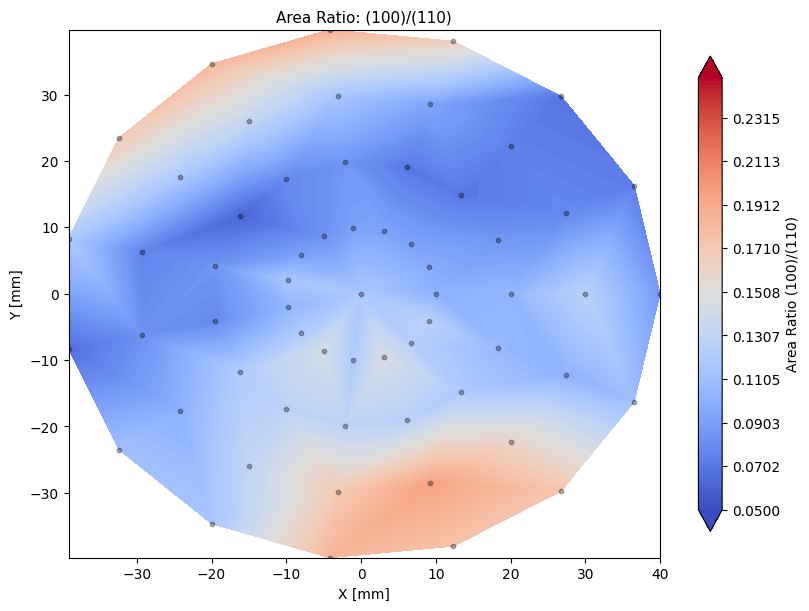


Area Ratio (100)/(110) statistics:
  min=0.061, max=0.195, mean=0.114, Δ=0.134


In [17]:
# ---- your inputs ----
x_pos = np.asarray(x_coordinates, dtype=float)
y_pos = np.asarray(y_coordinates, dtype=float)
fw_raw = np.asarray(results, dtype=float)
N = x_pos.size


# ---- normalize fw_raw into shape (N, 6) ----
def normalize_fwhm(fw_raw, N):
    fw = np.asarray(fw_raw)
    if fw.ndim == 2 and fw.shape == (N, 6):
        return fw
    if fw.ndim == 1 and fw.size == N * 6:
        return fw.reshape(N, 6)
    if fw.ndim == 2 and fw.shape[0] == N * 6 and fw.shape[1] == 6:
        blocks = np.split(fw, 6, axis=0)
        return np.column_stack([blocks[j][:, j] for j in range(6)])
    if fw.ndim == 2 and fw.shape == (N * 6, 1):
        return fw.reshape(N, 6)
    raise ValueError(f"Cannot reshape results with shape {fw.shape} to (N,6).")


fwhm = normalize_fwhm(fw_raw, N)


# ---- helpers for plotting ----
def _unique_xy(x, y, z):
    arr = np.column_stack([x, y, z])
    keys = np.ascontiguousarray(arr[:, :2]).view(
        np.dtype((np.void, arr[:, :2].dtype.itemsize * 2))
    ).ravel()
    _, idx = np.unique(keys, return_index=True)
    idx = np.sort(idx)
    return arr[idx, 0], arr[idx, 1], arr[idx, 2]


def _robust_minmax(zs):
    vmin = np.nanpercentile(zs, 5)
    vmax = np.nanpercentile(zs, 95)
    if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
        vmin = float(np.nanmin(zs))
        vmax = float(np.nanmax(zs))
    return vmin, vmax


def _contour_one(
    ax,
    xs,
    ys,
    zs,
    title,
    nlevels=100,
    cmap="coolwarm",
    try_grid_fallback=True,
    levels=None,
):
    m = np.isfinite(xs) & np.isfinite(ys) & np.isfinite(zs)
    xs, ys, zs = xs[m], ys[m], zs[m]
    if len(xs) == 0:
        ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
        ax.set_axis_off()
        return None

    xs, ys, zs = _unique_xy(xs, ys, zs)
    if len(xs) < 3:
        ax.text(
            0.5, 0.5, "Too few points", ha="center", va="center", transform=ax.transAxes
        )
        ax.set_axis_off()
        return None

    finite_levels = None
    if levels is not None:
        finite_levels = np.asarray(levels, dtype=float)
        finite_levels = finite_levels[np.isfinite(finite_levels)]

    if finite_levels is None or finite_levels.size == 0:
        vmin, vmax = _robust_minmax(zs)
        if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
            ax.text(
                0.5, 0.5, "No variation", ha="center", va="center", transform=ax.transAxes
            )
            ax.set_axis_off()
            return None
        finite_levels = np.linspace(vmin, vmax, nlevels)
    else:
        vmin = float(finite_levels.min())
        vmax = float(finite_levels.max())

    try:
        tri = Triangulation(xs, ys)
        cf = ax.tricontourf(
            tri,
            zs,
            levels=finite_levels,
            extend="both",
            cmap=cmap,
        )
    except Exception:
        if not try_grid_fallback:
            ax.text(
                0.5,
                0.5,
                "Triangulation failed",
                ha="center",
                va="center",
                transform=ax.transAxes,
            )
            ax.set_axis_off()
            return None

        gx = np.linspace(xs.min(), xs.max(), 60)
        gy = np.linspace(ys.min(), ys.max(), 60)
        GX, GY = np.meshgrid(gx, gy)
        GZ = griddata((xs, ys), zs, (GX, GY), method="linear")
        if np.isnan(GZ).all():
            GZ = griddata((xs, ys), zs, (GX, GY), method="nearest")
        if np.isnan(GZ).all():
            ax.text(
                0.5,
                0.5,
                "Insufficient geometry",
                ha="center",
                va="center",
                transform=ax.transAxes,
            )
            ax.set_axis_off()
            return None

        cf = ax.contourf(
            GX,
            GY,
            GZ,
            levels=finite_levels,
            extend="both",
            cmap=cmap,
        )

    ax.scatter(xs, ys, s=10, c="k", alpha=0.3)
    ax.set_title(title, fontsize=11)
    ax.set_xlabel("X [mm]")
    ax.set_ylabel("Y [mm]")
    return cf


# ---- Plot only (100) and (110) with independent colorbars ----
titles = [f"Region {REGION_NAMES[i]}" for i in range(6)]
planes_to_plot = [0, 1]  # (100) and (110)
plane_names = [REGION_NAMES[i] for i in planes_to_plot]

# Calculate statistics for each plane
plane_stats = []
for idx in planes_to_plot:
    plane_vals = np.asarray(fwhm[:, idx], dtype=float)
    finite_vals = plane_vals[np.isfinite(plane_vals)]
    if finite_vals.size:
        pmin = float(finite_vals.min())
        pmax = float(finite_vals.max())
        plane_stats.append(
            {"title": titles[idx], "min": pmin, "max": pmax, "range": pmax - pmin}
        )
    else:
        plane_stats.append(
            {"title": titles[idx], "min": np.nan, "max": np.nan, "range": np.nan}
        )

# ---- plot with individual colorbars for maximum variability ----
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

for plot_idx, plane_idx in enumerate(planes_to_plot):
    # Each plane gets its own levels based on its min/max
    plane_vals = fwhm[:, plane_idx]
    finite_vals = plane_vals[np.isfinite(plane_vals)]
    
    if finite_vals.size:
        pmin = float(finite_vals.min())
        pmax = float(finite_vals.max())
        if pmin == pmax:
            pmax = pmin + 1e-6
        plane_levels = np.linspace(pmin, pmax, 120)
    else:
        plane_levels = None
    
    cf = _contour_one(
        axes[plot_idx],
        x_pos,
        y_pos,
        fwhm[:, plane_idx],
        title=f"{plane_names[plot_idx]}: FWHM (°)",
        cmap="coolwarm",
        levels=plane_levels,
    )
    
    # Add individual colorbar for each subplot
    if cf is not None:
        fig.colorbar(cf, ax=axes[plot_idx], shrink=0.9, label="FWHM (°)")

plt.suptitle("FWHM Contour Map", y=1.00, fontsize=14)
plt.show()

print("FWHM variability by plane (min, max, Δ):")
for stat in plane_stats:
    title = stat["title"]
    if np.isnan(stat["range"]):
        print(f"  {title}: no finite data")
    else:
        print(
            f"  {title}: min={stat['min']:.4f}, max={stat['max']:.4f}, Δ={stat['range']:.4f}"
        )

# ===============================================================
# PEAK INTENSITY CONTOUR MAPS
# ===============================================================

# ---- inputs ----
pi_raw = np.asarray(peak_intensity, dtype=float)

def normalize_six(arr, N):
    a = np.asarray(arr)
    if a.ndim == 2 and a.shape == (N, 6):
        return a
    if a.ndim == 1 and a.size == N * 6:
        return a.reshape(N, 6)
    if a.ndim == 2 and a.shape[0] == N * 6 and a.shape[1] == 6:
        blocks = np.split(a, 6, axis=0)
        return np.column_stack([blocks[j][:, j] for j in range(6)])
    if a.ndim == 2 and a.shape == (N * 6, 1):
        return a.reshape(N, 6)
    raise ValueError(f"Cannot reshape array with shape {a.shape} to (N,6).")

peakI = normalize_six(pi_raw, N)

# Calculate statistics for each plane
plane_stats = []
for idx in planes_to_plot:
    plane_vals = np.asarray(peakI[:, idx], dtype=float)
    finite_vals = plane_vals[np.isfinite(plane_vals)]
    if finite_vals.size:
        pmin = float(finite_vals.min())
        pmax = float(finite_vals.max())
        plane_stats.append(
            {"title": titles[idx], "min": pmin, "max": pmax, "range": pmax - pmin}
        )
    else:
        plane_stats.append(
            {"title": titles[idx], "min": np.nan, "max": np.nan, "range": np.nan}
        )

# ---- plot with individual colorbars for maximum variability ----
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

for plot_idx, plane_idx in enumerate(planes_to_plot):
    # Each plane gets its own levels based on its min/max
    plane_vals = peakI[:, plane_idx]
    finite_vals = plane_vals[np.isfinite(plane_vals)]
    
    if finite_vals.size:
        pmin = float(finite_vals.min())
        pmax = float(finite_vals.max())
        if pmin == pmax:
            pmax = pmin + 1e-6
        plane_levels = np.linspace(pmin, pmax, 120)
    else:
        plane_levels = None
    
    cf = _contour_one(
        axes[plot_idx],
        x_pos,
        y_pos,
        peakI[:, plane_idx],
        title=f"{plane_names[plot_idx]}: Peak Intensity",
        cmap="coolwarm",
        levels=plane_levels,
    )
    
    # Add individual colorbar for each subplot
    if cf is not None:
        fig.colorbar(cf, ax=axes[plot_idx], shrink=0.9, label="Peak Intensity [counts per second]")

plt.suptitle("Peak Intensity Contour Maps", y=1.00, fontsize=14)
plt.show()

print("Peak intensity variability by plane (min, max, Δ):")
for stat in plane_stats:
    title = stat["title"]
    if np.isnan(stat["range"]):
        print(f"  {title}: no finite data")
    else:
        print(
            f"  {title}: min={stat['min']:.4f}, max={stat['max']:.4f}, Δ={stat['range']:.4f}"
        )

# ===============================================================
# INTEGRATED AREA CONTOUR MAPS
# ===============================================================

# ---- inputs ----
area_raw = np.asarray(peak_areas, dtype=float)
peakA = normalize_six(area_raw, N)

# Calculate statistics for each plane
plane_stats = []
for idx in planes_to_plot:
    plane_vals = np.asarray(peakA[:, idx], dtype=float)
    finite_vals = plane_vals[np.isfinite(plane_vals)]
    if finite_vals.size:
        pmin = float(finite_vals.min())
        pmax = float(finite_vals.max())
        plane_stats.append(
            {"title": titles[idx], "min": pmin, "max": pmax, "range": pmax - pmin}
        )
    else:
        plane_stats.append(
            {"title": titles[idx], "min": np.nan, "max": np.nan, "range": np.nan}
        )

# ---- plot with individual colorbars for maximum variability ----
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

for plot_idx, plane_idx in enumerate(planes_to_plot):
    # Each plane gets its own levels based on its min/max
    plane_vals = peakA[:, plane_idx]
    finite_vals = plane_vals[np.isfinite(plane_vals)]
    
    if finite_vals.size:
        pmin = float(finite_vals.min())
        pmax = float(finite_vals.max())
        if pmin == pmax:
            pmax = pmin + 1e-6
        plane_levels = np.linspace(pmin, pmax, 120)
    else:
        plane_levels = None
    
    cf = _contour_one(
        axes[plot_idx],
        x_pos,
        y_pos,
        peakA[:, plane_idx],
        title=f"{plane_names[plot_idx]}: Integrated Area",
        cmap="coolwarm",
        levels=plane_levels,
    )
    
    # Add individual colorbar for each subplot
    if cf is not None:
        fig.colorbar(cf, ax=axes[plot_idx], shrink=0.9, label="Integrated Area")

plt.suptitle("Integrated Area Contour Maps", y=1.00, fontsize=14)
plt.show()

print("Integrated area variability by plane (min, max, Δ):")
for stat in plane_stats:
    title = stat["title"]
    if np.isnan(stat["range"]):
        print(f"  {title}: no finite data")
    else:
        print(
            f"  {title}: min={stat['min']:.2f}, max={stat['max']:.2f}, Δ={stat['range']:.2f}"
        )

# ===============================================================
# AREA RATIO (100)/(110) CONTOUR MAP
# ===============================================================

# Calculate the ratio of (100) to (110) integrated areas
area_100 = peakA[:, 0]  # (100) is index 0
area_110 = peakA[:, 1]  # (110) is index 1

# Calculate ratio, handling division by zero
with np.errstate(divide='ignore', invalid='ignore'):
    area_ratio = area_100 / area_110

# Replace inf and -inf with NaN
area_ratio[~np.isfinite(area_ratio)] = np.nan

# Plot the ratio
fig, ax = plt.subplots(1, 1, figsize=(8, 6), constrained_layout=True)

# Get statistics
finite_ratio = area_ratio[np.isfinite(area_ratio)]
if finite_ratio.size > 0:
    rmin = float(finite_ratio.min())
    rmax = float(finite_ratio.max())
    rmean = float(finite_ratio.mean())
    if rmin == rmax:
        rmax = rmin + 1e-6
    ratio_levels = np.linspace(rmin, rmax, 120)
else:
    ratio_levels = None

cf = _contour_one(
    ax,
    x_pos,
    y_pos,
    area_ratio,
    title="Area Ratio: (100)/(110)",
    cmap="coolwarm",
    levels= np.linspace(0.05, 0.25, 120),
)

if cf is not None:
    fig.colorbar(cf, ax=ax, shrink=0.9, label="Area Ratio (100)/(110)")

#plt.suptitle("Integrated Area Ratio Contour Map", y=1.02, fontsize=12)
plt.show()

if finite_ratio.size > 0:
    print(f"\nArea Ratio (100)/(110) statistics:")
    print(f"  min={rmin:.3f}, max={rmax:.3f}, mean={rmean:.3f}, Δ={rmax-rmin:.3f}")
else:
    print("\nArea Ratio (100)/(110): No finite data")

### 100 and 110 Planes, FHWM, Peak Intensity, Integrated area and Ratio #2


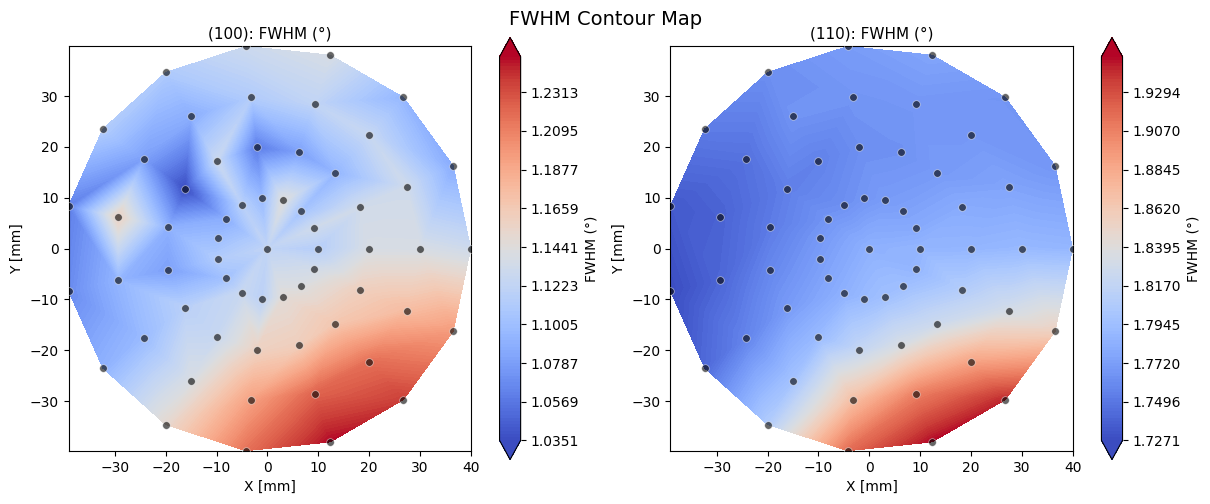

FWHM variability by plane (min, max, Δ):
  Region (100): min=1.0351, max=1.2512, Δ=0.2162
  Region (110): min=1.7271, max=1.9501, Δ=0.2230


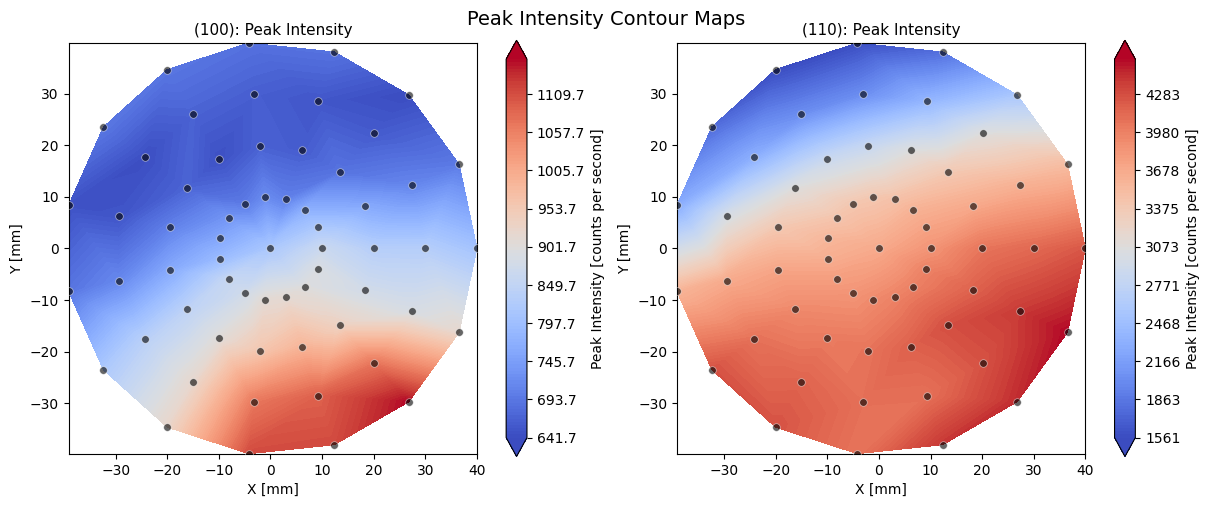

Peak intensity variability by plane (min, max, Δ):
  Region (100): min=641.6557, max=1157.3480, Δ=515.6923
  Region (110): min=1560.8694, max=4559.9034, Δ=2999.0340


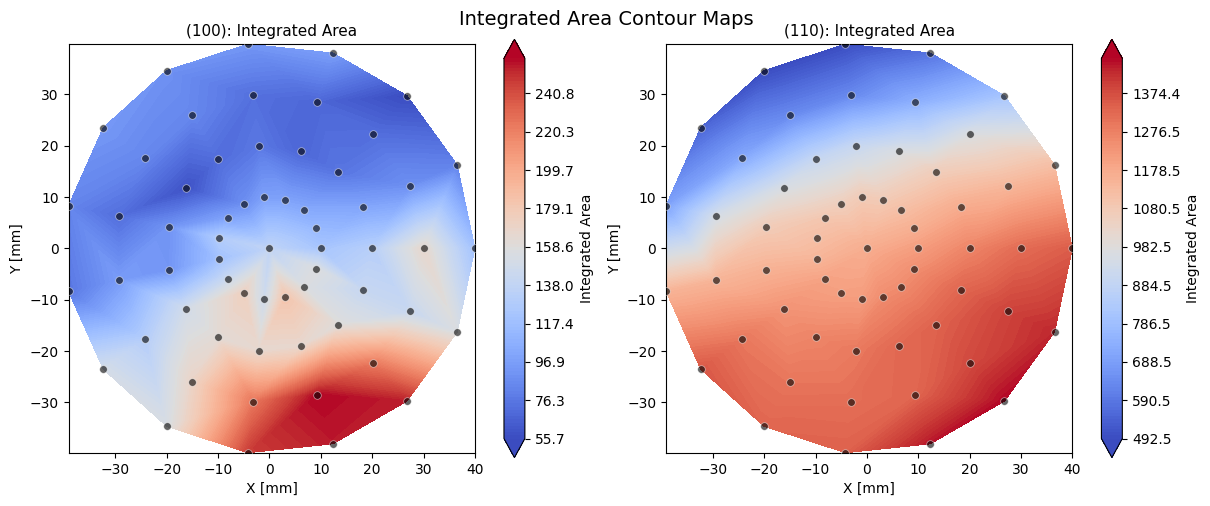

Integrated area variability by plane (min, max, Δ):
  Region (100): min=55.73, max=259.68, Δ=203.96
  Region (110): min=492.49, max=1464.28, Δ=971.78


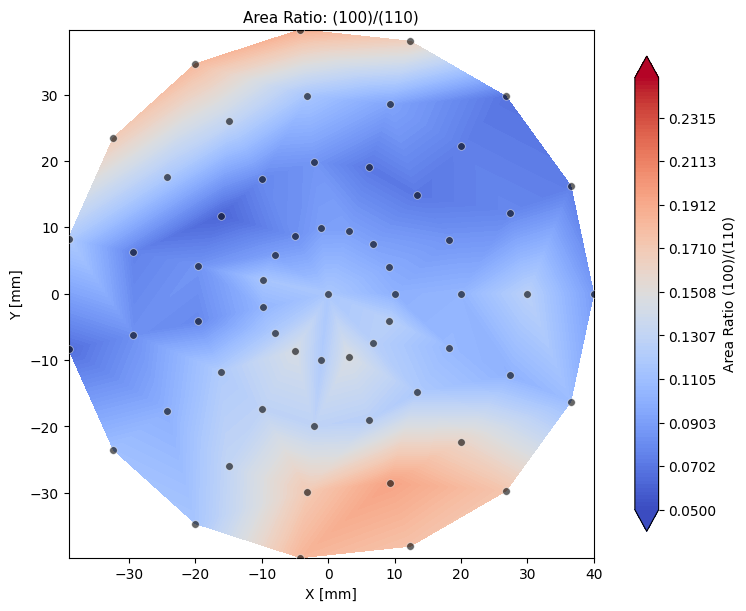


Area Ratio (100)/(110) statistics:
  min=0.061, max=0.195, mean=0.114, Δ=0.134


In [18]:
# ---- your inputs ----
x_pos = np.asarray(x_coordinates, dtype=float)
y_pos = np.asarray(y_coordinates, dtype=float)
fw_raw = np.asarray(results, dtype=float)
N = x_pos.size


# ---- normalize fw_raw into shape (N, 6) ----
def normalize_fwhm(fw_raw, N):
    fw = np.asarray(fw_raw)
    if fw.ndim == 2 and fw.shape == (N, 6):
        return fw
    if fw.ndim == 1 and fw.size == N * 6:
        return fw.reshape(N, 6)
    if fw.ndim == 2 and fw.shape[0] == N * 6 and fw.shape[1] == 6:
        blocks = np.split(fw, 6, axis=0)
        return np.column_stack([blocks[j][:, j] for j in range(6)])
    if fw.ndim == 2 and fw.shape == (N * 6, 1):
        return fw.reshape(N, 6)
    raise ValueError(f"Cannot reshape results with shape {fw.shape} to (N,6).")


fwhm = normalize_fwhm(fw_raw, N)


# ---- helpers for plotting ----
def _unique_xy(x, y, z):
    arr = np.column_stack([x, y, z])
    keys = np.ascontiguousarray(arr[:, :2]).view(
        np.dtype((np.void, arr[:, :2].dtype.itemsize * 2))
    ).ravel()
    _, idx = np.unique(keys, return_index=True)
    idx = np.sort(idx)
    return arr[idx, 0], arr[idx, 1], arr[idx, 2]


def _robust_minmax(zs):
    vmin = np.nanpercentile(zs, 5)
    vmax = np.nanpercentile(zs, 95)
    if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
        vmin = float(np.nanmin(zs))
        vmax = float(np.nanmax(zs))
    return vmin, vmax


def _contour_one(
    ax,
    xs_all,
    ys_all,
    zs_all,
    title,
    nlevels=100,
    cmap="coolwarm",
    levels=None,
):
    """
    Create smooth contour plot using triangulation.
    Shows all measurement points with markers.
    """
    # Separate finite and NaN data points
    mask_finite = np.isfinite(xs_all) & np.isfinite(ys_all) & np.isfinite(zs_all)
    xs = xs_all[mask_finite]
    ys = ys_all[mask_finite]
    zs = zs_all[mask_finite]
    
    if len(xs) == 0:
        ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
        # Still show all measurement points even if no data
        ax.scatter(xs_all, ys_all, s=30, c='red', marker='x', alpha=0.6, linewidths=2)
        ax.set_title(title, fontsize=11)
        ax.set_xlabel("X [mm]")
        ax.set_ylabel("Y [mm]")
        ax.set_aspect('equal', adjustable='box')
        return None

    xs, ys, zs = _unique_xy(xs, ys, zs)
    
    if len(xs) < 3:
        ax.text(0.5, 0.5, "Too few points", ha="center", va="center", transform=ax.transAxes)
        # Show all measurement points
        ax.scatter(xs_all, ys_all, s=30, c='red', marker='x', alpha=0.6, linewidths=2)
        ax.set_title(title, fontsize=11)
        ax.set_xlabel("X [mm]")
        ax.set_ylabel("Y [mm]")
        ax.set_aspect('equal', adjustable='box')
        return None

    # Determine color levels
    finite_levels = None
    if levels is not None:
        finite_levels = np.asarray(levels, dtype=float)
        finite_levels = finite_levels[np.isfinite(finite_levels)]

    if finite_levels is None or finite_levels.size == 0:
        vmin, vmax = _robust_minmax(zs)
        if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
            ax.text(
                0.5, 0.5, "No variation", ha="center", va="center", transform=ax.transAxes
            )
            ax.set_title(title, fontsize=11)
            ax.set_xlabel("X [mm]")
            ax.set_ylabel("Y [mm]")
            ax.set_aspect('equal', adjustable='box')
            return None
        finite_levels = np.linspace(vmin, vmax, nlevels)
    else:
        vmin = float(finite_levels.min())
        vmax = float(finite_levels.max())

    # Use triangulation for smooth edges
    try:
        tri = Triangulation(xs, ys)
        cf = ax.tricontourf(
            tri,
            zs,
            levels=finite_levels,
            extend="both",
            cmap=cmap,
        )
    except Exception:
        # Fallback: try grid interpolation
        gx = np.linspace(xs.min(), xs.max(), 100)
        gy = np.linspace(ys.min(), ys.max(), 100)
        GX, GY = np.meshgrid(gx, gy)
        GZ = griddata((xs, ys), zs, (GX, GY), method="linear")
        if np.isnan(GZ).all():
            GZ = griddata((xs, ys), zs, (GX, GY), method="nearest")
        if np.isnan(GZ).all():
            ax.text(0.5, 0.5, "Triangulation failed", ha="center", va="center", transform=ax.transAxes)
            ax.set_title(title, fontsize=11)
            ax.set_xlabel("X [mm]")
            ax.set_ylabel("Y [mm]")
            ax.set_aspect('equal', adjustable='box')
            return None
        
        cf = ax.contourf(GX, GY, GZ, levels=finite_levels, extend="both", cmap=cmap)

    # Scatter plot: show ALL measurement points
    # Black circles for detected peaks
    if np.sum(mask_finite) > 0:
        ax.scatter(xs_all[mask_finite], ys_all[mask_finite], 
                   s=30, c="k", alpha=0.6, edgecolors='white', linewidths=0.5, zorder=5)
    
    # Red X for missing/undetected peaks
    if np.sum(~mask_finite) > 0:
        ax.scatter(xs_all[~mask_finite], ys_all[~mask_finite], 
                   s=30, c="red", marker='x', alpha=0.8, linewidths=2, zorder=5)
    
    ax.set_title(title, fontsize=11)
    ax.set_xlabel("X [mm]")
    ax.set_ylabel("Y [mm]")
    ax.set_aspect('equal', adjustable='box')
    
    return cf


# ---- Plot only (100) and (110) with independent colorbars ----
titles = [f"Region {REGION_NAMES[i]}" for i in range(6)]
planes_to_plot = [0, 1]  # (100) and (110)
plane_names = [REGION_NAMES[i] for i in planes_to_plot]

# Calculate statistics for each plane
plane_stats = []
for idx in planes_to_plot:
    plane_vals = np.asarray(fwhm[:, idx], dtype=float)
    finite_vals = plane_vals[np.isfinite(plane_vals)]
    if finite_vals.size:
        pmin = float(finite_vals.min())
        pmax = float(finite_vals.max())
        plane_stats.append(
            {"title": titles[idx], "min": pmin, "max": pmax, "range": pmax - pmin}
        )
    else:
        plane_stats.append(
            {"title": titles[idx], "min": np.nan, "max": np.nan, "range": np.nan}
        )

# ---- plot with individual colorbars for maximum variability ----
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

for plot_idx, plane_idx in enumerate(planes_to_plot):
    # Each plane gets its own levels based on its min/max
    plane_vals = fwhm[:, plane_idx]
    finite_vals = plane_vals[np.isfinite(plane_vals)]
    
    if finite_vals.size:
        pmin = float(finite_vals.min())
        pmax = float(finite_vals.max())
        if pmin == pmax:
            pmax = pmin + 1e-6
        plane_levels = np.linspace(pmin, pmax, 120)
    else:
        plane_levels = None
    
    cf = _contour_one(
        axes[plot_idx],
        x_pos,
        y_pos,
        fwhm[:, plane_idx],
        title=f"{plane_names[plot_idx]}: FWHM (°)",
        cmap="coolwarm",
        levels=plane_levels,
    )
    
    # Add individual colorbar for each subplot
    if cf is not None:
        fig.colorbar(cf, ax=axes[plot_idx], shrink=0.9, label="FWHM (°)")

plt.suptitle("FWHM Contour Map", y=1.00, fontsize=14)
plt.show()

print("FWHM variability by plane (min, max, Δ):")
for stat in plane_stats:
    title = stat["title"]
    if np.isnan(stat["range"]):
        print(f"  {title}: no finite data")
    else:
        print(
            f"  {title}: min={stat['min']:.4f}, max={stat['max']:.4f}, Δ={stat['range']:.4f}"
        )

# ===============================================================
# PEAK INTENSITY CONTOUR MAPS
# ===============================================================

# ---- inputs ----
pi_raw = np.asarray(peak_intensity, dtype=float)

def normalize_six(arr, N):
    a = np.asarray(arr)
    if a.ndim == 2 and a.shape == (N, 6):
        return a
    if a.ndim == 1 and a.size == N * 6:
        return a.reshape(N, 6)
    if a.ndim == 2 and a.shape[0] == N * 6 and a.shape[1] == 6:
        blocks = np.split(a, 6, axis=0)
        return np.column_stack([blocks[j][:, j] for j in range(6)])
    if a.ndim == 2 and a.shape == (N * 6, 1):
        return a.reshape(N, 6)
    raise ValueError(f"Cannot reshape array with shape {a.shape} to (N,6).")

peakI = normalize_six(pi_raw, N)

# Calculate statistics for each plane
plane_stats = []
for idx in planes_to_plot:
    plane_vals = np.asarray(peakI[:, idx], dtype=float)
    finite_vals = plane_vals[np.isfinite(plane_vals)]
    if finite_vals.size:
        pmin = float(finite_vals.min())
        pmax = float(finite_vals.max())
        plane_stats.append(
            {"title": titles[idx], "min": pmin, "max": pmax, "range": pmax - pmin}
        )
    else:
        plane_stats.append(
            {"title": titles[idx], "min": np.nan, "max": np.nan, "range": np.nan}
        )

# ---- plot with individual colorbars for maximum variability ----
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

for plot_idx, plane_idx in enumerate(planes_to_plot):
    # Each plane gets its own levels based on its min/max
    plane_vals = peakI[:, plane_idx]
    finite_vals = plane_vals[np.isfinite(plane_vals)]
    
    if finite_vals.size:
        pmin = float(finite_vals.min())
        pmax = float(finite_vals.max())
        if pmin == pmax:
            pmax = pmin + 1e-6
        plane_levels = np.linspace(pmin, pmax, 120)
    else:
        plane_levels = None
    
    cf = _contour_one(
        axes[plot_idx],
        x_pos,
        y_pos,
        peakI[:, plane_idx],
        title=f"{plane_names[plot_idx]}: Peak Intensity",
        cmap="coolwarm",
        levels=plane_levels,
    )
    
    # Add individual colorbar for each subplot
    if cf is not None:
        fig.colorbar(cf, ax=axes[plot_idx], shrink=0.9, label="Peak Intensity [counts per second]")

plt.suptitle("Peak Intensity Contour Maps", y=1.00, fontsize=14)
plt.show()

print("Peak intensity variability by plane (min, max, Δ):")
for stat in plane_stats:
    title = stat["title"]
    if np.isnan(stat["range"]):
        print(f"  {title}: no finite data")
    else:
        print(
            f"  {title}: min={stat['min']:.4f}, max={stat['max']:.4f}, Δ={stat['range']:.4f}"
        )

# ===============================================================
# INTEGRATED AREA CONTOUR MAPS
# ===============================================================

# ---- inputs ----
area_raw = np.asarray(peak_areas, dtype=float)
peakA = normalize_six(area_raw, N)

# Calculate statistics for each plane
plane_stats = []
for idx in planes_to_plot:
    plane_vals = np.asarray(peakA[:, idx], dtype=float)
    finite_vals = plane_vals[np.isfinite(plane_vals)]
    if finite_vals.size:
        pmin = float(finite_vals.min())
        pmax = float(finite_vals.max())
        plane_stats.append(
            {"title": titles[idx], "min": pmin, "max": pmax, "range": pmax - pmin}
        )
    else:
        plane_stats.append(
            {"title": titles[idx], "min": np.nan, "max": np.nan, "range": np.nan}
        )

# ---- plot with individual colorbars for maximum variability ----
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

for plot_idx, plane_idx in enumerate(planes_to_plot):
    # Each plane gets its own levels based on its min/max
    plane_vals = peakA[:, plane_idx]
    finite_vals = plane_vals[np.isfinite(plane_vals)]
    
    if finite_vals.size:
        pmin = float(finite_vals.min())
        pmax = float(finite_vals.max())
        if pmin == pmax:
            pmax = pmin + 1e-6
        plane_levels = np.linspace(pmin, pmax, 120)
    else:
        plane_levels = None
    
    cf = _contour_one(
        axes[plot_idx],
        x_pos,
        y_pos,
        peakA[:, plane_idx],
        title=f"{plane_names[plot_idx]}: Integrated Area",
        cmap="coolwarm",
        levels=plane_levels,
    )
    
    # Add individual colorbar for each subplot
    if cf is not None:
        fig.colorbar(cf, ax=axes[plot_idx], shrink=0.9, label="Integrated Area")

plt.suptitle("Integrated Area Contour Maps", y=1.00, fontsize=14)
plt.show()

print("Integrated area variability by plane (min, max, Δ):")
for stat in plane_stats:
    title = stat["title"]
    if np.isnan(stat["range"]):
        print(f"  {title}: no finite data")
    else:
        print(
            f"  {title}: min={stat['min']:.2f}, max={stat['max']:.2f}, Δ={stat['range']:.2f}"
        )

# ===============================================================
# AREA RATIO (100)/(110) CONTOUR MAP
# ===============================================================

# Calculate the ratio of (100) to (110) integrated areas
area_100 = peakA[:, 0]  # (100) is index 0
area_110 = peakA[:, 1]  # (110) is index 1

# Calculate ratio, handling division by zero
with np.errstate(divide='ignore', invalid='ignore'):
    area_ratio = area_100 / area_110

# Replace inf and -inf with NaN
area_ratio[~np.isfinite(area_ratio)] = np.nan

# Plot the ratio
fig, ax = plt.subplots(1, 1, figsize=(8, 6), constrained_layout=True)

# Get statistics
finite_ratio = area_ratio[np.isfinite(area_ratio)]
if finite_ratio.size > 0:
    rmin = float(finite_ratio.min())
    rmax = float(finite_ratio.max())
    rmean = float(finite_ratio.mean())
    if rmin == rmax:
        rmax = rmin + 1e-6
    ratio_levels = np.linspace(rmin, rmax, 120)
else:
    ratio_levels = None

cf = _contour_one(
    ax,
    x_pos,
    y_pos,
    area_ratio,
    title="Area Ratio: (100)/(110)",
    cmap="coolwarm",
    levels=np.linspace(0.05, 0.25, 120),
)

if cf is not None:
    fig.colorbar(cf, ax=ax, shrink=0.9, label="Area Ratio (100)/(110)")

#plt.suptitle("Integrated Area Ratio Contour Map", y=1.02, fontsize=12)
plt.show()

if finite_ratio.size > 0:
    print(f"\nArea Ratio (100)/(110) statistics:")
    print(f"  min={rmin:.3f}, max={rmax:.3f}, mean={rmean:.3f}, Δ={rmax-rmin:.3f}")
else:
    print("\nArea Ratio (100)/(110): No finite data")

### Integrated Area by distance to Target Center

3D Distance to target statistics:
  Distance range: 158.64 - 224.99 mm
  Mean distance: 192.11 mm


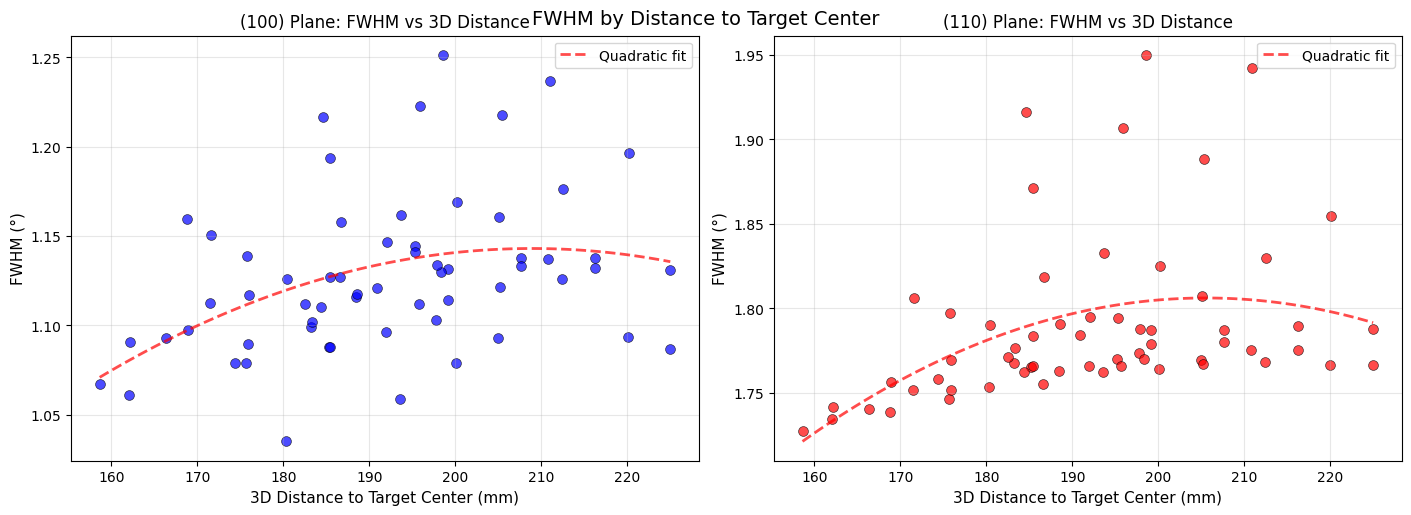

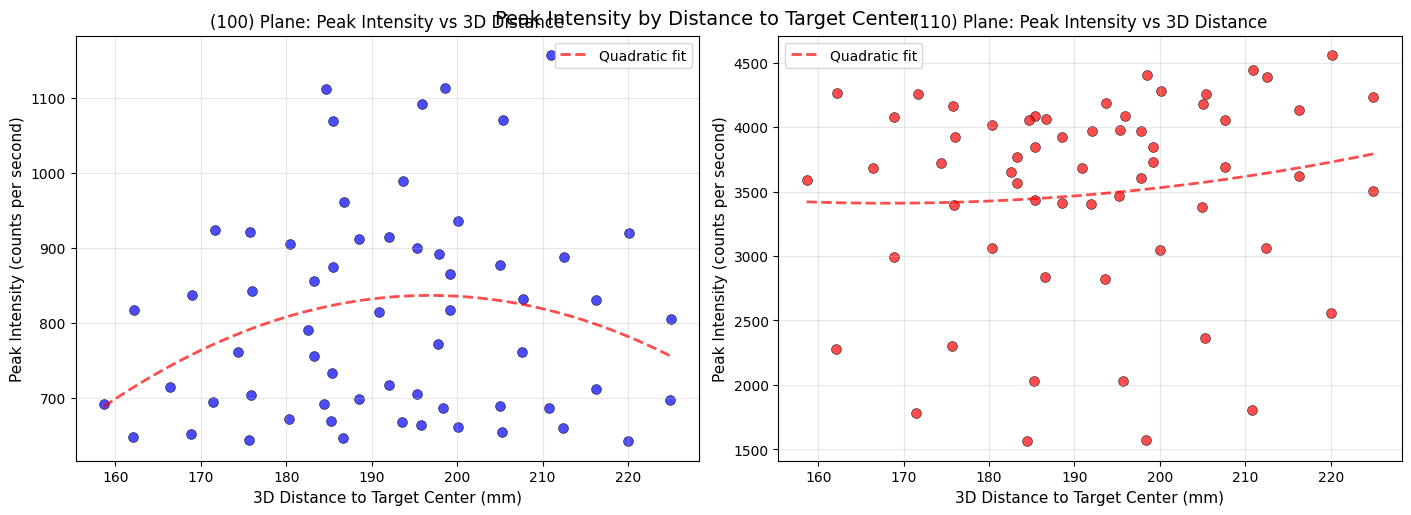

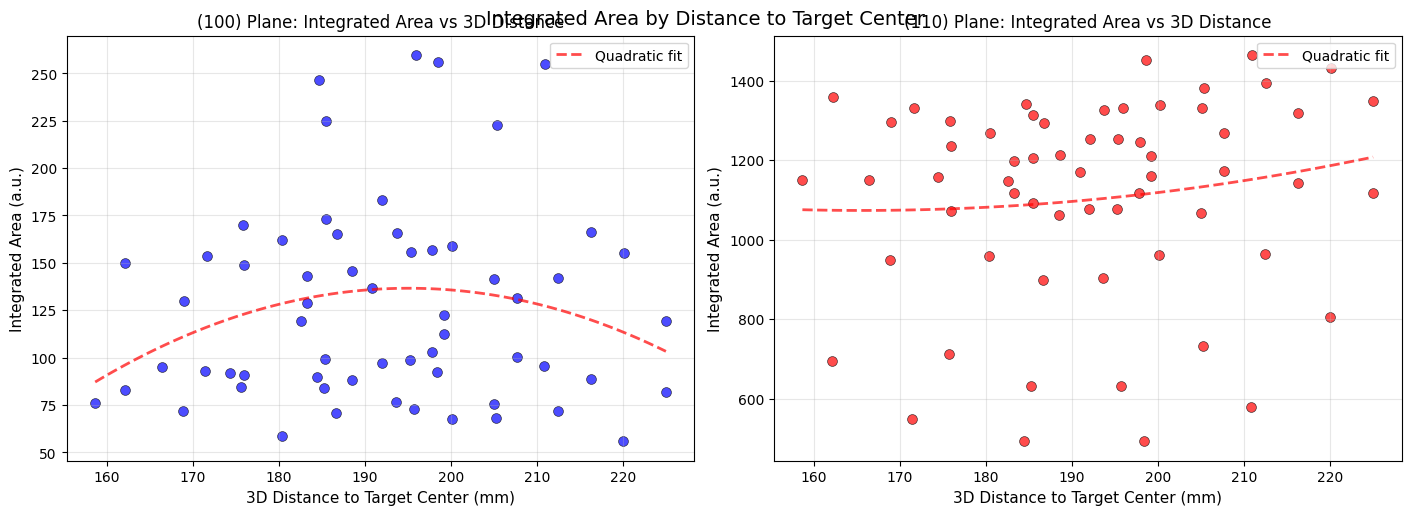

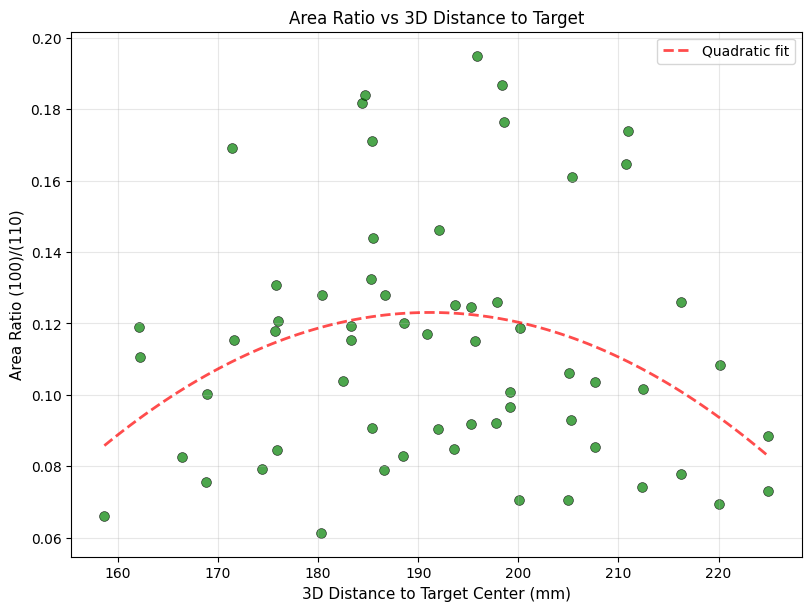


Correlation coefficients (Pearson) with 3D distance:

FWHM:
  (100): r = 0.346
  (110): r = 0.340

Peak Intensity:
  (100): r = 0.104
  (110): r = 0.120

Integrated Area:
  (100): r = 0.062
  (110): r = 0.131

Area Ratio (100)/(110): r = -0.041


In [19]:
# ===============================================================
# INTEGRATED AREA BY DISTANCE TO TARGET CENTER
# ===============================================================

# Target position (mm)
target_x = 399.88
target_y = 224.1
target_z = 332.15

# Wafer center position (x=0, y=0 in XRD coordinates corresponds to this)
wafer_center_x = 242.5
wafer_center_y = 257.0
wafer_center_z = 435.0

# Convert XRD coordinates to real-world coordinates
# The x_coordinates from XRD need to have their sign flipped
x_pos_real = -np.asarray(x_coordinates, dtype=float) + wafer_center_x
y_pos_real = np.asarray(y_coordinates, dtype=float) + wafer_center_y
z_pos_real = np.full_like(x_pos_real, wafer_center_z)  # Assuming all measurements at same z

# Calculate 3D distance from each point to target
distances_3d = np.sqrt(
    (x_pos_real - target_x)**2 + 
    (y_pos_real - target_y)**2 + 
    (z_pos_real - target_z)**2
)

print("3D Distance to target statistics:")
print(f"  Distance range: {distances_3d.min():.2f} - {distances_3d.max():.2f} mm")
print(f"  Mean distance: {distances_3d.mean():.2f} mm")

# Get data for (100) and (110) planes
area_100 = peakA[:, 0]  # (100) integrated area
area_110 = peakA[:, 1]  # (110) integrated area
fwhm_100 = fwhm[:, 0]   # (100) FWHM
fwhm_110 = fwhm[:, 1]   # (110) FWHM
intensity_100 = peakI[:, 0]  # (100) peak intensity
intensity_110 = peakI[:, 1]  # (110) peak intensity

# Calculate area ratio
with np.errstate(divide='ignore', invalid='ignore'):
    area_ratio = area_100 / area_110
area_ratio[~np.isfinite(area_ratio)] = np.nan

# ===============================================================
# PLOT 1: FWHM vs 3D Distance
# ===============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

# (100) FWHM
ax = axes[0]
mask_finite = np.isfinite(fwhm_100) & np.isfinite(distances_3d)
ax.scatter(distances_3d[mask_finite], fwhm_100[mask_finite], 
           c='blue', s=50, alpha=0.7, edgecolors='black', linewidths=0.5)
ax.set_xlabel('3D Distance to Target Center (mm)', fontsize=11)
ax.set_ylabel('FWHM (°)', fontsize=11)
ax.set_title('(100) Plane: FWHM vs 3D Distance', fontsize=12)
ax.grid(True, alpha=0.3)

if np.sum(mask_finite) > 3:
    z = np.polyfit(distances_3d[mask_finite], fwhm_100[mask_finite], 2)
    p = np.poly1d(z)
    x_trend = np.linspace(distances_3d[mask_finite].min(), distances_3d[mask_finite].max(), 100)
    ax.plot(x_trend, p(x_trend), 'r--', linewidth=2, alpha=0.7, label='Quadratic fit')
    ax.legend()

# (110) FWHM
ax = axes[1]
mask_finite = np.isfinite(fwhm_110) & np.isfinite(distances_3d)
ax.scatter(distances_3d[mask_finite], fwhm_110[mask_finite], 
           c='red', s=50, alpha=0.7, edgecolors='black', linewidths=0.5)
ax.set_xlabel('3D Distance to Target Center (mm)', fontsize=11)
ax.set_ylabel('FWHM (°)', fontsize=11)
ax.set_title('(110) Plane: FWHM vs 3D Distance', fontsize=12)
ax.grid(True, alpha=0.3)

if np.sum(mask_finite) > 3:
    z = np.polyfit(distances_3d[mask_finite], fwhm_110[mask_finite], 2)
    p = np.poly1d(z)
    x_trend = np.linspace(distances_3d[mask_finite].min(), distances_3d[mask_finite].max(), 100)
    ax.plot(x_trend, p(x_trend), 'r--', linewidth=2, alpha=0.7, label='Quadratic fit')
    ax.legend()

plt.suptitle('FWHM by Distance to Target Center', y=1.00, fontsize=14)
plt.show()

# ===============================================================
# PLOT 2: Peak Intensity vs 3D Distance
# ===============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

# (100) Peak Intensity
ax = axes[0]
mask_finite = np.isfinite(intensity_100) & np.isfinite(distances_3d)
ax.scatter(distances_3d[mask_finite], intensity_100[mask_finite], 
           c='blue', s=50, alpha=0.7, edgecolors='black', linewidths=0.5)
ax.set_xlabel('3D Distance to Target Center (mm)', fontsize=11)
ax.set_ylabel('Peak Intensity (counts per second)', fontsize=11)
ax.set_title('(100) Plane: Peak Intensity vs 3D Distance', fontsize=12)
ax.grid(True, alpha=0.3)

if np.sum(mask_finite) > 3:
    z = np.polyfit(distances_3d[mask_finite], intensity_100[mask_finite], 2)
    p = np.poly1d(z)
    x_trend = np.linspace(distances_3d[mask_finite].min(), distances_3d[mask_finite].max(), 100)
    ax.plot(x_trend, p(x_trend), 'r--', linewidth=2, alpha=0.7, label='Quadratic fit')
    ax.legend()

# (110) Peak Intensity
ax = axes[1]
mask_finite = np.isfinite(intensity_110) & np.isfinite(distances_3d)
ax.scatter(distances_3d[mask_finite], intensity_110[mask_finite], 
           c='red', s=50, alpha=0.7, edgecolors='black', linewidths=0.5)
ax.set_xlabel('3D Distance to Target Center (mm)', fontsize=11)
ax.set_ylabel('Peak Intensity (counts per second)', fontsize=11)
ax.set_title('(110) Plane: Peak Intensity vs 3D Distance', fontsize=12)
ax.grid(True, alpha=0.3)

if np.sum(mask_finite) > 3:
    z = np.polyfit(distances_3d[mask_finite], intensity_110[mask_finite], 2)
    p = np.poly1d(z)
    x_trend = np.linspace(distances_3d[mask_finite].min(), distances_3d[mask_finite].max(), 100)
    ax.plot(x_trend, p(x_trend), 'r--', linewidth=2, alpha=0.7, label='Quadratic fit')
    ax.legend()

plt.suptitle('Peak Intensity by Distance to Target Center', y=1.00, fontsize=14)
plt.show()

# ===============================================================
# PLOT 3: Integrated Area vs 3D Distance
# ===============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

# (100) Integrated Area
ax = axes[0]
mask_finite = np.isfinite(area_100) & np.isfinite(distances_3d)
ax.scatter(distances_3d[mask_finite], area_100[mask_finite], 
           c='blue', s=50, alpha=0.7, edgecolors='black', linewidths=0.5)
ax.set_xlabel('3D Distance to Target Center (mm)', fontsize=11)
ax.set_ylabel('Integrated Area (a.u.)', fontsize=11)
ax.set_title('(100) Plane: Integrated Area vs 3D Distance', fontsize=12)
ax.grid(True, alpha=0.3)

if np.sum(mask_finite) > 3:
    z = np.polyfit(distances_3d[mask_finite], area_100[mask_finite], 2)
    p = np.poly1d(z)
    x_trend = np.linspace(distances_3d[mask_finite].min(), distances_3d[mask_finite].max(), 100)
    ax.plot(x_trend, p(x_trend), 'r--', linewidth=2, alpha=0.7, label='Quadratic fit')
    ax.legend()

# (110) Integrated Area
ax = axes[1]
mask_finite = np.isfinite(area_110) & np.isfinite(distances_3d)
ax.scatter(distances_3d[mask_finite], area_110[mask_finite], 
           c='red', s=50, alpha=0.7, edgecolors='black', linewidths=0.5)
ax.set_xlabel('3D Distance to Target Center (mm)', fontsize=11)
ax.set_ylabel('Integrated Area (a.u.)', fontsize=11)
ax.set_title('(110) Plane: Integrated Area vs 3D Distance', fontsize=12)
ax.grid(True, alpha=0.3)

if np.sum(mask_finite) > 3:
    z = np.polyfit(distances_3d[mask_finite], area_110[mask_finite], 2)
    p = np.poly1d(z)
    x_trend = np.linspace(distances_3d[mask_finite].min(), distances_3d[mask_finite].max(), 100)
    ax.plot(x_trend, p(x_trend), 'r--', linewidth=2, alpha=0.7, label='Quadratic fit')
    ax.legend()

plt.suptitle('Integrated Area by Distance to Target Center', y=1.00, fontsize=14)
plt.show()

# ===============================================================
# PLOT 4: Area Ratio (100)/(110) vs 3D Distance
# ===============================================================
fig, ax = plt.subplots(1, 1, figsize=(8, 6), constrained_layout=True)

mask_finite = np.isfinite(area_ratio) & np.isfinite(distances_3d)
ax.scatter(distances_3d[mask_finite], area_ratio[mask_finite], 
           c='green', s=50, alpha=0.7, edgecolors='black', linewidths=0.5)
ax.set_xlabel('3D Distance to Target Center (mm)', fontsize=11)
ax.set_ylabel('Area Ratio (100)/(110)', fontsize=11)
ax.set_title('Area Ratio vs 3D Distance to Target', fontsize=12)
ax.grid(True, alpha=0.3)

if np.sum(mask_finite) > 3:
    z = np.polyfit(distances_3d[mask_finite], area_ratio[mask_finite], 2)
    p = np.poly1d(z)
    x_trend = np.linspace(distances_3d[mask_finite].min(), distances_3d[mask_finite].max(), 100)
    ax.plot(x_trend, p(x_trend), 'r--', linewidth=2, alpha=0.7, label='Quadratic fit')
    ax.legend()

plt.show()

# Print correlation statistics
print("\nCorrelation coefficients (Pearson) with 3D distance:")
for metric_name, data_100, data_110 in [
    ("FWHM", fwhm_100, fwhm_110),
    ("Peak Intensity", intensity_100, intensity_110),
    ("Integrated Area", area_100, area_110)
]:
    print(f"\n{metric_name}:")
    for plane_name, data in [("(100)", data_100), ("(110)", data_110)]:
        mask = np.isfinite(data) & np.isfinite(distances_3d)
        if np.sum(mask) > 2:
            corr = np.corrcoef(distances_3d[mask], data[mask])[0, 1]
            print(f"  {plane_name}: r = {corr:.3f}")

# Area ratio
mask = np.isfinite(area_ratio) & np.isfinite(distances_3d)
if np.sum(mask) > 2:
    corr = np.corrcoef(distances_3d[mask], area_ratio[mask])[0, 1]
    print(f"\nArea Ratio (100)/(110): r = {corr:.3f}")